In [3]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Optional, Dict, TextIO, List, Tuple, Set
from enum import Enum
from itertools import repeat
import re
from collections import defaultdict, Counter

In [2]:
Contig = str
TRANSLATE = str.maketrans("ATGC", "TACG")
STOP = "*"
MISSENSE = "X"
PROT = "PROT"
DNA = "DNA"
NUCLEOTIDES = ["A", "C", "G", "T"]
Contig = str
Seq = str
Index = Dict[Contig, Seq]

codon2amino = {
    "TCA": "S",
    "TCC": "S",
    "TCG": "S",
    "TCT": "S",
    "TTC": "F",
    "TTT": "F",
    "TTA": "L",
    "TTG": "L",
    "TAC": "Y",
    "TAT": "Y",
    "TAA": STOP,
    "TAG": STOP,
    "TGC": "C",
    "TGT": "C",
    "TGA": STOP,
    "TGG": "W",
    "CTA": "L",
    "CTC": "L",
    "CTG": "L",
    "CTT": "L",
    "CCA": "P",
    "CCC": "P",
    "CCG": "P",
    "CCT": "P",
    "CAC": "H",
    "CAT": "H",
    "CAA": "Q",
    "CAG": "Q",
    "CGA": "R",
    "CGC": "R",
    "CGG": "R",
    "CGT": "R",
    "ATA": "I",
    "ATC": "I",
    "ATT": "I",
    "ATG": "M",
    "ACA": "T",
    "ACC": "T",
    "ACG": "T",
    "ACT": "T",
    "AAC": "N",
    "AAT": "N",
    "AAA": "K",
    "AAG": "K",
    "AGC": "S",
    "AGT": "S",
    "AGA": "R",
    "AGG": "R",
    "GTA": "V",
    "GTC": "V",
    "GTG": "V",
    "GTT": "V",
    "GCA": "A",
    "GCC": "A",
    "GCG": "A",
    "GCT": "A",
    "GAC": "D",
    "GAT": "D",
    "GAA": "E",
    "GAG": "E",
    "GGA": "G",
    "GGC": "G",
    "GGG": "G",
    "GGT": "G",
}
amino2codons = defaultdict(set)
for codon, aa in codon2amino.items():
    amino2codons[aa].add(codon)


def revcomp(s: str) -> str:
    return complement(s)[::-1]


def complement(s: str) -> str:
    return s.upper().translate(TRANSLATE)


class Strand(Enum):
    Forward = "+"
    Reverse = "-"
    NotRelevant = "."
    Unknown = "?"

    def __str__(self) -> str:
        return str(self.value)

    
def translate(seq: str, stop_last=True) -> str:
    if len(seq) % 3 != 0:
        raise ValueError("Sequence length must be a multiple of 3")

    prot = ""
    for i in range(0, len(seq), 3):
        codon = seq[i : i + 3]
        prot += codon2amino[codon]

    if stop_last and not prot.endswith(STOP):
        raise ValueError("Sequence did not end in a stop codon")

    return prot

@dataclass
class GffFeature:
    seqid: Contig
    source: str
    method: str  # correct term is type, but that is a python reserved variable name
    start: int  # 1-based inclusive
    end: int  # 1-based inclusive
    score: float
    strand: Strand
    phase: int
    attributes: Dict[str, str]

    @staticmethod
    def from_str(s: str) -> "GffFeature":
        fields = s.split("\t")
        score = 0 if fields[5] == "." else float(fields[5])
        phase = -1 if fields[7] == "." else int(fields[7])
        attr_fields = fields[-1].split(";")
        attributes = {k: v for k, v in map(str.split, attr_fields, repeat("="))}
        return GffFeature(
            seqid=fields[0],
            source=fields[1],
            method=fields[2],
            start=int(fields[3]),
            end=int(fields[4]),
            score=score,
            strand=Strand(fields[6]),
            phase=phase,
            attributes=attributes,
        )

    def slice(self, zero_based: bool = True) -> Tuple[int, int]:
        """Get a tuple for slicing a python object.
        The reason this method is required is that GFF uses 1-based INCLUSIVE
        coordinates. Meaning the end position is also included in the slice.
        """
        if zero_based:
            return self.start - 1, self.end
        return self.start, self.end + 1

    def _extract_sequence(
        self, index: Index, start_offset: int = 0, end_offset: int = 0
    ) -> str:
        refseq = index.get(self.seqid)
        if refseq is None:
            raise IndexError(f"Contig {self.seqid} does not exist in reference")
        s, e = self.slice(zero_based=True)
        s -= start_offset
        e += end_offset
        return refseq[s:e]

    def nucleotide_sequence(
        self, index: Index, start_offset: int = 0, end_offset: int = 0
    ) -> str:
        nuc_seq = self._extract_sequence(
            index, start_offset=start_offset, end_offset=end_offset
        )
        if str(self.strand) == str(Strand.Reverse):
            nuc_seq = revcomp(nuc_seq)

        return nuc_seq

    def protein_sequence(self, index: Index) -> str:
        nuc_seq = self.nucleotide_sequence(index)
        return translate(nuc_seq)

    @property
    def name(self) -> str:
        for key in ["Name", "gene", "ID"]:
            if (name := self.attributes.get(key, "")):
                break
        
        return name
    
def index_fasta(stream: TextIO) -> Index:
    fasta_index: Index = dict()
    sequence: List[Seq] = []
    name: Contig = ""
    for line in map(str.rstrip, stream):
        if not line:
            continue
        if line.startswith(">"):
            if sequence and name:
                fasta_index[name] = "".join(sequence)
                sequence = []
            name = line.split()[0][1:]
            if name in fasta_index:
                raise DuplicateContigsError(
                    f"Contig {name} occurs multiple times in the fasta file."
                )
            continue
        else:
            sequence.append(line)
    if name and sequence:
        fasta_index[name] = "".join(sequence)

    return fasta_index


def split_var_name(name: str) -> Tuple[str, int, str]:
    items = re.match(r"([A-Z]+)([-0-9]+)([A-Z/\*]+)", name, re.I).groups()
    return items[0], int(items[1]), items[2]



In [3]:
RESOURCES = Path("../../resources/")
assert RESOURCES.exists()

In [4]:
gff = RESOURCES / "NC_000962.3.gff3"
assert gff.exists()

In [5]:
fasta = RESOURCES / "NC_000962.3.fa"
assert fasta.exists()

In [6]:
with open(fasta) as fp:
    index = index_fasta(fp)

In [7]:
features = dict()
with open(gff) as fp:
    for line in map(str.rstrip, fp):
        if not line or line.startswith("#"):
            continue
        
        feature = GffFeature.from_str(line)
        if feature.method != "gene":
            continue

        if not feature.name:
            continue

        features[feature.name] = feature

In [96]:
len(features)

3978

This section is about trying to solve [the issue with "too many csqs" in TBProfiler](https://github.com/jodyphelan/TBProfiler/issues/233#issuecomment-1239994128).

Basically, we need to go through the panel and find variants that occur at the same genome coordinate, but might be in different genes.

*fabG1* and *inhA* are likely candidates

In [9]:
ref = index["NC_000962.3"]

In [8]:
def codon2pos(codon: int) -> int:
    """Take 1-based codon position and return 1-based genome position"""
    return codon*3-2

assert codon2pos(1) == 1
assert codon2pos(2) == 4
assert codon2pos(3) == 7
assert codon2pos(4) == 10

In [16]:
with open(RESOURCES / "panel.converted.tsv") as fp:
    for row in map(str.rstrip, fp):
        gene, mut, residue, drug = row.split("\t")
        ref, gene_pos, alt = split_var_name(mut)
        mut_len = len(ref)
        
        if residue == "PROT":
            gene_pos = codon2pos(gene_pos)
            assert mut_len == 1
            mut_len = 3
            
        ftr = features[gene]
        gene_start = ftr.start
        gene_end = ftr.end
        strand = ftr.strand
        
        if strand is Strand.Reverse:
            ref_end = (gene_end - gene_pos) + 1  # zero-based exclusive
            ref_start = ref_end - mut_len  # zero-based inclusive
            ref_seq = revcomp(ref[ref_start: ref_end])
        else:
            ref_start = (gene_start - 1) + (gene_pos - 1)  # zero-based inclusive
            ref_end = ref_start + mut_len  # zero-based exclusive
            ref_seq = ref[ref_start: ref_end]
            
        if residue == "DNA":
            assert ref_seq == ref, (gene, mut, residue)
        else:
            ref_codons = amino2codons[ref]
            assert ref in ref_codons, (gene, mut, residue)

AssertionError: ('ethA', 'T133TCA', 'DNA')

In [25]:
variants = defaultdict(list)
with open(RESOURCES / "probes.fa") as fp:
    for line in map(str.rstrip, fp):
        if not line.startswith(">"):
            continue
        m = re.search(r"&mut=(?P<mut>[A-Z]+-?\d+[A-Z\*]+)", line)
        if not m:
            print(f"Couldnt find mut in {line}")
        mut = m.group("mut")
        m = re.search(r"&gene=(?P<gene>\w+)&", line)
        if not m:
            print(f"Couldnt find gene in {line}")
        gene = m.group("gene")
        m = re.search(r"\?var_name=[A-Z]+(?P<refpos>\d+)[A-Z]+&", line)
        if not m:
            print(f"Couldnt find ref pos in {line}")
        refpos = int(m.group("refpos"))
        variants[refpos].append((gene, mut))

In [27]:
for refpos, muts in variants.items():
    genes = {tup[0] for tup in muts}
    if len(genes) > 1:
        print(refpos)

So no ref position is covered by variants on multiple genes.

In [29]:
most_vars = 0
n_vars = 0
for refpos, muts in variants.items():
    if len(muts) > n_vars:
        most_vars = refpos
        n_vars = len(muts)

In [30]:
most_vars

761121

In [31]:
variants[most_vars]

[('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CT'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 'C1315CAA'),
 ('rpoB', 

In [17]:
features["ethA"]

GffFeature(seqid='NC_000962.3', source='RefSeq', method='gene', start=4326004, end=4327473, score=0, strand=<Strand.Reverse: '-'>, phase=-1, attributes={'ID': 'gene-Rv3854c', 'Dbxref': 'GeneID:886175', 'Name': 'ethA', 'gbkey': 'Gene', 'gene': 'ethA', 'gene_biotype': 'protein_coding', 'gene_synonym': 'aka,etaA', 'locus_tag': 'Rv3854c'})

In [21]:
revcomp(features["ethA"].nucleotide_sequence(index))[132]

'C'

In [20]:
ref_start, ref_end

(4326135, 4326136)

In [9]:
pncA

GffFeature(seqid='NC_000962.3', source='RefSeq', method='gene', start=2288681, end=2289241, score=0, strand=<Strand.Reverse: '-'>, phase=-1, attributes={'ID': 'gene-Rv2043c', 'Dbxref': 'GeneID:888260', 'Name': 'pncA', 'gbkey': 'Gene', 'gene': 'pncA', 'gene_biotype': 'protein_coding', 'locus_tag': 'Rv2043c'})

In [98]:
pncA.nucleotide_sequence(index, start_offset=5, end_offset=5)

'GACGTATGCGGGCGTTGATCATCGTCGACGTGCAGAACGACTTCTGCGAGGGTGGCTCGCTGGCGGTAACCGGTGGCGCCGCGCTGGCCCGCGCCATCAGCGACTACCTGGCCGAAGCGGCGGACTACCATCACGTCGTGGCAACCAAGGACTTCCACATCGACCCGGGTGACCACTTCTCCGGCACACCGGACTATTCCTCGTCGTGGCCACCGCATTGCGTCAGCGGTACTCCCGGCGCGGACTTCCATCCCAGTCTGGACACGTCGGCAATCGAGGCGGTGTTCTACAAGGGTGCCTACACCGGAGCGTACAGCGGCTTCGAAGGAGTCGACGAGAACGGCACGCCACTGCTGAATTGGCTGCGGCAACGCGGCGTCGATGAGGTCGATGTGGTCGGTATTGCCACCGATCATTGTGTGCGCCAGACGGCCGAGGACGCGGTACGCAATGGCTTGGCCACCAGGGTGCTGGTGGACCTGACAGCGGGTGTGTCGGCCGATACCACCGTCGCCGCGCTGGAGGAGATGCGCACCGCCAGCGTCGAGTTGGTTTGCAGCTCCTGATGGCA'

In [99]:
def is_variant_valid(gene: str, variant: str, alphabet: str, index: Index, feature: GffFeature):
    ref, pos, alt = split_var_name(variant)
    if pos >= 1:
        pos -= 1
    if alphabet == "PROT":
        refseq = feature.protein_sequence(index)
        expected_ref = refseq[pos]
        if ref != expected_ref:
            print(f"Variant amino acid {ref} does not match reference {expected_ref} at position {pos} in {gene}")
            return False
        else:
            return True

    offset = 0 if pos >= 0 else pos - len(ref)
    refseq = feature.nucleotide_sequence(index, start_offset=offset, end_offset=offset)
    
    if pos < 0:
        expected_ref = refseq[:len(ref)]
    else:
        expected_ref = refseq[pos:pos + len(ref)]
    
    if ref != expected_ref:
        print(f"Variant nucleic acid {ref} does not match reference {expected_ref} at position {pos} in {gene}")
        return False
    else:
        return True

In [100]:
is_variant_valid("pncA", "C-2CG", "DNA", index, pncA)

True

In [101]:
is_variant_valid("fabG1", "CTG606CTA", "DNA", index, features["fabG1"])

Variant nucleic acid CTG does not match reference GCT at position 605 in fabG1


False

In [102]:
fabG1 = features["fabG1"]

In [54]:
fabG1.protein_sequence(index)[202]

'L'

In [50]:
codon = 203*3-3
fabG1.nucleotide_sequence(index)[codon: codon+3]

'CTG'

In [51]:
codon

606

In [69]:
pncA.nucleotide_sequence(index, 2, 2)

'CATCAGGAGCTGCAAACCAACTCGACGCTGGCGGTGCGCATCTCCTCCAGCGCGGCGACGGTGGTATCGGCCGACACACCCGCTGTCAGGTCCACCAGCACCCTGGTGGCCAAGCCATTGCGTACCGCGTCCTCGGCCGTCTGGCGCACACAATGATCGGTGGCAATACCGACCACATCGACCTCATCGACGCCGCGTTGCCGCAGCCAATTCAGCAGTGGCGTGCCGTTCTCGTCGACTCCTTCGAAGCCGCTGTACGCTCCGGTGTAGGCACCCTTGTAGAACACCGCCTCGATTGCCGACGTGTCCAGACTGGGATGGAAGTCCGCGCCGGGAGTACCGCTGACGCAATGCGGTGGCCACGACGAGGAATAGTCCGGTGTGCCGGAGAAGTGGTCACCCGGGTCGATGTGGAAGTCCTTGGTTGCCACGACGTGATGGTAGTCCGCCGCTTCGGCCAGGTAGTCGCTGATGGCGCGGGCCAGCGCGGCGCCACCGGTTACCGCCAGCGAGCCACCCTCGCAGAAGTCGTTCTGCACGTCGACGATGATCAACGCCCGCATAC'

In [81]:
pncA.strand

<Strand.Reverse: '-'>

In [79]:
Strand("-") is Strand.Reverse

True

In [89]:
type(Strand("-"))

<enum 'Strand'>

In [88]:
type(pncA.strand)

<enum 'Strand'>

In [50]:
import pandas as pd

In [51]:
df = pd.read_csv("../../results/drprg/wk_sweep/predict/results.csv")

In [52]:
df["drug"] = df["drug"].apply(str.capitalize)
df

sample technology   w   k           drug prediction
0       17_616026   nanopore  10  15       Amikacin          S
1       17_616026   nanopore  10  15    Capreomycin          U
2       17_616026   nanopore  10  15  Ciprofloxacin          U
3       17_616026   nanopore  10  15      Delamanid          S
4       17_616026   nanopore  10  15     Ethambutol          U
...           ...        ...  ..  ..            ...        ...
175675     R38290   illumina  19  31   Moxifloxacin          S
175676     R38290   illumina  19  31      Ofloxacin          S
175677     R38290   illumina  19  31   Pyrazinamide          F
175678     R38290   illumina  19  31     Rifampicin          R
175679     R38290   illumina  19  31   Streptomycin          U

[175680 rows x 6 columns]

In [53]:
valid_samples = set(df["sample"])
len(valid_samples)

183

In [54]:
phenotypes = pd.read_csv("../../config/h2h.phenotypes.csv").melt(id_vars=["sample"], var_name="drug", value_name="phenotype").query("sample in @valid_samples")

In [15]:
phenotypes["drug"] = phenotypes["drug"].apply(str.capitalize)
phenotypes

sample          drug phenotype
0     mada_101  Streptomycin         S
1     mada_102  Streptomycin         S
2     mada_103  Streptomycin         S
3     mada_104  Streptomycin         S
4     mada_105  Streptomycin         S
...        ...           ...       ...
4395    R36431   Ethionamide         R
4396    R36440   Ethionamide       NaN
4397    R37259   Ethionamide       NaN
4398    R37765   Ethionamide       NaN
4399    R38290   Ethionamide       NaN

[3498 rows x 3 columns]

In [16]:
set(phenotypes["phenotype"])

{'I', 'N', 'ND', 'R', 'S', nan}

In [17]:
# drop lpa
phenotypes = phenotypes[~phenotypes["drug"].str.contains("-lpa")]

In [18]:
arr = []
for r in phenotypes["phenotype"]:
    if pd.isna(r):
        arr.append(r)
    elif r.upper() in ("R", "S"):
        arr.append(r.upper())
    else:
        arr.append(None)
phenotypes["phenotype"] = arr
phenotypes.set_index(["sample", "drug"], drop=False, inplace=True)
phenotypes.sort_index(inplace=True)
phenotypes

/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_50939/2327565162.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotypes["phenotype"] = arr
/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_50939/2327565162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotypes.sort_index(inplace=True)


sample           drug phenotype
sample    drug                                             
R15311    Amikacin          R15311       Amikacin         S
          Capreomycin       R15311    Capreomycin       NaN
          Ethambutol        R15311     Ethambutol       NaN
          Ethionamide       R15311    Ethionamide         S
          Isoniazid         R15311      Isoniazid         S
...                            ...            ...       ...
mada_2-53 Pas            mada_2-53            Pas         S
          Pyrazinamide   mada_2-53   Pyrazinamide       NaN
          Rifampicin     mada_2-53     Rifampicin         R
          Streptomycin   mada_2-53   Streptomycin         S
          Thioacetazone  mada_2-53  Thioacetazone         R

[2067 rows x 3 columns]

In [19]:
# drop rows with no phenotype
phenotypes = phenotypes.dropna(subset=["phenotype"]) 

In [20]:
phenotypes

sample           drug phenotype
sample    drug                                             
R15311    Amikacin          R15311       Amikacin         S
          Ethionamide       R15311    Ethionamide         S
          Isoniazid         R15311      Isoniazid         S
          Ofloxacin         R15311      Ofloxacin         S
R16657    Amikacin          R16657       Amikacin         R
...                            ...            ...       ...
mada_2-53 Ofloxacin      mada_2-53      Ofloxacin         S
          Pas            mada_2-53            Pas         S
          Rifampicin     mada_2-53     Rifampicin         R
          Streptomycin   mada_2-53   Streptomycin         S
          Thioacetazone  mada_2-53  Thioacetazone         R

[926 rows x 3 columns]

In [4]:
from enum import Enum

class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    Failed = "F"

    def __str__(self) -> str:
        return self.value

In [5]:
class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value

In [6]:
class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
        unknown_is_resistant: bool = False,
        failed_is_resistant: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.unknown_is_resistant = unknown_is_resistant
        self.failed_is_resistant = failed_is_resistant
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)

        if self.unknown_is_resistant:
            self.resistant.add(Prediction.Unknown)
        else:
            self.susceptible.add(Prediction.Unknown)

        if self.failed_is_resistant:
            self.resistant.add(Prediction.Failed)
        else:
            self.susceptible.add(Prediction.Failed)

    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative

In [7]:
pheno_clf = []
unknown_is_resistant = False
failed_is_resistant = False
classifier = Classifier(
    unknown_is_resistant=unknown_is_resistant,
    failed_is_resistant=failed_is_resistant,
)


for _, row in df.iterrows():
    drug = row["drug"]
    sample = row["sample"]
    w = row["w"]
    k = row["k"]
    tech = row["technology"]
    
    ph = phenotypes["phenotype"].get((sample, drug))
    if ph is None:
        continue
    truth = Prediction(ph)

    pred = Prediction(row["prediction"])
    clf = classifier.from_predictions(truth, pred)

    pheno_clf.append((sample, drug, str(clf), tech, w, k))
    
clf_df = pd.DataFrame(
    pheno_clf,
    columns=[
        "sample",
        "drug",
        "classification",
        "technology",
        "w",
        "k",
    ],
)

NameError: name 'df' is not defined

In [25]:
clf_df

sample         drug classification technology   w   k
0      mada_1-1     Amikacin             TN   nanopore  10  15
1      mada_1-1  Capreomycin             TN   nanopore  10  15
2      mada_1-1   Ethambutol             FP   nanopore  10  15
3      mada_1-1    Isoniazid             TP   nanopore  10  15
4      mada_1-1    Kanamycin             TN   nanopore  10  15
...         ...          ...            ...        ...  ..  ..
49595    R36431   Rifampicin             TN   illumina  19  31
49596    R37259     Amikacin             TP   nanopore  19  31
49597    R37259    Ofloxacin             TN   nanopore  19  31
49598    R37259     Amikacin             TP   illumina  19  31
49599    R37259    Ofloxacin             TN   illumina  19  31

[49600 rows x 6 columns]

In [3]:
from dataclasses import dataclass
import numpy as np

@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def sensitivity(self) -> float:
        """Also known as recall and true positive rate (TPR)"""
        try:
            return self.tp / self.num_positive()
        except ZeroDivisionError:
            return None

    def specificity(self) -> float:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            return self.tn / self.num_negative()
        except ZeroDivisionError:
            return None
        
    def precision(self) -> float:
        try:
            return self.tp / (self.tp + self.fp)
        except ZeroDivisionError:
            return None
        
    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.sensitivity()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)

In [37]:
from itertools import product
wks = set(clf_df.loc[:,["w", "k"]].itertuples(index=False, name=None))
techs = sorted(set(clf_df["technology"]))
cms = []

for t, (w, k) in product(techs, wks):
    s = clf_df.query("technology==@t and w==@w and k==@k").value_counts(subset=["classification"])
    cms.append((t, w, k, *ConfusionMatrix.from_series(s).ravel()))

In [9]:
data = pd.DataFrame(cms, columns=["technology", "w", "k", "TN", "FP", "FN", "TP"])

NameError: name 'cms' is not defined

In [10]:
# data = pd.read_csv("../../results/tables/wk_sweep.csv")
techs = sorted(set(data["technology"]))

In [11]:
data

technology   w   k   TN  FP  FN   TP
0    Illumina  10  15  544  56  26  149
1    Nanopore  10  15  546  54  28  147
2    Illumina  10  17  543  57  24  151
3    Nanopore  10  17  546  54  28  147
4    Illumina  10  19  543  57  24  151
..        ...  ..  ..  ...  ..  ..  ...
59   Nanopore  19  21  549  51  31  144
60   Illumina  19  25  546  54  24  151
61   Nanopore  19  25  553  47  34  141
62   Illumina  19  31  564  36  42  133
63   Nanopore  19  31  566  34  47  128

[64 rows x 7 columns]

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [13]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (13, 8)
plt.rcParams["figure.dpi"] = 300

NameError: name 'df' is not defined

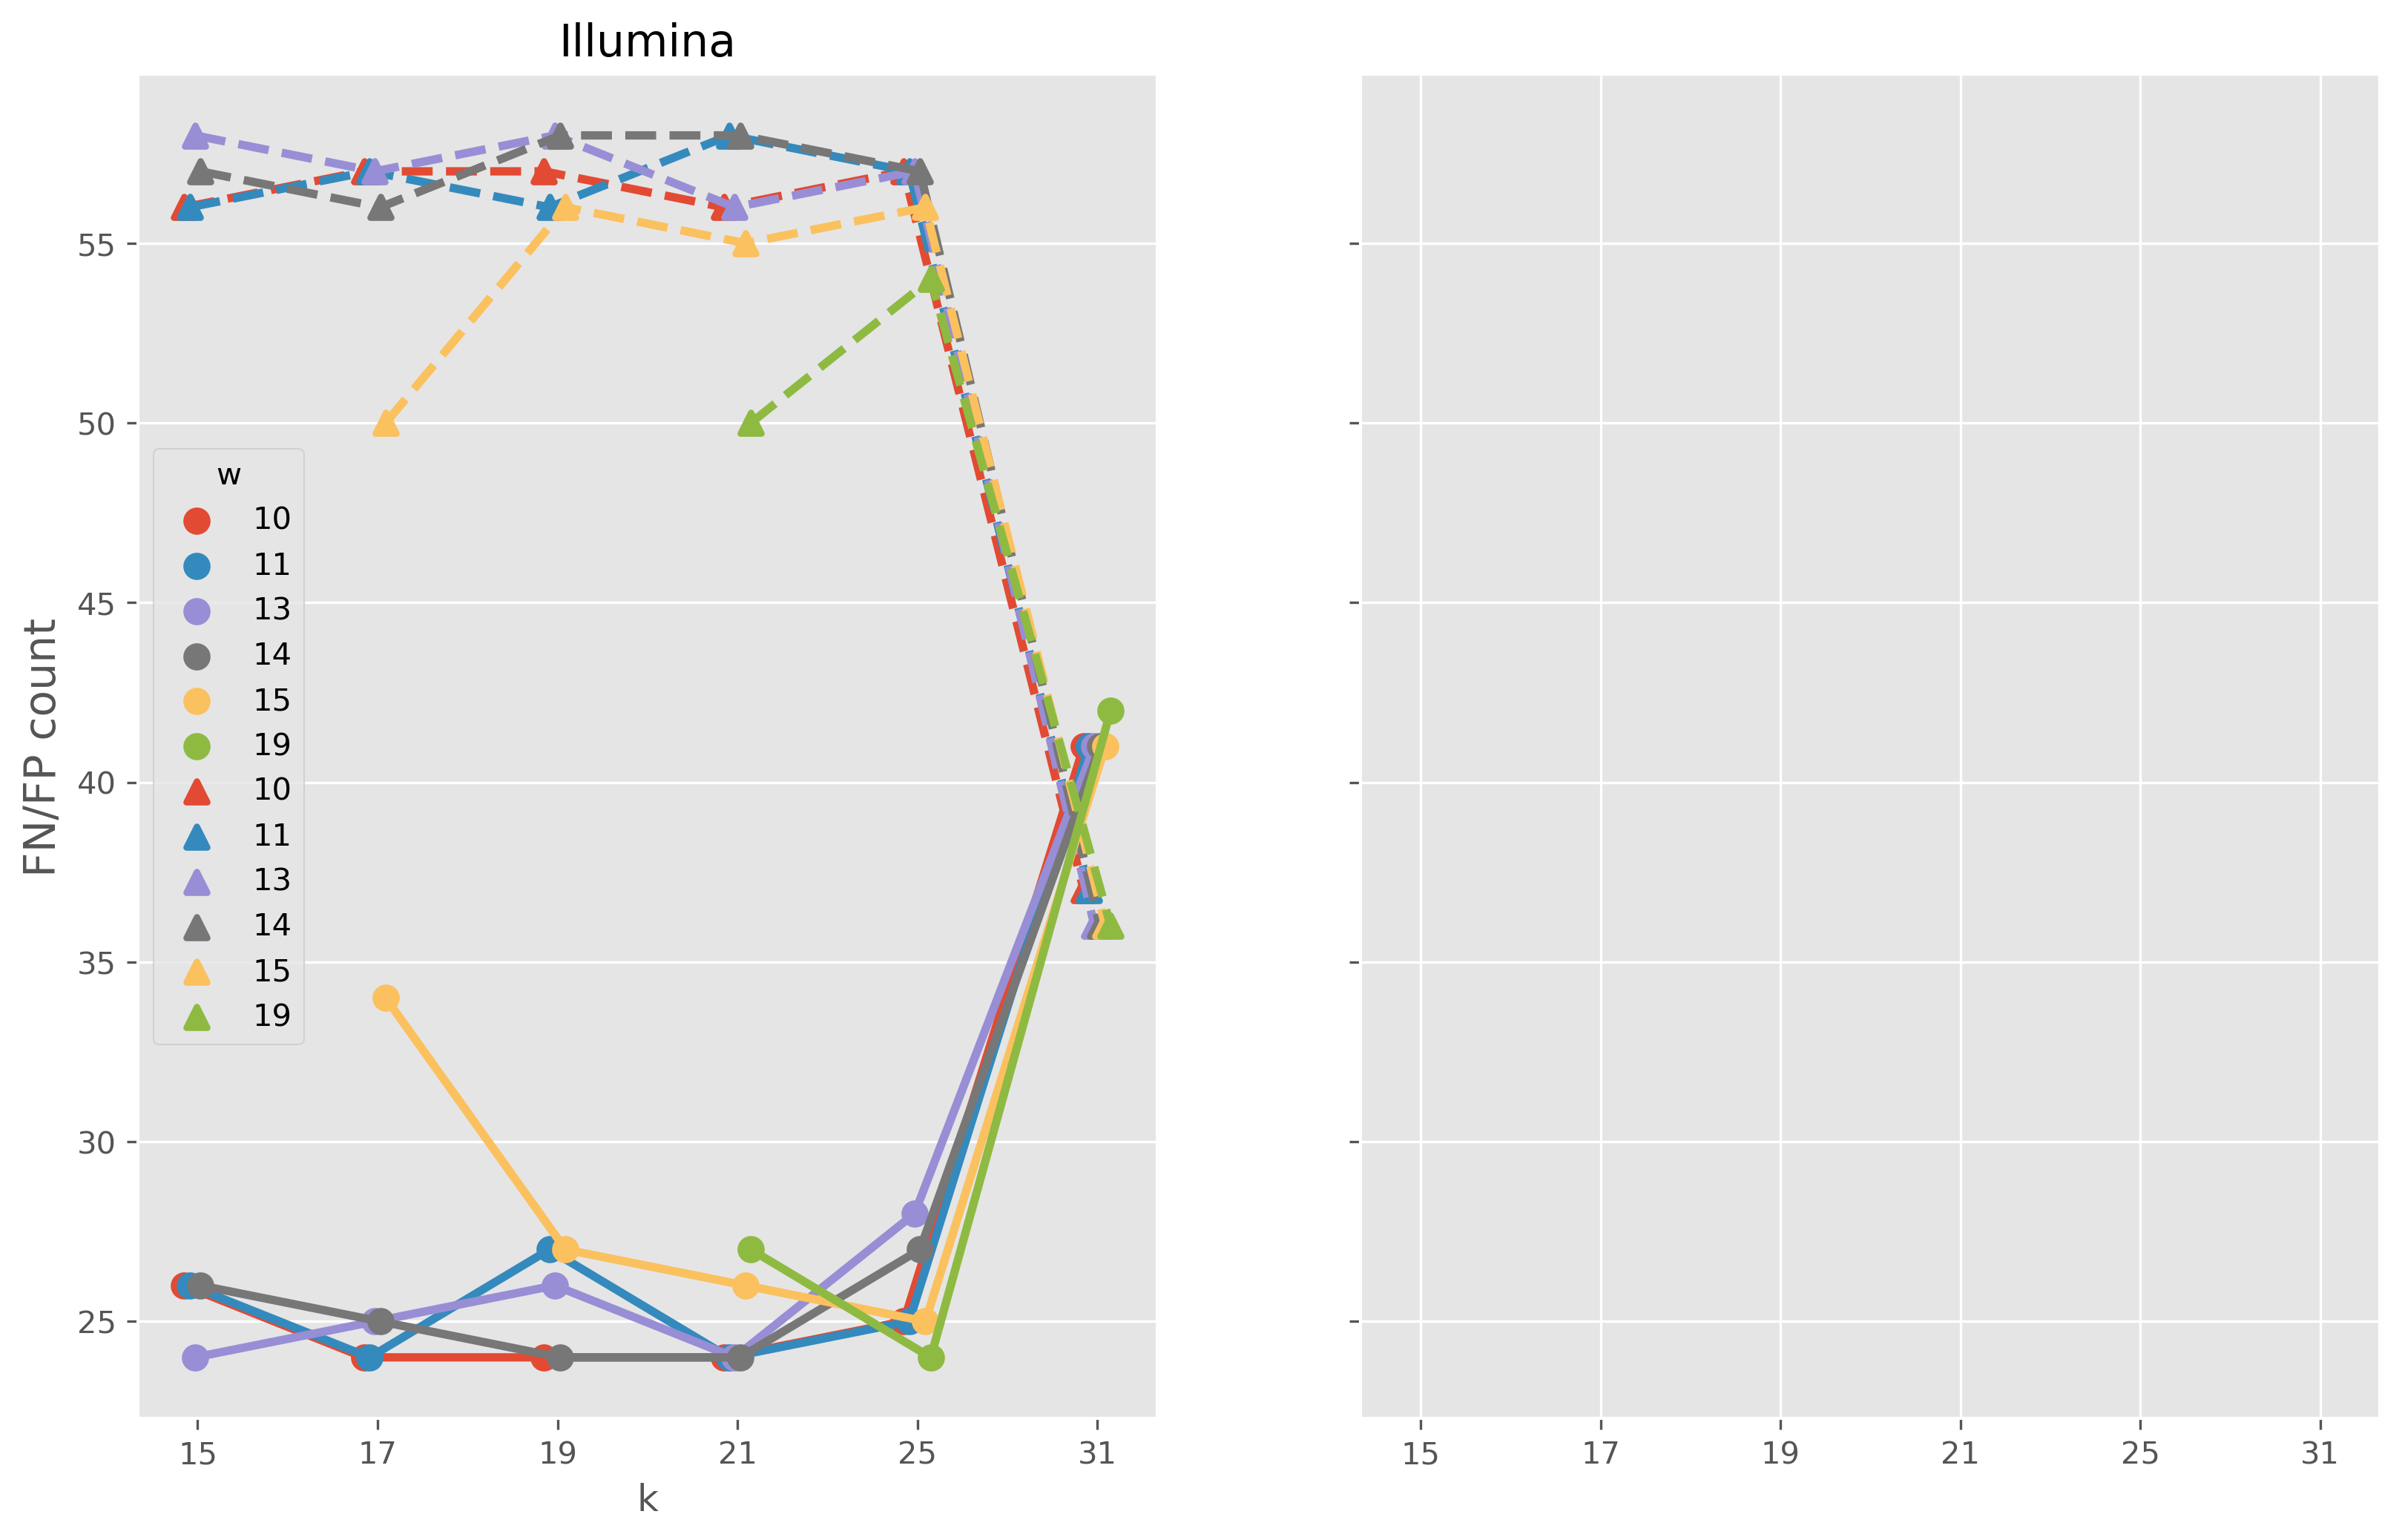

In [14]:
from matplotlib import lines, markers
x = "k"
hue = "w"
fs = 14
linestyles = list(lines.lineStyles.keys())[:len(set(data[hue]))]
markers = ["o", "^"]
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, squeeze=True)
styles = ["solid", ]

for i, tech in enumerate(techs):
    d = data.query("technology==@tech")
    ax = axes[i]
    ax.set_title(f"{tech.capitalize()}")
        
    handles = [Line2D([0],[0],color="none")]
    labels = [""]
    
    for j, y in enumerate(["FN", "FP"]):
        ls = linestyles[j]
        m = markers[j]

        sns.pointplot(
            data=d, 
            x=x, 
            y=y, 
            hue=hue, 
            ax=ax, 
            dodge=True, 
            errorbar=None, 
            linestyles=ls, 
            markers=m,
        )
 
        line = Line2D([], [], label=y, color='black', ls=ls, linewidth=2)
        point = plt.scatter([],[],s=100,facecolors='black', marker=m)
        handles.append((line, point))
        labels.append(y)
        
    if i == 0:
        ax.set_ylabel("FN/FP count", fontdict=dict(fontsize=fs))
    else:
        ax.set_ylabel("")
        
    leghandles, leglabels = ax.get_legend_handles_labels()
    leghandles = leghandles[:len(set(df[hue]))]
    leglabels = leglabels[:len(set(df[hue]))]
    leghandles.extend(handles)
    leglabels.extend(labels)
    
    ax.legend(leghandles, leglabels, loc="best", handlelength=3, fontsize=fs, title=hue, title_fontsize=fs)
    ax.tick_params(axis='both', labelsize=fs)
    ax.xaxis.label.set_size(fs)
        
plt.tight_layout()

In [43]:
data.sort_values(by=["w", "k"])

technology   w   k   TN  FP  FN   TP
6    illumina  10  15  548  52  39  136
38   nanopore  10  15  550  50  41  134
14   illumina  10  17  548  52  37  138
46   nanopore  10  17  550  50  40  135
27   illumina  10  19  548  52  37  138
..        ...  ..  ..  ...  ..  ..  ...
36   nanopore  19  21  554  46  43  132
24   illumina  19  25  550  50  37  138
56   nanopore  19  25  557  43  46  129
10   illumina  19  31  569  31  55  120
42   nanopore  19  31  571  29  60  115

[64 rows x 7 columns]

In [37]:
expr = "w==14 and k<20"
w14 = data.query(expr)

In [38]:
w14.sort_values("k")

technology   w   k   TN  FP  FN   TP
7    nanopore  14  15  527  72  49  126
28   illumina  14  15  524  75  47  128
13   nanopore  14  17  538  61  65  110
34   illumina  14  17  539  60  74  101
0    nanopore  14  19  519  80  51  124
21   illumina  14  19  517  82  43  132

In [42]:
fps = clf_df.query(expr + " and classification=='FP'")

In [43]:
fps

sample          drug classification technology   w   k
18578   mada_1-1    Ethambutol             FP   nanopore  14  15
18583   mada_1-1  Streptomycin             FP   nanopore  14  15
18586   mada_1-1    Ethambutol             FP   illumina  14  15
18591   mada_1-1  Streptomycin             FP   illumina  14  15
18623  mada_1-11  Streptomycin             FP   illumina  14  15
...          ...           ...            ...        ...  ..  ..
23055     R22601      Amikacin             FP   illumina  14  19
23076     R23887      Amikacin             FP   nanopore  14  19
23079     R23887      Amikacin             FP   illumina  14  19
23207     R36431    Rifampicin             FP   nanopore  14  19
23215     R36431    Rifampicin             FP   illumina  14  19

[430 rows x 6 columns]

In [44]:
fps.groupby(["w", "k", "drug"]).count()

sample  classification  technology
w  k  drug                                            
14 15 Amikacin           6               6           6
      Ethambutol        35              35          35
      Ethionamide        8               8           8
      Isoniazid          4               4           4
      Rifampicin         2               2           2
      Streptomycin      92              92          92
   17 Amikacin           4               4           4
      Ethambutol        36              36          36
      Ethionamide        5               5           5
      Isoniazid          5               5           5
      Rifampicin         2               2           2
      Streptomycin      69              69          69
   19 Amikacin           6               6           6
      Ethambutol        35              35          35
      Ethionamide       10              10          10
      Isoniazid          2               2           2
      Rifampicin         2               2           2
      Streptomycin     107             107         107

In [50]:
fns = clf_df.query(expr + " and classification=='FN'")
print(fns.groupby(["w", "k", "drug"])["classification"].count().to_markdown())

|                          |   classification |
|:-------------------------|-----------------:|
| (14, 15, 'Amikacin')     |                2 |
| (14, 15, 'Capreomycin')  |                2 |
| (14, 15, 'Ethambutol')   |                8 |
| (14, 15, 'Ethionamide')  |                1 |
| (14, 15, 'Isoniazid')    |               33 |
| (14, 15, 'Ofloxacin')    |               30 |
| (14, 15, 'Rifampicin')   |               16 |
| (14, 15, 'Streptomycin') |                4 |
| (14, 17, 'Amikacin')     |                2 |
| (14, 17, 'Capreomycin')  |                2 |
| (14, 17, 'Ethambutol')   |                8 |
| (14, 17, 'Ethionamide')  |                6 |
| (14, 17, 'Isoniazid')    |               30 |
| (14, 17, 'Ofloxacin')    |               30 |
| (14, 17, 'Rifampicin')   |               57 |
| (14, 17, 'Streptomycin') |                4 |
| (14, 19, 'Amikacin')     |                2 |
| (14, 19, 'Capreomycin')  |                2 |
| (14, 19, 'Ethambutol')   |            

In [15]:
# wk_results = pd.read_csv("../../results/drprg/wk_sweep/predict/wk_sweep.csv")
wk_results = data

In [16]:
wk_results

technology   w   k   TN  FP  FN   TP
0    Illumina  10  15  544  56  26  149
1    Nanopore  10  15  546  54  28  147
2    Illumina  10  17  543  57  24  151
3    Nanopore  10  17  546  54  28  147
4    Illumina  10  19  543  57  24  151
..        ...  ..  ..  ...  ..  ..  ...
59   Nanopore  19  21  549  51  31  144
60   Illumina  19  25  546  54  24  151
61   Nanopore  19  25  553  47  34  141
62   Illumina  19  31  564  36  42  133
63   Nanopore  19  31  566  34  47  128

[64 rows x 7 columns]

In [17]:
precisions = []
recalls = []
f1s = []
for _, row in wk_results.iterrows():
    cm = ConfusionMatrix.from_series(row)
    precisions.append(cm.precision())
    recalls.append(cm.sensitivity())
    f1s.append(cm.f_score(beta=1.0))

In [18]:
wk_results["precision"] = precisions
wk_results["recall"] = recalls
wk_results["f1"] = f1s

In [19]:
wk_results.query("technology=='Illumina'").sort_values(by="f1", ascending=False)

technology   w   k   TN  FP  FN   TP  precision    recall        f1
60   Illumina  19  25  546  54  24  151   0.736585  0.862857  0.794737
58   Illumina  19  21  550  50  27  148   0.747475  0.845714  0.793566
30   Illumina  13  21  544  56  24  151   0.729469  0.862857  0.790576
6    Illumina  10  21  544  56  24  151   0.729469  0.862857  0.790576
4    Illumina  10  19  543  57  24  151   0.725962  0.862857  0.788512
14   Illumina  11  17  543  57  24  151   0.725962  0.862857  0.788512
2    Illumina  10  17  543  57  24  151   0.725962  0.862857  0.788512
38   Illumina  14  17  544  56  25  150   0.728155  0.857143  0.787402
54   Illumina  15  25  544  56  25  150   0.728155  0.857143  0.787402
42   Illumina  14  21  542  58  24  151   0.722488  0.862857  0.786458
40   Illumina  14  19  542  58  24  151   0.722488  0.862857  0.786458
18   Illumina  11  21  542  58  24  151   0.722488  0.862857  0.786458
24   Illumina  13  15  542  58  24  151   0.722488  0.862857  0.786458
52   Illumina  15  21  545  55  26  149   0.730392  0.851429  0.786280
26   Illumina  13  17  543  57  25  150   0.724638  0.857143  0.785340
20   Illumina  11  25  543  57  25  150   0.724638  0.857143  0.785340
8    Illumina  10  25  543  57  25  150   0.724638  0.857143  0.785340
12   Illumina  11  15  544  56  26  149   0.726829  0.851429  0.784211
0    Illumina  10  15  544  56  26  149   0.726829  0.851429  0.784211
36   Illumina  14  15  543  57  26  149   0.723301  0.851429  0.782152
16   Illumina  11  19  544  56  27  148   0.725490  0.845714  0.781003
50   Illumina  15  19  544  56  27  148   0.725490  0.845714  0.781003
28   Illumina  13  19  542  58  26  149   0.719807  0.851429  0.780105
44   Illumina  14  25  543  57  27  148   0.721951  0.845714  0.778947
34   Illumina  13  31  564  36  41  134   0.788235  0.765714  0.776812
46   Illumina  14  31  564  36  41  134   0.788235  0.765714  0.776812
56   Illumina  15  31  564  36  41  134   0.788235  0.765714  0.776812
32   Illumina  13  25  543  57  28  147   0.720588  0.840000  0.775726
22   Illumina  11  31  563  37  41  134   0.783626  0.765714  0.774566
10   Illumina  10  31  563  37  41  134   0.783626  0.765714  0.774566
62   Illumina  19  31  564  36  42  133   0.786982  0.760000  0.773256
48   Illumina  15  17  550  50  34  141   0.738220  0.805714  0.770492

In [20]:
wk_results.query("technology=='Nanopore'").sort_values(by="f1", ascending=False)

technology   w   k   TN  FP  FN   TP  precision    recall        f1
51   Nanopore  15  19  549  51  28  147   0.742424  0.840000  0.788204
5    Nanopore  10  19  548  52  28  147   0.738693  0.840000  0.786096
29   Nanopore  13  19  549  51  29  146   0.741117  0.834286  0.784946
17   Nanopore  11  19  549  51  29  146   0.741117  0.834286  0.784946
37   Nanopore  14  15  545  55  27  148   0.729064  0.845714  0.783069
3    Nanopore  10  17  546  54  28  147   0.731343  0.840000  0.781915
1    Nanopore  10  15  546  54  28  147   0.731343  0.840000  0.781915
13   Nanopore  11  15  546  54  28  147   0.731343  0.840000  0.781915
41   Nanopore  14  19  549  51  30  145   0.739796  0.828571  0.781671
15   Nanopore  11  17  545  55  28  147   0.727723  0.840000  0.779841
25   Nanopore  13  15  545  55  28  147   0.727723  0.840000  0.779841
59   Nanopore  19  21  549  51  31  144   0.738462  0.822857  0.778378
53   Nanopore  15  21  550  50  32  143   0.740933  0.817143  0.777174
61   Nanopore  19  25  553  47  34  141   0.750000  0.805714  0.776860
43   Nanopore  14  21  548  52  31  144   0.734694  0.822857  0.776280
9    Nanopore  10  25  549  51  32  143   0.737113  0.817143  0.775068
27   Nanopore  13  17  548  52  32  143   0.733333  0.817143  0.772973
11   Nanopore  10  31  567  33  44  131   0.798780  0.748571  0.772861
23   Nanopore  11  31  567  33  44  131   0.798780  0.748571  0.772861
21   Nanopore  11  25  549  51  33  142   0.735751  0.811429  0.771739
31   Nanopore  13  21  547  53  32  143   0.729592  0.817143  0.770889
39   Nanopore  14  17  547  53  32  143   0.729592  0.817143  0.770889
49   Nanopore  15  17  548  52  33  142   0.731959  0.811429  0.769648
55   Nanopore  15  25  548  52  33  142   0.731959  0.811429  0.769648
7    Nanopore  10  21  546  54  32  143   0.725888  0.817143  0.768817
19   Nanopore  11  21  546  54  32  143   0.725888  0.817143  0.768817
47   Nanopore  14  31  567  33  46  129   0.796296  0.737143  0.765579
57   Nanopore  15  31  568  32  47  128   0.800000  0.731429  0.764179
35   Nanopore  13  31  566  34  46  129   0.791411  0.737143  0.763314
33   Nanopore  13  25  548  52  35  140   0.729167  0.800000  0.762943
45   Nanopore  14  25  548  52  35  140   0.729167  0.800000  0.762943
63   Nanopore  19  31  566  34  47  128   0.790123  0.731429  0.759644

In [54]:
from collections import Counter

In [55]:
Counter(fns.query("drug == 'Rifampicin'")["sample"])

Counter({'mada_1-11': 6,
         'mada_1-12': 6,
         'mada_1-18': 6,
         'mada_1-33': 6,
         'mada_1-37': 3,
         'mada_1-38': 2,
         'mada_1-50': 6,
         'mada_1-52': 6,
         'mada_1-53': 1,
         'mada_2-53': 2,
         'mada_1-10': 2,
         'mada_1-16': 1,
         'mada_1-2': 2,
         'mada_1-22': 2,
         'mada_1-25': 1,
         'mada_1-3': 2,
         'mada_1-31': 1,
         'mada_1-32': 2,
         'mada_1-35': 1,
         'mada_1-36': 1,
         'mada_1-40': 1,
         'mada_1-41': 1,
         'mada_1-44': 2,
         'mada_1-46': 1,
         'mada_1-47': 2,
         'mada_1-48': 2,
         'mada_1-5': 2,
         'mada_1-54': 1,
         'mada_1-6': 2,
         'mada_1-7': 2,
         'mada_2-1': 1,
         'mada_2-25': 1,
         'mada_2-31': 2,
         'mada_2-34': 2,
         'mada_2-46': 2,
         'mada_2-47': 2,
         'mada_2-50': 2,
         'mada_1-20': 1,
         'mada_1-21': 1,
         'mada_1-24': 1,
      

In [58]:
fns.query("drug == 'Rifampicin' and sample == 'mada_2-47'")

sample        drug classification technology   w   k
21344  mada_2-47  Rifampicin             FN   nanopore  14  17
21352  mada_2-47  Rifampicin             FN   illumina  14  17

# Data collation

In [4]:
datadir = Path("../../config/samplesheets/")

In [153]:
gentb = pd.read_csv("../../../../WHO-correspondence/docs/gentb-samplesheet.csv")

In [154]:
gentb.rename(columns={"run_accession": "run"}, inplace=True)

In [155]:
duplicates = set(gentb.loc[gentb.duplicated(subset="run", keep=False)].sort_values(by="run")["run"])

In [156]:
len(duplicates)

187

In [157]:
gentb.loc[gentb.duplicated(subset="run", keep=False)].sort_values(by="run").sort_values("run")

run  bioproject      biosample amikacin capreomycin  \
16251  ERR1873441  PRJEB14199  SAMEA95486668        R           S   
16250  ERR1873441  PRJEB14199  SAMEA95486668        R           S   
16243  ERR1873447  PRJEB14199  SAMEA95488918        R           R   
16244  ERR1873447  PRJEB14199  SAMEA95488918        R           R   
16239  ERR1873450  PRJEB14199  SAMEA95491168        S           R   
...           ...         ...            ...      ...         ...   
9927   ERR2516723  PRJEB26000     ERS2401401      NaN           R   
9923   ERR2516728  PRJEB26000   SAMEA3420843      NaN         NaN   
9922   ERR2516728  PRJEB26000     ERS2401406        R           R   
9914   ERR2516738  PRJEB26000   SAMEA3420853      NaN         NaN   
9913   ERR2516738  PRJEB26000     ERS2401416        S           R   

      ciprofloxacin ethambutol ethionamide isoniazid kanamycin levofloxacin  \
16251           NaN          S           S         R         R          NaN   
16250           NaN          R           S         R         R          NaN   
16243           NaN          R           S         R         R          NaN   
16244           NaN          S           S         R         R          NaN   
16239           NaN          R           R         R         S          NaN   
...             ...        ...         ...       ...       ...          ...   
9927            NaN          R           S         R         R          NaN   
9923            NaN          R         NaN         R       NaN          NaN   
9922            NaN          R           R         R         R            R   
9914            NaN          R         NaN         R       NaN          NaN   
9913            NaN          R           S         R         S            R   

      moxifloxacin ofloxacin para-aminosalicylic_acid pyrazinamide rifampicin  \
16251            S         R                        S            R          R   
16250            S         R                        S            R          R   
16243            S         S                        S            R          R   
16244            S         S                        S            R          R   
16239            S         R                        S            R          R   
...            ...       ...                      ...          ...        ...   
9927           NaN         R                        S            R          R   
9923           NaN       NaN                      NaN            R          R   
9922           NaN         R                        R            R          R   
9914           NaN       NaN                      NaN            R          R   
9913           NaN         R                        R            R          R   

      streptomycin  
16251            R  
16250            R  
16243            S  
16244            S  
16239            R  
...            ...  
9927             R  
9923           NaN  
9922             R  
9914           NaN  
9913             S  

[374 rows x 17 columns]

Some phenotypes are inconsistent between duplicate rows, set them to NaN

In [158]:
for r in duplicates:
    d = gentb.query("run==@r")
#     break
    for name, values in d.iteritems():  # column-wise iteration
        non_null = set(values.loc[~values.isna()])
        if len(non_null) > 1:
            if name == "biosample":
                all_bio = all(s.startswith("SA") for s in non_null)
                assert not all_bio, values
                v = None
                for s in non_null:
                    if s.startswith("SA"):
                        v = s
                if v is None:
                    raise ValueError(f"{name}, {values}")
            else:
                v = np.nan
            for i in values.index:
                gentb.at[i, name] = v
        elif len(non_null) == 1:
            v = list(non_null)[0]
            for i in values.index:
                gentb.at[i, name] = v

In [159]:
gentb.loc[gentb.duplicated(subset="run", keep=False)].sort_values(by="run")

run  bioproject      biosample amikacin capreomycin  \
16251  ERR1873441  PRJEB14199  SAMEA95486668        R           S   
16250  ERR1873441  PRJEB14199  SAMEA95486668        R           S   
16243  ERR1873447  PRJEB14199  SAMEA95488918        R           R   
16244  ERR1873447  PRJEB14199  SAMEA95488918        R           R   
16239  ERR1873450  PRJEB14199  SAMEA95491168        S           R   
...           ...         ...            ...      ...         ...   
9927   ERR2516723  PRJEB26000   SAMEA3420838      NaN           R   
9923   ERR2516728  PRJEB26000   SAMEA3420843        R           R   
9922   ERR2516728  PRJEB26000   SAMEA3420843        R           R   
9914   ERR2516738  PRJEB26000   SAMEA3420853        S           R   
9913   ERR2516738  PRJEB26000   SAMEA3420853        S           R   

      ciprofloxacin ethambutol ethionamide isoniazid kanamycin levofloxacin  \
16251           NaN        NaN           S         R         R          NaN   
16250           NaN        NaN           S         R         R          NaN   
16243           NaN        NaN           S         R         R          NaN   
16244           NaN        NaN           S         R         R          NaN   
16239           NaN        NaN           R         R         S          NaN   
...             ...        ...         ...       ...       ...          ...   
9927            NaN          R           S         R         R          NaN   
9923            NaN          R           R         R         R            R   
9922            NaN          R           R         R         R            R   
9914            NaN          R           S         R         S            R   
9913            NaN          R           S         R         S            R   

      moxifloxacin ofloxacin para-aminosalicylic_acid pyrazinamide rifampicin  \
16251            S         R                        S            R          R   
16250            S         R                        S            R          R   
16243            S         S                        S            R          R   
16244            S         S                        S            R          R   
16239            S         R                        S            R          R   
...            ...       ...                      ...          ...        ...   
9927           NaN         R                        S            R          R   
9923           NaN         R                        R            R          R   
9922           NaN         R                        R            R          R   
9914           NaN         R                        R            R          R   
9913           NaN         R                        R            R          R   

      streptomycin  
16251            R  
16250            R  
16243            S  
16244            S  
16239            R  
...            ...  
9927             R  
9923             R  
9922             R  
9914             S  
9913             S  

[374 rows x 17 columns]

In [160]:
gentb

run   bioproject     biosample amikacin capreomycin  \
0      SRR7439415  PRJNA413593  SAMN09492287      NaN         NaN   
1      SRR7131298  PRJNA438921  SAMN09090624      NaN         NaN   
2      SRR7131297  PRJNA438921  SAMN09090623      NaN         NaN   
3      SRR7131296  PRJNA438921  SAMN09090622      NaN         NaN   
4      SRR7131295  PRJNA438921  SAMN09090621      NaN         NaN   
...           ...          ...           ...      ...         ...   
18607   ERR025837    PRJEB2221   SAMEA961583      NaN         NaN   
18608   ERR025836    PRJEB2221   SAMEA961584      NaN         NaN   
18609   ERR025835    PRJEB2221   SAMEA961609      NaN         NaN   
18610   ERR025834    PRJEB2221   SAMEA961608      NaN         NaN   
18611   ERR025833    PRJEB2221   SAMEA961610      NaN         NaN   

      ciprofloxacin ethambutol ethionamide isoniazid kanamycin levofloxacin  \
0               NaN          S         NaN         S       NaN          NaN   
1               NaN        NaN         NaN       NaN       NaN          NaN   
2               NaN        NaN         NaN       NaN       NaN          NaN   
3               NaN        NaN         NaN       NaN       NaN          NaN   
4               NaN        NaN         NaN       NaN       NaN          NaN   
...             ...        ...         ...       ...       ...          ...   
18607           NaN          S         NaN         S       NaN          NaN   
18608           NaN          S         NaN         S       NaN          NaN   
18609           NaN          S         NaN         S       NaN          NaN   
18610           NaN          S         NaN         S       NaN          NaN   
18611           NaN          S         NaN         S       NaN          NaN   

      moxifloxacin ofloxacin para-aminosalicylic_acid pyrazinamide rifampicin  \
0              NaN       NaN                      NaN          NaN          S   
1              NaN       NaN                      NaN          NaN          S   
2              NaN       NaN                      NaN          NaN          S   
3              NaN       NaN                      NaN          NaN          S   
4              NaN       NaN                      NaN          NaN          S   
...            ...       ...                      ...          ...        ...   
18607          NaN       NaN                      NaN            S          S   
18608          NaN       NaN                      NaN            S          S   
18609          NaN       NaN                      NaN            S          S   
18610          NaN       NaN                      NaN            S          S   
18611          NaN       NaN                      NaN            S          S   

      streptomycin  
0                S  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
18607          NaN  
18608          NaN  
18609          NaN  
18610          NaN  
18611          NaN  

[18612 rows x 17 columns]

In [161]:
# remove duplicate rows now
gentb = gentb.loc[~gentb.duplicated(subset="run", keep="first")]
gentb

run   bioproject     biosample amikacin capreomycin  \
0      SRR7439415  PRJNA413593  SAMN09492287      NaN         NaN   
1      SRR7131298  PRJNA438921  SAMN09090624      NaN         NaN   
2      SRR7131297  PRJNA438921  SAMN09090623      NaN         NaN   
3      SRR7131296  PRJNA438921  SAMN09090622      NaN         NaN   
4      SRR7131295  PRJNA438921  SAMN09090621      NaN         NaN   
...           ...          ...           ...      ...         ...   
18607   ERR025837    PRJEB2221   SAMEA961583      NaN         NaN   
18608   ERR025836    PRJEB2221   SAMEA961584      NaN         NaN   
18609   ERR025835    PRJEB2221   SAMEA961609      NaN         NaN   
18610   ERR025834    PRJEB2221   SAMEA961608      NaN         NaN   
18611   ERR025833    PRJEB2221   SAMEA961610      NaN         NaN   

      ciprofloxacin ethambutol ethionamide isoniazid kanamycin levofloxacin  \
0               NaN          S         NaN         S       NaN          NaN   
1               NaN        NaN         NaN       NaN       NaN          NaN   
2               NaN        NaN         NaN       NaN       NaN          NaN   
3               NaN        NaN         NaN       NaN       NaN          NaN   
4               NaN        NaN         NaN       NaN       NaN          NaN   
...             ...        ...         ...       ...       ...          ...   
18607           NaN          S         NaN         S       NaN          NaN   
18608           NaN          S         NaN         S       NaN          NaN   
18609           NaN          S         NaN         S       NaN          NaN   
18610           NaN          S         NaN         S       NaN          NaN   
18611           NaN          S         NaN         S       NaN          NaN   

      moxifloxacin ofloxacin para-aminosalicylic_acid pyrazinamide rifampicin  \
0              NaN       NaN                      NaN          NaN          S   
1              NaN       NaN                      NaN          NaN          S   
2              NaN       NaN                      NaN          NaN          S   
3              NaN       NaN                      NaN          NaN          S   
4              NaN       NaN                      NaN          NaN          S   
...            ...       ...                      ...          ...        ...   
18607          NaN       NaN                      NaN            S          S   
18608          NaN       NaN                      NaN            S          S   
18609          NaN       NaN                      NaN            S          S   
18610          NaN       NaN                      NaN            S          S   
18611          NaN       NaN                      NaN            S          S   

      streptomycin  
0                S  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
18607          NaN  
18608          NaN  
18609          NaN  
18610          NaN  
18611          NaN  

[18425 rows x 17 columns]

In [162]:
gentb.set_index(["run"], inplace=True, verify_integrity=True)

In [163]:
# gentb.to_csv("gentb.csv")

Now do the same for the WHO samplesheet

In [386]:
who = pd.read_csv(datadir / "who.csv", low_memory=False)

In [388]:
# any missing runs?
sum(who["run"].isna())

0

In [332]:
# remove any rows with no run accession
who.drop(who.loc[who["run"].isna()].index, inplace=True)

In [389]:
sum(who["biosample"].isna())

22192

In [390]:
missing_biosamples = who.loc[who["biosample"].isna()]
missing_samples = missing_biosamples.loc[missing_biosamples["sample"].isna()]

In [391]:
len(missing_samples)

0

How many of the missing samples exist in gentb?

In [392]:
set(gentb.index).intersection(missing_samples["run"])

set()

In [393]:
missing_bioproject = who.loc[who["bioproject"].isna()]
missing_study = missing_bioproject.loc[missing_bioproject["study"].isna()]

In [394]:
len(missing_study)

0

In [339]:
missing_data = missing_samples.combine_first(missing_study)
len(missing_data)

154

How many of the missing study exist in gentb?

In [340]:
in_gentb = set(gentb.index).intersection(set(missing_data["run"]))
len(in_gentb)

0

In [341]:
in_gentb

set()

Fill in WHO missing data from gentb

In [342]:
# for ix, row in missing_data.iterrows():
#     if row["run"] in in_gentb:
#         for k in ["bioproject", "biosample"]:
#             val = gentb.at[row["run"], k]
#             who.at[ix, k] = val

In [343]:
# who.to_csv("who.csv")

Fetch missing metadata using code from https://github.com/mbhall88/WHO-correspondence/blob/main/docs/fill_in_who_samplesheet.py

In [2]:
from dataclasses import dataclass
from typing import Union
from enum import Enum
import re
from pysradb.search import EnaSearch, SraSearch
from requests.exceptions import RetryError

ENA_KEEP_METADATA = [
    "study_accession",
    "sample_accession",
    "run_accession",
    "experiment_accession",
]
SRA_KEEP_METADATA = [
    "study_accession",
    "sample_accession",
    "run_1_accession",
    "experiment_accession",
]


class AccessionType(Enum):
    BIOPROJECT = re.compile(r"PRJ([EDN])[A-Z]\d+")
    STUDY = re.compile(r"([EDS])RP\d{6,}")
    BIOSAMPLE = re.compile(r"SAM([EDN])[A-Z]?\d+")
    SAMPLE = re.compile(r"([EDS])RS\d{6,}")
    EXPERIMENT = re.compile(r"([EDS])RX\d{6,}")
    RUN = re.compile(r"([EDS])RR\d{6,}")

    @staticmethod
    def from_str(s: str) -> "AccessionType":
        for member in AccessionType:
            regex = member.value
            if regex.search(s):
                return member
        raise ValueError(f"{s} does not match a known type")

@dataclass
class Accession:
    run: str = ""
    sample: str = ""
    biosample: str = ""
    experiment: str = ""
    bioproject: str = ""
    study: str = ""

    @staticmethod
    def from_line(s: str, delim: str = ",") -> "Accession":
        acc = Accession()
        fields = [f for f in s.rstrip().split(delim) if f]
        for f in map(str.strip, fields):
            acc_type = AccessionType.from_str(f)
            if acc_type is AccessionType.BIOSAMPLE:
                acc.biosample = f
            elif acc_type is AccessionType.RUN:
                acc.run = f
            elif acc_type is AccessionType.EXPERIMENT:
                acc.experiment = f
            elif acc_type is AccessionType.SAMPLE:
                acc.sample = f
            elif acc_type is AccessionType.STUDY:
                acc.study = f
            elif acc_type is AccessionType.BIOPROJECT:
                acc.bioproject = f
            else:
                raise NotImplementedError(
                    f"Don't know how to deal with AccessionType {acc_type}"
                )

        return acc

    def most_specific(self) -> Union[tuple[str, AccessionType], tuple[str, None]]:
        """Returns the most specific accession"""
        if self.run:
            return self.run, AccessionType.RUN
        elif self.experiment:
            return self.experiment, AccessionType.EXPERIMENT
        elif self.biosample:
            return self.biosample, AccessionType.BIOSAMPLE
        elif self.sample:
            return self.sample, AccessionType.SAMPLE
        elif self.bioproject:
            return self.bioproject, AccessionType.BIOPROJECT
        elif self.study:
            return self.study, AccessionType.STUDY
        else:
            return "", None

    def to_row(self, delim: str = ",") -> str:
        return delim.join(
            [
                self.bioproject,
                self.study,
                self.biosample,
                self.sample,
                self.experiment,
                self.run,
            ]
        )

def fetch_metadata(query: str):
    instance = EnaSearch(verbosity=2, accession=query)
    instance.search()
    df = instance.get_df()
    if df.empty:
        instance = SraSearch(verbosity=2, accession=query)
        instance.search()
        df = instance.get_df()
        if df.empty:
            return None
        keep = SRA_KEEP_METADATA
    else:
        keep = ENA_KEEP_METADATA
    return df.loc[:, keep]

/usr/local/Caskroom/miniconda/base/envs/drprg/lib/python3.10/site-packages/pysradb/utils.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [287]:
# seen_runs = set()
# rows_with_multiple_runs = 0

# for i, (ix, row) in enumerate(missing_data.iterrows()):
#     print(f"{i}/{len(missing_data)}")
#     if len(row["run"]) > 20:
#         rows_with_multiple_runs += 1
#         continue
#     accessions = ",".join([a for a in row[["run", "sample", "biosample", "experiment", "bioproject", "study"]] if not pd.isna(a)])
#     acc = Accession.from_line(accessions.replace("FAIL", ""))
#     query, acc_type = acc.most_specific()
#     assert acc_type is AccessionType.RUN, row

#     try:
#         metadata = fetch_metadata(query)
#     except RetryError:
#         print(
#             f"Exceeded maximum retries when fetching metadata for {query}...line is below"
#         )
#         print(line)
#         continue

#     if metadata is not None and not metadata.empty:
#         assert len(metadata.values) == 1, row
#         for row in metadata.values:
#             new_acc = Accession.from_line(",".join(row))
#             if new_acc.run:
#                 if new_acc.run in seen_runs:
#                     raise ValueError(f"Duplicate: {row}")
#                 else:
#                     seen_runs.add(new_acc.run)
#             if new_acc.bioproject:
#                 who.at[ix, "bioproject"] = new_acc.bioproject
#             if new_acc.study:
#                 who.at[ix, "study"] = new_acc.study
#             if new_acc.biosample:
#                 who.at[ix, "biosample"] = new_acc.biosample
#             if new_acc.sample:
#                 who.at[ix, "sample"] = new_acc.sample
#             if new_acc.experiment:
#                 who.at[ix, "experiment"] = new_acc.experiment
#     else:
#         print(f"Couldn't get metadata for {row}")
#         continue

#     who.to_csv("who.csv", index=False)
    
# print(f"{rows_with_multiple_runs} rows with multiple runs")

0/766
1/766
2/766
3/766
4/766
5/766
6/766
7/766
8/766
9/766
10/766
11/766
12/766
13/766
14/766
15/766
16/766
17/766
18/766
19/766
20/766
21/766
22/766
23/766
24/766
25/766
26/766
27/766
28/766
29/766
30/766
31/766
32/766
33/766
34/766
35/766
36/766
37/766
38/766
39/766
40/766
41/766
42/766
43/766
44/766
45/766
46/766
47/766
48/766
49/766
50/766
51/766
52/766
53/766
54/766
55/766
56/766
57/766
58/766
59/766
60/766
61/766
62/766
63/766
64/766
65/766
66/766
67/766
68/766
69/766
70/766
71/766
72/766
73/766
74/766
75/766
76/766
77/766
78/766
79/766
80/766
81/766
82/766
83/766
84/766
85/766
86/766
87/766
88/766
89/766
90/766
91/766
92/766
93/766
94/766
95/766
96/766
97/766
98/766
99/766
100/766
101/766
102/766
103/766
104/766
105/766
106/766
107/766
108/766
109/766
110/766
111/766
112/766
113/766
114/766
115/766
116/766
117/766
118/766
119/766
120/766
121/766
122/766
123/766
124/766
125/766
126/766
127/766
128/766
129/766
130/766
131/766
132/766
133/766
134/766
135/766
136/766
137/766
138/76

No results found for the following search query: 
 {'query': None, 'accession': 'ERR551194 ERR551195', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
No results found for the following search query: 
 {'query': None, 'accession': 'ERR551194 ERR551195', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
Couldn't get metadata for Unnamed: 0.1                  28292
Unnamed: 0                    28293
bioproject                      NaN
study                           NaN
biosample              SAMEA2533766
sample                          NaN
experiment                      NaN
run             ERR551194 ERR551195
amikacin                          S
bedaquiline                     NaN
capreomycin                     NaN
clofazimine                     NaN
delamanid   

No results found for the following search query: 
 {'query': None, 'accession': 'ERR551881 ERR551882', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
No results found for the following search query: 
 {'query': None, 'accession': 'ERR551881 ERR551882', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
Couldn't get metadata for Unnamed: 0.1                  28715
Unnamed: 0                    28716
bioproject                      NaN
study                           NaN
biosample              SAMEA2534263
sample                          NaN
experiment                      NaN
run             ERR551881 ERR551882
amikacin                        NaN
bedaquiline                     NaN
capreomycin                     NaN
clofazimine                     NaN
delamanid   

No results found for the following search query: 
 {'query': None, 'accession': 'ERR552181 ERR552182', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
No results found for the following search query: 
 {'query': None, 'accession': 'ERR552181 ERR552182', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
Couldn't get metadata for Unnamed: 0.1                  28896
Unnamed: 0                    28897
bioproject                      NaN
study                           NaN
biosample              SAMEA2534468
sample                          NaN
experiment                      NaN
run             ERR552181 ERR552182
amikacin                          S
bedaquiline                     NaN
capreomycin                     NaN
clofazimine                     NaN
delamanid   

No results found for the following search query: 
 {'query': None, 'accession': 'ERR552572 ERR552573', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
No results found for the following search query: 
 {'query': None, 'accession': 'ERR552572 ERR552573', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
Couldn't get metadata for Unnamed: 0.1                  29114
Unnamed: 0                    29115
bioproject                      NaN
study                           NaN
biosample              SAMEA2534740
sample                          NaN
experiment                      NaN
run             ERR552572 ERR552573
amikacin                          S
bedaquiline                     NaN
capreomycin                     NaN
clofazimine                     NaN
delamanid   

No results found for the following search query: 
 {'query': None, 'accession': 'ERR552993 ERR552994', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
No results found for the following search query: 
 {'query': None, 'accession': 'ERR552993 ERR552994', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
Couldn't get metadata for Unnamed: 0.1                  29364
Unnamed: 0                    29365
bioproject                      NaN
study                           NaN
biosample              SAMEA2535054
sample                          NaN
experiment                      NaN
run             ERR552993 ERR552994
amikacin                          S
bedaquiline                     NaN
capreomycin                     NaN
clofazimine                     NaN
delamanid   

No results found for the following search query: 
 {'query': None, 'accession': 'ERR553342 ERR553343', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
No results found for the following search query: 
 {'query': None, 'accession': 'ERR553342 ERR553343', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': None, 'platform': None, 'selection': None, 'source': None, 'strategy': None, 'title': None}
Couldn't get metadata for Unnamed: 0.1                  29540
Unnamed: 0                    29541
bioproject                      NaN
study                           NaN
biosample              SAMEA2535320
sample                          NaN
experiment                      NaN
run             ERR553342 ERR553343
amikacin                          S
bedaquiline                     NaN
capreomycin                     NaN
clofazimine                     NaN
delamanid   

In [345]:
# how many rows have multiple runs
print(len(missing_data))
c = 0
for r in missing_data["run"]:
    l = len(AccessionType.RUN.value.findall(r))
    if l > 1:
        c += 1
print(c)

154
154


In [357]:
all_runs = set(who["run"])
new_rows = []
idx_to_drop = []
for i, (ix, row) in enumerate(missing_data.iterrows()):
    print(f"{i}/{len(missing_data)}")
    runs = row["run"].strip().split()
    
    for r in runs:
        accessions = ",".join([a for a in [r, row["biosample"], row["sample"], row["bioproject"], row["study"], row["experiment"]] if not pd.isna(a)])
        acc = Accession.from_line(accessions.replace("FAIL", ""))
        query, acc_type = acc.most_specific()
        assert acc_type is AccessionType.RUN, ix
        
        try:
            metadata = fetch_metadata(query)
            if metadata is not None and not metadata.empty:
                break
            else:
                continue
        except RetryError:
            continue
        raise ValueError(
            f"Couldn't fetch metadata for {ix}"
        )


    assert len(metadata.values) == 1, ix
    new_acc = Accession.from_line(",".join(metadata.values[0]))
    for r in runs:
        row_cp = row.copy(deep=True)
        if r in all_runs:
            raise ValueError(f"Duplicate: {r} Index: {ix}")
        else:
            all_runs.add(new_acc.run)
        row_cp["run"] = r
        if new_acc.bioproject:
            row_cp["bioproject"] = new_acc.bioproject
        if new_acc.study:
            row_cp["study"] = new_acc.study
        if new_acc.biosample:
            row_cp["biosample"] = new_acc.biosample
        if new_acc.sample:
            row_cp["sample"] = new_acc.sample
        if new_acc.experiment:
            row_cp["experiment"] = new_acc.experiment
            
        new_rows.append(row_cp)

0/154
1/154
2/154
3/154
4/154
5/154
6/154
7/154
8/154
9/154
10/154
11/154
12/154
13/154
14/154
15/154
16/154
17/154
18/154
19/154
20/154
21/154
22/154
23/154
24/154
25/154
26/154
27/154
28/154
29/154
30/154
31/154
32/154
33/154
34/154
35/154
36/154
37/154
38/154
39/154
40/154
41/154
42/154
43/154
44/154
45/154
46/154
47/154
48/154
49/154
50/154
51/154
52/154
53/154
54/154
55/154
56/154
57/154
58/154
59/154
60/154
61/154
62/154
63/154
64/154
65/154
66/154
67/154
68/154
69/154
70/154
71/154
72/154
73/154
74/154
75/154
76/154
77/154
78/154
79/154
80/154
81/154
82/154
83/154
84/154
85/154
86/154
87/154
88/154
89/154
90/154
91/154
92/154
93/154
94/154
95/154
96/154
97/154
98/154
99/154
100/154
101/154
102/154
103/154
104/154
105/154
106/154
107/154
108/154
109/154
110/154
111/154
112/154
113/154
114/154
115/154
116/154
117/154
118/154
119/154
120/154
121/154
122/154
123/154
124/154
125/154
126/154
127/154
128/154
129/154
130/154
131/154
132/154
133/154
134/154
135/154
136/154
137/154
138/15

In [365]:
new_df = pd.concat(new_rows, axis=1).T.reset_index(drop=True)

In [366]:
idx_to_drop

[]

In [376]:
who.drop(missing_data.index, inplace=True)

In [377]:
new_df

bioproject study     biosample sample experiment         run amikacin  \
0    PRJNA229230   NaN  SAMN02414865    NaN  SRX465910  SRR1162845      NaN   
1    PRJNA229242   NaN  SAMN02414877    NaN  SRX465931  SRR1166922      NaN   
2    PRJNA229242   NaN  SAMN02414877    NaN  SRX465931  SRR1165512      NaN   
3    PRJNA229242   NaN  SAMN02414877    NaN  SRX465931  SRR1162828      NaN   
4    PRJNA229242   NaN  SAMN02414877    NaN  SRX465931  SRR1165592      NaN   
..           ...   ...           ...    ...        ...         ...      ...   
450    PRJEB6273   NaN  SAMEA2535217    NaN  ERX512283   ERR553215      NaN   
451    PRJEB6273   NaN  SAMEA2535320    NaN  ERX512411   ERR553342        S   
452    PRJEB6273   NaN  SAMEA2535320    NaN  ERX512411   ERR553343        S   
453    PRJEB6273   NaN  SAMEA2535354    NaN  ERX512453   ERR553384      NaN   
454    PRJEB6273   NaN  SAMEA2535354    NaN  ERX512453   ERR553385      NaN   

    bedaquiline capreomycin clofazimine  ... ethionamide ethambutol isoniazid  \
0           NaN         NaN         NaN  ...         NaN        NaN         R   
1           NaN         NaN         NaN  ...         NaN        NaN         R   
2           NaN         NaN         NaN  ...         NaN        NaN         R   
3           NaN         NaN         NaN  ...         NaN        NaN         R   
4           NaN         NaN         NaN  ...         NaN        NaN         R   
..          ...         ...         ...  ...         ...        ...       ...   
450         NaN         NaN         NaN  ...         NaN          S         S   
451         NaN         NaN         NaN  ...         NaN          R         R   
452         NaN         NaN         NaN  ...         NaN          R         R   
453         NaN         NaN         NaN  ...         NaN          S         S   
454         NaN         NaN         NaN  ...         NaN          S         S   

    kanamycin levofloxacin linezolid moxifloxacin pyrazinamide rifampicin  \
0         NaN          NaN       NaN          NaN            S          R   
1         NaN          NaN       NaN          NaN            R          R   
2         NaN          NaN       NaN          NaN            R          R   
3         NaN          NaN       NaN          NaN            R          R   
4         NaN          NaN       NaN          NaN            R          R   
..        ...          ...       ...          ...          ...        ...   
450       NaN          NaN       NaN          NaN            S          S   
451       NaN            S       NaN          NaN          NaN          R   
452       NaN            S       NaN          NaN          NaN          R   
453       NaN          NaN       NaN          NaN            S          S   
454       NaN          NaN       NaN          NaN            S          S   

    streptomycin  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
450            S  
451            R  
452            R  
453            S  
454            S  

[455 rows x 21 columns]

In [378]:
in_who = set(who.run).intersection(set(new_df["run"]))
len(in_who)

0

In [383]:
who = pd.concat([who, new_df]).set_index("run", verify_integrity=True)

In [385]:
# who.to_csv("who.csv")

## Merge dataframes
What we do here is merge the WHO dataset with the GenTB dataset and change the phenotype to NaN (i.e. None) if the two phenotypes listed in the two datasets disagree. In addition, if one dataset has an empty value we use the other if it is non-empty.

In [20]:
def comp(c1, c2):
    if pd.isna(c1):
        return c2
    elif pd.isna(c2):
        return c1
    elif c1 != c2:
        return np.nan
    else:
        return c1
    
combine_func = lambda s1, s2: np.array([comp(c1, c2) for c1, c2 in zip(s1,s2)])

In [397]:
who.set_index("run", inplace=True, verify_integrity=True)

In [398]:
gentb.set_index("run", inplace=True, verify_integrity=True)

KeyError: "None of ['run'] are in the columns"

In [399]:
len(who)

36261

In [400]:
len(gentb)

18425

In [401]:
samplesheet = who.combine(gentb, func=combine_func, overwrite=False)
len(samplesheet)

41088

In [402]:
len(who)+len(gentb)

54686

In [406]:
pd.isna(samplesheet.at['ERR025833', "capreomycin"])

False

In [457]:
# samplesheet.to_csv("samplesheet.csv")

In [4]:
samplesheet = pd.read_csv("../../config/illumina.samplesheet.csv", low_memory=False, index_col="run")

drop rows with no phenotypes

In [23]:
drugs = set(samplesheet.columns)-{"bioproject", "biosample"}

In [24]:
len(samplesheet.dropna(subset=drugs, how='all')) == len(samplesheet)

False

In [25]:
len(samplesheet)

46044

In [26]:
samplesheet.dropna(subset=drugs, how='all', inplace=True)

In [27]:
len(samplesheet)

45939

So all isolates have phenotypes for at least one drug

Are there any drugs with no phenotypes in the dataset?

In [19]:
for d in drugs:
    print(d, samplesheet[d].isna().all())

ofloxacin False
clofazimine False
levofloxacin False
amikacin False
cycloserine False
pyrazinamide False
gatifloxacin False
isoniazid False
rifampicin False
capreomycin False
linezolid False
delamanid False
streptomycin False
kanamycin False
ciprofloxacin False
ethambutol False
bedaquiline False
ethionamide False
para-aminosalicylic_acid False
moxifloxacin False
thioacetazone False


So every drug has a phenotype in at least one sample

Add data from https://doi.org/10.1080/22221751.2022.2099304

In [24]:
trisakil = pd.read_csv(datadir / "trisakul.csv", na_values="ND")
trisakil.drop(columns=["aminoglycosides", "fluoroquinolones"], inplace=True)
trisakil.set_index("accession", inplace=True, verify_integrity=True)
trisakil

rifampicin isoniazid pyrazinamide ethambutol streptomycin  \
accession                                                              
SRR1180359        NaN       NaN          NaN        NaN          NaN   
SRR1180415        NaN       NaN          NaN        NaN          NaN   
ERR688042           R         R            R          R            R   
ERR1034588          R         R            R          S            S   
ERR1034610          R         R            R          R            S   
...               ...       ...          ...        ...          ...   
ERR117453         NaN       NaN          NaN        NaN          NaN   
ERR067761         NaN       NaN          NaN        NaN          NaN   
ERR144600         NaN       NaN          NaN        NaN          NaN   
ERR234622         NaN       NaN          NaN        NaN          NaN   
ERR067762         NaN       NaN          NaN        NaN          NaN   

           moxifloxacin ofloxacin levofloxacin ciprofloxacin amikacin  \
accession                                                               
SRR1180359          NaN       NaN          NaN           NaN      NaN   
SRR1180415          NaN       NaN          NaN           NaN      NaN   
ERR688042           NaN       NaN          NaN           NaN        R   
ERR1034588          NaN       NaN          NaN             R        R   
ERR1034610          NaN       NaN          NaN             R        R   
...                 ...       ...          ...           ...      ...   
ERR117453           NaN       NaN          NaN           NaN      NaN   
ERR067761           NaN       NaN          NaN           NaN      NaN   
ERR144600           NaN       NaN          NaN           NaN      NaN   
ERR234622           NaN       NaN          NaN           NaN      NaN   
ERR067762           NaN       NaN          NaN           NaN      NaN   

           kanamycin capreomycin ethionamide para-aminosalicylic_acid  \
accession                                                               
SRR1180359       NaN         NaN         NaN                      NaN   
SRR1180415       NaN         NaN         NaN                      NaN   
ERR688042          R         NaN         NaN                      NaN   
ERR1034588         R           S           S                      NaN   
ERR1034610         R           S           S                      NaN   
...              ...         ...         ...                      ...   
ERR117453        NaN         NaN         NaN                      NaN   
ERR067761        NaN         NaN         NaN                      NaN   
ERR144600        NaN         NaN         NaN                      NaN   
ERR234622        NaN         NaN         NaN                      NaN   
ERR067762        NaN         NaN         NaN                      NaN   

           cycloserine  
accession               
SRR1180359         NaN  
SRR1180415         NaN  
ERR688042          NaN  
ERR1034588         NaN  
ERR1034610         NaN  
...                ...  
ERR117453          NaN  
ERR067761          NaN  
ERR144600          NaN  
ERR234622          NaN  
ERR067762          NaN  

[513 rows x 15 columns]

In [38]:
trisakil_drugs = trisakil.columns
trisakil_drugs

Index(['rifampicin', 'isoniazid', 'pyrazinamide', 'ethambutol', 'streptomycin',
       'moxifloxacin', 'ofloxacin', 'levofloxacin', 'ciprofloxacin',
       'amikacin', 'kanamycin', 'capreomycin', 'ethionamide',
       'para-aminosalicylic_acid', 'cycloserine'],
      dtype='object')

In [39]:
completed_queries = set()
unsuccessful_queries = set()
rows = []

In [40]:
for i, (ix, row) in enumerate(trisakil.iterrows()):
    
    try:
        acc = Accession.from_line(ix.strip())
    except ValueError:
        print(f"[WARN]: Couldn't parse accession {ix}, skipping...")
        continue
    query, acc_type = acc.most_specific()
    
    if query in samplesheet.index:
        continue
        
    if query in completed_queries:
        print(f"[WARN]: {query} is present multiple times. skipping...")
        continue

    try:
        metadata = fetch_metadata(query)
    except:
        print(f"[WARN]: {query} failed")
        unsuccessful_queries.add(query)
        continue

    for _, query_row in metadata.iterrows():
        
        new_acc = Accession.from_line(",".join(query_row.values))
        new_row = [new_acc]
        for d in trisakil_drugs:
            pred = row[d]
            if pd.isna(pred):
                pred = None
            else:
                pred = pred.upper()

            new_row.append(pred)

        rows.append(new_row)
    completed_queries.add(query)
    print(f"[SUCCESS]: {i}/{len(trisakil)} - {query}")

[SUCCESS]: 0/513 - SRR1180359
[SUCCESS]: 1/513 - SRR1180415
[SUCCESS]: 2/513 - ERR688042
[SUCCESS]: 3/513 - ERR1034588
[SUCCESS]: 4/513 - ERR1034610
[SUCCESS]: 5/513 - ERR688020
[SUCCESS]: 6/513 - ERR1034606
[SUCCESS]: 7/513 - ERR688038
[SUCCESS]: 8/513 - ERR1034592
[SUCCESS]: 9/513 - ERR688024
[SUCCESS]: 10/513 - ERR688039
[SUCCESS]: 11/513 - ERR1034607
[SUCCESS]: 12/513 - SRR1180970
[SUCCESS]: 13/513 - SRR6848320
[SUCCESS]: 14/513 - SRR6848323
[SUCCESS]: 19/513 - SRR1172239
[SUCCESS]: 20/513 - SRR1172313
[SUCCESS]: 25/513 - ERR1034789
[SUCCESS]: 27/513 - SRR6848321
[SUCCESS]: 36/513 - SRR924218
[SUCCESS]: 37/513 - ERR1034603
[SUCCESS]: 38/513 - ERR688035
[SUCCESS]: 41/513 - SRR1175354
[SUCCESS]: 42/513 - SRR1173038
[SUCCESS]: 43/513 - SRR1184360
[SUCCESS]: 44/513 - SRR1196586
[SUCCESS]: 45/513 - SRR1173422
[SUCCESS]: 46/513 - ERR2433008
[SUCCESS]: 47/513 - SRR1062837
[SUCCESS]: 48/513 - SRR924217
[SUCCESS]: 49/513 - SRR1062841
[SUCCESS]: 50/513 - SRR1172836
[SUCCESS]: 51/513 - SRR117

[SUCCESS]: 404/513 - ERR867523
[SUCCESS]: 405/513 - ERR867533
[SUCCESS]: 406/513 - SRR1172073
[SUCCESS]: 407/513 - SRR1172230
[SUCCESS]: 408/513 - SRR1169119
[SUCCESS]: 413/513 - SRR1169096
[SUCCESS]: 414/513 - SRR1169116
[SUCCESS]: 419/513 - SRR1184040
[SUCCESS]: 420/513 - SRR1169108
[SUCCESS]: 422/513 - SRR1181132
[SUCCESS]: 423/513 - SRR1169073
[SUCCESS]: 424/513 - SRR1181278
[SUCCESS]: 425/513 - SRR1172291
[SUCCESS]: 426/513 - SRR1180989
[SUCCESS]: 427/513 - SRR1181208
[SUCCESS]: 428/513 - SRR1169128
[SUCCESS]: 429/513 - SRR1180957
[SUCCESS]: 430/513 - SRR1169086
[SUCCESS]: 431/513 - SRR1181134
[SUCCESS]: 432/513 - SRR1169142
[SUCCESS]: 433/513 - SRR1184123
[SUCCESS]: 434/513 - SRR1183663
[SUCCESS]: 435/513 - SRR1184035
[SUCCESS]: 436/513 - SRR1180936
[SUCCESS]: 437/513 - SRR1169121
[SUCCESS]: 438/513 - SRR1172072
[SUCCESS]: 439/513 - SRR1172201
[SUCCESS]: 440/513 - SRR1181025
[SUCCESS]: 441/513 - SRR1181103
[SUCCESS]: 442/513 - SRR1180963
[SUCCESS]: 443/513 - SRR1168958
[SUCCESS]:

In [41]:
triskal_data = []
for row in rows:
    acc = row[0]
    proj = acc.bioproject
    sample = acc.biosample
    run = acc.run
    if run in samplesheet.index:
        continue
    if all(pd.isna(p) for p in row[1:]):
        continue
    triskal_data.append((proj, sample, run, *[None if p == "I" else p for p in row[1:]]))

In [42]:
trisakil_df = pd.DataFrame(triskal_data, columns=["bioproject", "biosample", "run", *trisakil_drugs])
trisakil_df.set_index("run", verify_integrity=True, inplace=True)

In [43]:
trisakil_df

bioproject     biosample rifampicin isoniazid pyrazinamide  \
run                                                                       
ERR688042     PRJEB7798  SAMEA3139853          R         R            R   
ERR1034588   PRJEB10385  SAMEA3558121          R         R            R   
ERR1034610   PRJEB10385  SAMEA3558143          R         R            R   
ERR688020     PRJEB7798  SAMEA3139831          R         R            R   
ERR1034606   PRJEB10385  SAMEA3558139          R         R            R   
...                 ...           ...        ...       ...          ...   
SRR8651594  PRJNA522942  SAMN10961353          R         R            R   
SRR8651616  PRJNA522942  SAMN10961375          R         R            R   
SRR8651662  PRJNA522942  SAMN10961392          R         R            R   
SRR8651577  PRJNA522942  SAMN10961338          R         R            R   
SRR8651583  PRJNA522942  SAMN10961351          R         R            R   

           ethambutol streptomycin moxifloxacin ofloxacin levofloxacin  \
run                                                                      
ERR688042           R            R         None      None         None   
ERR1034588          S            S         None      None         None   
ERR1034610          R            S         None      None         None   
ERR688020           R         None         None      None         None   
ERR1034606          S            S         None      None         None   
...               ...          ...          ...       ...          ...   
SRR8651594          R            R            R      None            R   
SRR8651616          R            R            S      None            R   
SRR8651662          R            R            R      None            R   
SRR8651577          R            R            R      None            R   
SRR8651583          R            R            R      None            R   

           ciprofloxacin amikacin kanamycin capreomycin ethionamide  \
run                                                                   
ERR688042           None        R         R        None        None   
ERR1034588             R        R         R           S           S   
ERR1034610             R        R         R           S           S   
ERR688020           None        R         R        None        None   
ERR1034606             R        R         R           S           S   
...                  ...      ...       ...         ...         ...   
SRR8651594          None        R         R           R        None   
SRR8651616          None        R         R           S        None   
SRR8651662          None        R         R           R        None   
SRR8651577          None        R         R           R        None   
SRR8651583          None        R         R           R        None   

           para-aminosalicylic_acid cycloserine  
run                                              
ERR688042                      None        None  
ERR1034588                     None        None  
ERR1034610                     None        None  
ERR688020                      None        None  
ERR1034606                     None        None  
...                             ...         ...  
SRR8651594                        S        None  
SRR8651616                        S        None  
SRR8651662                        S        None  
SRR8651577                        S        None  
SRR8651583                        S        None  

[96 rows x 17 columns]

In [45]:
samplesheet = samplesheet.combine(trisakil_df, func=combine_func, overwrite=False)

Add data from WHO correspondence

In [440]:
hall = pd.read_csv(datadir / "correspondence.csv", index_col="run")

In [446]:
hall["bioproject"].isna().sum()

0

In [447]:
hall["biosample"].isna().sum()

0

In [448]:
len(samplesheet)

41088

In [449]:
samplesheet = samplesheet.combine(hall, func=combine_func, overwrite=False)
len(samplesheet)

43008

In [5]:
# load NY state Illumina data
smith_pheno = pd.read_csv("../../../../WHO-correspondence/docs/smith-phenotypes.csv", na_values=["---"])
a2d = {
    "RIF": "rifampicin",
    "ISO": "isoniazid",
    "PRZ": "pyrazinamide",
    "ETM": "ethambutol",
    "STR": "streptomycin",
    "AMI": "amikacin",
    "KAN": "kanamycin",
    "FLQ": "ofloxacin",
    "ETH": "ethionamide"
}
# remove samples with no phenotype data
no_pheno_ix = smith_pheno[list(a2d.keys())].isna().apply(lambda x: all(x), axis=1)
smith_pheno = smith_pheno.loc[~no_pheno_ix]
smith_pheno.set_index("Sample", verify_integrity=True, inplace=True)
smith_pheno = smith_pheno.rename(columns=a2d).drop(columns=["Date", "Run Name", "Barcode"])
smith_pheno

rifampicin isoniazid pyrazinamide ethambutol streptomycin  \
Sample                                                                          
IDR1900029422-01-01        NaN       NaN          NaN        NaN          NaN   
IDR1900029655-01-01        NaN       NaN          NaN        NaN            R   
IDR1900030392-01-01          S         S            S          S          NaN   
IDR1900030837-01-01        NaN         S          NaN        NaN          NaN   
IDR1900031532-01-01          S         S            S          S          NaN   
...                        ...       ...          ...        ...          ...   
IDR2000002360-01-01          S         S            S          S            S   
IDR2000002363-01-01          S         S            S          S          NaN   
IDR2000002365-01-01          R         R            S          S            R   
IDR2000002367-01-01          S         S            S          S          NaN   
IDR2000002369-01-01          S         S            R          S          NaN   

                    amikacin kanamycin ofloxacin ethionamide  
Sample                                                        
IDR1900029422-01-01      NaN       NaN       NaN           S  
IDR1900029655-01-01      NaN       NaN       NaN         NaN  
IDR1900030392-01-01      NaN       NaN       NaN           S  
IDR1900030837-01-01      NaN       NaN       NaN         NaN  
IDR1900031532-01-01      NaN       NaN       NaN         NaN  
...                      ...       ...       ...         ...  
IDR2000002360-01-01        S         S         S           R  
IDR2000002363-01-01      NaN       NaN       NaN         NaN  
IDR2000002365-01-01        S         S         S           S  
IDR2000002367-01-01      NaN       NaN       NaN         NaN  
IDR2000002369-01-01      NaN       NaN       NaN         NaN  

[293 rows x 9 columns]

In [453]:
smith_accs = pd.read_csv(datadir / "smith-PRJNA650381.tsv", sep="\t")
smith_accs.rename(columns={"accession": "run", "bioproject_accession": "bioproject", "biosample_accession": "biosample"}, inplace=True)
smith_accs.set_index("sample_name", verify_integrity=True, inplace=True)
keep_cols = ["bioproject", "biosample", "run"]
smith_accs = smith_accs.loc[:,keep_cols]
smith_accs

bioproject     biosample          run
sample_name                                                
IDR1900016129-01-02  PRJNA650381  SAMN27743954  SRR18897180
IDR1900022519-01-02  PRJNA650381  SAMN27743955  SRR18897179
IDR1900028264-01-02  PRJNA650381  SAMN27743956  SRR18897168
IDR1900028932-01-02  PRJNA650381  SAMN27743957  SRR18897167
IDR1900029271-01-02  PRJNA650381  SAMN27743958  SRR18897166
...                          ...           ...          ...
IDR2000002360-01-01  PRJNA650381  SAMN27765851  SRR18914188
IDR2000002363-01-01  PRJNA650381  SAMN27765852  SRR18914187
IDR2000002365-01-01  PRJNA650381  SAMN27765853  SRR18914186
IDR2000002367-01-01  PRJNA650381  SAMN27765854  SRR18914185
IDR2000002369-01-01  PRJNA650381  SAMN27765855  SRR18914184

[426 rows x 3 columns]

In [454]:
smith_df = smith_accs.combine_first(smith_pheno)
no_pheno_ix = smith_df[list(a2d.values())].isna().apply(lambda x: all(x), axis=1)
smith_df = smith_df.loc[~no_pheno_ix]
missing_accs = smith_df[["run", "biosample", "bioproject"]].isna().apply(lambda x: any(x), axis=1)
smith_df = smith_df.loc[~missing_accs]
smith_df = smith_df.reset_index(drop=True).set_index("run", verify_integrity=True)
smith_df

amikacin   bioproject     biosample ethambutol ethionamide  \
run                                                                      
SRR18897164      NaN  PRJNA650381  SAMN27743960        NaN           S   
SRR18897162      NaN  PRJNA650381  SAMN27743962        NaN         NaN   
SRR18897176      NaN  PRJNA650381  SAMN27743966          S           S   
SRR18897174      NaN  PRJNA650381  SAMN27743968        NaN         NaN   
SRR18909928      NaN  PRJNA650381  SAMN27761164          S         NaN   
...              ...          ...           ...        ...         ...   
SRR18914188        S  PRJNA650381  SAMN27765851          S           R   
SRR18914187      NaN  PRJNA650381  SAMN27765852          S         NaN   
SRR18914186        S  PRJNA650381  SAMN27765853          S           S   
SRR18914185      NaN  PRJNA650381  SAMN27765854          S         NaN   
SRR18914184      NaN  PRJNA650381  SAMN27765855          S         NaN   

            isoniazid kanamycin ofloxacin pyrazinamide rifampicin streptomycin  
run                                                                             
SRR18897164       NaN       NaN       NaN          NaN        NaN          NaN  
SRR18897162       NaN       NaN       NaN          NaN        NaN            R  
SRR18897176         S       NaN       NaN            S          S          NaN  
SRR18897174         S       NaN       NaN          NaN        NaN          NaN  
SRR18909928         S       NaN       NaN            S          S          NaN  
...               ...       ...       ...          ...        ...          ...  
SRR18914188         S         S         S            S          S            S  
SRR18914187         S       NaN       NaN            S          S          NaN  
SRR18914186         R         S         S            S          R            R  
SRR18914185         S       NaN       NaN            S          S          NaN  
SRR18914184         S       NaN       NaN            R          S          NaN  

[290 rows x 11 columns]

In [455]:
# smith_df.to_csv("smith-NY.csv")

In [456]:
samplesheet = samplesheet.combine(smith_df, func=combine_func, overwrite=False)
len(samplesheet)

43298

Add Illumina data from https://doi.org/10.1099/mgen.0.000695

In [58]:
peker_accs = pd.read_csv(datadir / "peker_PRJNA720906.tsv", sep="\t")
peker_accs.rename(columns={"run_accession": "run", "study_accession": "bioproject", "sample_accession": "biosample"}, inplace=True)
peker_accs = peker_accs.query("instrument_platform=='ILLUMINA'")
peker_accs.set_index("sample_alias", verify_integrity=True, inplace=True)
keep_cols = ["bioproject", "biosample", "run"]
peker_accs = peker_accs.loc[:,keep_cols]
peker_accs

bioproject     biosample          run
sample_alias                                        
9689-04       PRJNA720906  SAMN18521319  SRR14196815
9050-05       PRJNA720906  SAMN18521318  SRR14196817
QC-10         PRJNA720906  SAMN18521339  SRR14196820
QC-9          PRJNA720906  SAMN18521338  SRR14196822
QC-8          PRJNA720906  SAMN18521337  SRR14196824
QC-7          PRJNA720906  SAMN18521336  SRR14196826
QC-6          PRJNA720906  SAMN18521335  SRR14196828
8644-04       PRJNA720906  SAMN18521317  SRR14196829
QC-5          PRJNA720906  SAMN18521334  SRR14196831
QC-4          PRJNA720906  SAMN18521333  SRR14196833
QC-3          PRJNA720906  SAMN18521332  SRR14196835
QC-1          PRJNA720906  SAMN18521330  SRR14196839
706-05        PRJNA720906  SAMN18521329  SRR14196842
702-06        PRJNA720906  SAMN18521328  SRR14196844
696-05        PRJNA720906  SAMN18521327  SRR14196846
674-04        PRJNA720906  SAMN18521326  SRR14196848
6581-05       PRJNA720906  SAMN18521325  SRR14196850
8129-04       PRJNA720906  SAMN18521316  SRR14196851
4549-04       PRJNA720906  SAMN18521324  SRR14196853
4536-04       PRJNA720906  SAMN18521323  SRR14196855
3678-04       PRJNA720906  SAMN18521322  SRR14196857
3003-06       PRJNA720906  SAMN18521321  SRR14196859
8651-04       PRJNA720906  SAMN18521320  SRR14196861
8121-04       PRJNA720906  SAMN18521315  SRR14196863

In [60]:
peker_pheno = pd.read_csv(datadir/"peker_pheno.csv", index_col="sample_alias")
peker_pheno

isoniazid rifampicin streptomycin ethambutol pyrazinamide  \
sample_alias                                                             
8121-04              R          R            R          S            R   
8129-04              R          R            R          S            S   
8644-04              R          R            R          S            S   
9050-05              R          R            R          R            R   
9689-04              R          R            R          S            S   
8651-04              R          R            R          S            S   
3003-06              R          R            R          R            R   
3678-04              R          R            R          R            R   
4536-04              R          R            R          R            S   
4549-04              R          R            R          S            R   
6581-05              R          R            R          S            S   
674-04               R          R            R          R            R   
696-05               R          R            R          S            S   
702-06               R          R            R          R            R   
706-05               R          R            R          S            S   

             ofloxacin amikacin capreomycin  
sample_alias                                 
8121-04              S        S           S  
8129-04              S        R           R  
8644-04              S        S           S  
9050-05              S        S           S  
9689-04              S        S           S  
8651-04              S        R           R  
3003-06              S        S           S  
3678-04              S        S           S  
4536-04              S        S           S  
4549-04              S        S           S  
6581-05              S        S           S  
674-04               S        S           S  
696-05               S        S           S  
702-06               S        S           S  
706-05               S        S           S

In [69]:
peker_accs = peker_accs.loc[peker_pheno.index]

In [71]:
peker_df = peker_accs.combine_first(peker_pheno)

In [76]:
peker_df = peker_df.reset_index(drop=True).set_index("run", verify_integrity=True)

In [78]:
len(samplesheet)

44773

In [81]:
samplesheet = samplesheet.combine(peker_df, func=combine_func, overwrite=False)

In [82]:
len(samplesheet)

44788

Add data from https://doi.org/10.1038/s41467-022-32455-1

In [8]:
samplesheet

amikacin bedaquiline   bioproject     biosample capreomycin  \
run                                                                      
ERR025832       NaN         NaN    PRJEB2221   SAMEA961581         NaN   
ERR025833       NaN         NaN    PRJEB2221   SAMEA961610         NaN   
ERR025834       NaN         NaN    PRJEB2221   SAMEA961608         NaN   
ERR025835       NaN         NaN    PRJEB2221   SAMEA961609         NaN   
ERR025836       NaN         NaN    PRJEB2221   SAMEA961584         NaN   
...             ...         ...          ...           ...         ...   
SRR7131295      NaN         NaN  PRJNA438921  SAMN09090621         NaN   
SRR7131296      NaN         NaN  PRJNA438921  SAMN09090622         NaN   
SRR7131297      NaN         NaN  PRJNA438921  SAMN09090623         NaN   
SRR7131298      NaN         NaN  PRJNA438921  SAMN09090624         NaN   
SRR7439415      NaN         NaN  PRJNA413593  SAMN09492287         NaN   

           ciprofloxacin clofazimine cycloserine delamanid ethambutol  ...  \
run                                                                    ...   
ERR025832            NaN         NaN         NaN       NaN          S  ...   
ERR025833            NaN         NaN         NaN       NaN          S  ...   
ERR025834            NaN         NaN         NaN       NaN          S  ...   
ERR025835            NaN         NaN         NaN       NaN          S  ...   
ERR025836            NaN         NaN         NaN       NaN          S  ...   
...                  ...         ...         ...       ...        ...  ...   
SRR7131295           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131296           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131297           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131298           NaN         NaN         NaN       NaN        NaN  ...   
SRR7439415           NaN         NaN         NaN       NaN          S  ...   

           levofloxacin linezolid moxifloxacin ofloxacin  \
run                                                        
ERR025832           NaN       NaN          NaN       NaN   
ERR025833           NaN       NaN          NaN       NaN   
ERR025834           NaN       NaN          NaN       NaN   
ERR025835           NaN       NaN          NaN       NaN   
ERR025836           NaN       NaN          NaN       NaN   
...                 ...       ...          ...       ...   
SRR7131295          NaN       NaN          NaN       NaN   
SRR7131296          NaN       NaN          NaN       NaN   
SRR7131297          NaN       NaN          NaN       NaN   
SRR7131298          NaN       NaN          NaN       NaN   
SRR7439415          NaN       NaN          NaN       NaN   

           para-aminosalicylic_acid pyrazinamide rifabutin rifampicin  \
run                                                                     
ERR025832                       NaN            S       NaN          S   
ERR025833                       NaN            S       NaN          S   
ERR025834                       NaN            S       NaN          S   
ERR025835                       NaN            S       NaN          S   
ERR025836                       NaN            S       NaN          S   
...                             ...          ...       ...        ...   
SRR7131295                      NaN          NaN       NaN          S   
SRR7131296                      NaN          NaN       NaN          S   
SRR7131297                      NaN          NaN       NaN          S   
SRR7131298                      NaN          NaN       NaN          S   
SRR7439415                      NaN          NaN       NaN          S   

           streptomycin thioacetazone  
run                                    
ERR025832           NaN           NaN  
ERR025833           NaN           NaN  
ERR025834           NaN           NaN  
ERR025835           NaN           NaN  
ERR025836           NaN           NaN  
...                 ..

In [23]:
merker = pd.read_csv(datadir / "merker2022.csv")
merker

accession   S   H   R   E   Z  Am  Km  Cm  Cs Cfx Ofx PAS Rbt Mfx Line  \
0     ERR108514   r   r   r   r   s   r  nd   s  nd  nd   s  nd  nd  nd   nd   
1     ERR108499   r   r   r   s   s   s  nd   s  nd  nd   r  nd  nd  nd   nd   
2     ERR234597   r   r   r   s   s   r  nd   s  nd  nd   s  nd  nd  nd   nd   
3     ERR133815   r   r   r   s   r   s  nd   s  nd  nd   s  nd  nd  nd   nd   
4     ERR067584   r   r   r   r   s   r  nd   r  nd  nd   r  nd  nd   r   nd   
..          ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   
726  SRR1163177  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd   nd   
727  SRR1163081  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd   nd   
728  SRR1162980  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd   nd   
729  SRR1163178  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd   nd   
730  SRR1162977  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd  nd   nd   

    Eto  
0    nd  
1    nd  
2    nd  
3    nd  
4    nd  
..   ..  
726  nd  
727  nd  
728  nd  
729  nd  
730  nd  

[731 rows x 17 columns]

In [25]:
merker_drugs = sorted(set(merker.columns)-{"accession"})
merker_drugs

['Am',
 'Cfx',
 'Cm',
 'Cs',
 'E',
 'Eto',
 'H',
 'Km',
 'Line',
 'Mfx',
 'Ofx',
 'PAS',
 'R',
 'Rbt',
 'S',
 'Z']

In [28]:
completed_queries = set()
unsuccessful_queries = set()
rows = []

In [37]:
for i, (_, row) in enumerate(merker.iterrows()):
    
    acc = Accession.from_line(row["accession"].strip())
    query, acc_type = acc.most_specific()
    
    if query in samplesheet.index:
        continue
        
    if query in completed_queries:
        print(f"[WARN]: {query} is present multiple times. skipping...")
        continue

    try:
        metadata = fetch_metadata(query)
    except:
        print(f"[WARN]: {query} failed")
        unsuccessful_queries.add(query)
        continue

    for _, query_row in metadata.iterrows():
        
        new_acc = Accession.from_line(",".join(query_row.values))
        new_row = [new_acc]
        for d in merker_drugs:
            pred = row[d].upper()
            if pred == "ND":
                pred = None

            new_row.append(pred)

        rows.append(new_row)
    completed_queries.add(query)
    print(f"[SUCCESS]: {i}/{len(merker)} - {query}")

[WARN]: ERS458482 is present multiple times. skipping...
[SUCCESS]: 37/731 - ERS458557
[WARN]: ERS458185 is present multiple times. skipping...
[WARN]: ERS458728 is present multiple times. skipping...
[WARN]: ERS457369 is present multiple times. skipping...
[WARN]: ERS457080 is present multiple times. skipping...
[WARN]: ERS2211441 is present multiple times. skipping...
[WARN]: ERS2211442 is present multiple times. skipping...
[WARN]: ERS458346 is present multiple times. skipping...
[WARN]: ERS458351 is present multiple times. skipping...
[WARN]: ERS2211443 is present multiple times. skipping...
[WARN]: ERS2211444 is present multiple times. skipping...
[SUCCESS]: 52/731 - ERS458009
[WARN]: ERS2211445 is present multiple times. skipping...
[SUCCESS]: 54/731 - ERS457999
[WARN]: ERS2211446 is present multiple times. skipping...
[WARN]: ERS456750 is present multiple times. skipping...
[SUCCESS]: 57/731 - ERS458079
[WARN]: ERS2211447 is present multiple times. skipping...
[WARN]: ERS2211448

[SUCCESS]: 231/731 - ERS458596
[WARN]: ERS2211548 is present multiple times. skipping...
[WARN]: ERS2211549 is present multiple times. skipping...
[WARN]: ERS2211550 is present multiple times. skipping...
[WARN]: ERS2211551 is present multiple times. skipping...
[SUCCESS]: 236/731 - ERS2211552
[WARN]: ERS2211553 is present multiple times. skipping...
[WARN]: ERS457987 is present multiple times. skipping...
[WARN]: ERS2211554 is present multiple times. skipping...
[WARN]: ERS2211555 is present multiple times. skipping...
[SUCCESS]: 241/731 - ERS457197
[WARN]: ERS2211556 is present multiple times. skipping...
[WARN]: ERS2211557 is present multiple times. skipping...
[WARN]: ERS458017 is present multiple times. skipping...
[WARN]: ERS2211558 is present multiple times. skipping...
[WARN]: ERS2211559 is present multiple times. skipping...
[WARN]: ERS457721 is present multiple times. skipping...
[WARN]: ERS2211560 is present multiple times. skipping...
[WARN]: ERS457094 is present multiple t

[SUCCESS]: 396/731 - ERS2211652
[WARN]: ERS458543 is present multiple times. skipping...
[SUCCESS]: 398/731 - ERS458515
[WARN]: ERS2211653 is present multiple times. skipping...
[SUCCESS]: 400/731 - ERS457215
[WARN]: ERS457688 is present multiple times. skipping...
[SUCCESS]: 402/731 - ERS457711
[WARN]: ERS457671 is present multiple times. skipping...
[WARN]: ERS2211654 is present multiple times. skipping...
[WARN]: ERS2211655 is present multiple times. skipping...
[WARN]: ERS2211656 is present multiple times. skipping...
[WARN]: ERS458686 is present multiple times. skipping...
[WARN]: ERS456954 is present multiple times. skipping...
[WARN]: ERS2211657 is present multiple times. skipping...
[WARN]: ERS2211658 is present multiple times. skipping...
[WARN]: ERS2211659 is present multiple times. skipping...
[WARN]: ERS2211660 is present multiple times. skipping...
[WARN]: ERS458438 is present multiple times. skipping...
[WARN]: ERS2211661 is present multiple times. skipping...
[WARN]: ERS

[SUCCESS]: 569/731 - ERS2211774
[WARN]: ERS2211775 is present multiple times. skipping...
[WARN]: ERS2211776 is present multiple times. skipping...
[WARN]: ERS2211430 is present multiple times. skipping...
[WARN]: ERS2211431 is present multiple times. skipping...
[WARN]: ERS2211777 is present multiple times. skipping...
[WARN]: ERS2211778 is present multiple times. skipping...
[WARN]: ERS2211779 is present multiple times. skipping...
[WARN]: SRR1577830 is present multiple times. skipping...
[WARN]: SRR1166179 is present multiple times. skipping...
[WARN]: SRR1166118 is present multiple times. skipping...
[WARN]: SRR1166267 is present multiple times. skipping...
[WARN]: SRR1166120 is present multiple times. skipping...
[WARN]: SRR1166187 is present multiple times. skipping...
[WARN]: ERS2211780 is present multiple times. skipping...
[SUCCESS]: 584/731 - ERS2211781
[WARN]: ERS2211782 is present multiple times. skipping...
[WARN]: ERS2211783 is present multiple times. skipping...
[WARN]: 

In [44]:
rows[0]

[Accession(run='ERR553027', sample='', biosample='SAMEA2535080', experiment='ERX512096', bioproject='PRJEB6273', study=''),
 None,
 None,
 'S',
 'S',
 'R',
 'R',
 'R',
 None,
 None,
 None,
 'S',
 None,
 'R',
 None,
 'R',
 'S']

In [45]:
merker_data = []
for row in rows:
    acc = row[0]
    proj = acc.bioproject
    sample = acc.biosample
    run = acc.run
    if run in samplesheet.index:
        continue
    merker_data.append((proj, sample, run, *row[1:]))

In [47]:
len(merker_data)

596

In [57]:
merker_drug_abbrev={
    "Am": "amikacin",
    "Cfx": "ciprofloxacin",
    "Cm": "capreomycin",
    "Cs": "cycloserine",
    "E": "ethambutol",
    "Eto": "ethionamide",
    "H": "isoniazid",
    "Km": "kanamycin",
    "Line": "linezolid",
    "Mfx": "moxifloxacin",
    "Ofx": "ofloxacin",
    "PAS": "para-aminosalicylic_acid",
    "R": "rifampicin",
    "Rbt": "rifabutin",
    "S": "streptomycin",
    "Z": "pyrazinamide"
}

In [59]:
merker_df = pd.DataFrame(merker_data, columns=["bioproject", "biosample", "run", *merker_drug_abbrev.values()])

In [63]:
# merker_df.to_csv(datadir / "merker.csv")

In [61]:
merker_df.set_index("run", verify_integrity=True, inplace=True)

In [62]:
merker_df

bioproject       biosample amikacin ciprofloxacin capreomycin  \
run                                                                         
ERR553027    PRJEB6273    SAMEA2535080     None          None           S   
ERR552635    PRJEB6273    SAMEA2534783        S          None           S   
ERR553348    PRJEB6273    SAMEA2535326     None          None           R   
ERR551472    PRJEB6273    SAMEA2533967     None          None           S   
ERR551074    PRJEB6273    SAMEA2533678     None          None           S   
...                ...             ...      ...           ...         ...   
ERR2307717  PRJEB24099  SAMEA104600492     None          None        None   
ERR2307726  PRJEB24099  SAMEA104600499     None          None        None   
ERR2307727  PRJEB24099  SAMEA104600499     None          None        None   
ERR551369    PRJEB7281    SAMEA2533893     None          None        None   
ERR551370    PRJEB7281    SAMEA2533893     None          None        None   

           cycloserine ethambutol ethionamide isoniazid kanamycin linezolid  \
run                                                                           
ERR553027            S          R           R         R      None      None   
ERR552635            S          S           S         R      None         S   
ERR553348            S          R           B         R      None         S   
ERR551472            S          R           R         R      None         S   
ERR551074            S          S           R         R      None         S   
...                ...        ...         ...       ...       ...       ...   
ERR2307717        None          R        None         R      None      None   
ERR2307726        None          R        None         R      None      None   
ERR2307727        None          R        None         R      None      None   
ERR551369         None       None        None      None      None      None   
ERR551370         None       None        None      None      None      None   

           moxifloxacin ofloxacin para-aminosalicylic_acid rifampicin  \
run                                                                     
ERR553027          None         S                     None          R   
ERR552635          None         S                        S          R   
ERR553348          None         S                     None          R   
ERR551472          None         S                     None          R   
ERR551074          None         S                        R          R   
...                 ...       ...                      ...        ...   
ERR2307717         None      None                     None          R   
ERR2307726         None      None                     None          R   
ERR2307727         None      None                     None          R   
ERR551369          None      None                     None       None   
ERR551370          None      None                     None       None   

           rifabutin streptomycin pyrazinamide  
run                                             
ERR553027       None            R            S  
ERR552635          R            R            S  
ERR553348       None            R            R  
ERR551472          S            R            S  
ERR551074       None            R            R  
...              ...          ...          ...  
ERR2307717      None            R            R  
ERR2307726      None            R            R  
ERR2307727      None            R            R  
ERR551369       None         None         None  
ERR551370       None         None         None  

[596 rows x 18 columns]

In [9]:
import numpy as np

In [18]:
finci_df = pd.read_csv("../../config/samplesheets/finci2022.csv")
finci_df

sample INH_pDST_all RMP_pDST_all EMB_pDST_all PZA_pDST_all  \
0    ERS7707957            R            R            S            S   
1    ERS7707958            R            R            S            S   
2    ERS7707959            R            R            S            R   
3    ERS7707960            R            R            S            S   
4    ERS7707961            R            S            S            S   
..          ...          ...          ...          ...          ...   
895  ERS7708852            S            S            S          NaN   
896  ERS7708853            S            S            S          NaN   
897  ERS7708854            S            S            S          NaN   
898  ERS7708855            S            S            S          NaN   
899  ERS7708856            S            S            S          NaN   

    AMK_pDST_all CAP_pDST_all KAN_pDST_all MFX_pDST_all LFX_pDST_all  
0              S            S            S            S            S  
1              S            S            S            S            S  
2              S            S            S            S            S  
3              S            S            S            S            S  
4              S            S            S            S            S  
..           ...          ...          ...          ...          ...  
895            S          NaN            S            S          NaN  
896            S          NaN            S            S          NaN  
897            S          NaN            S            S          NaN  
898            S          NaN            S            S          NaN  
899            S          NaN            S            S          NaN  

[900 rows x 10 columns]

In [19]:
finci_col_rename={
    "AMK_pDST_all": "amikacin",
    "CAP_pDST_all": "capreomycin",
    "EMB_pDST_all": "ethambutol",
    "INH_pDST_all": "isoniazid",
    "LFX_pDST_all": "levofloxacin",
    "KAN_pDST_all": "kanamycin",
    "MFX_pDST_all": "moxifloxacin",
    "RMP_pDST_all": "rifampicin",
    "PZA_pDST_all": "pyrazinamide"
}
finci_df.rename(columns=finci_col_rename, inplace=True)
finci_df

sample isoniazid rifampicin ethambutol pyrazinamide amikacin  \
0    ERS7707957         R          R          S            S        S   
1    ERS7707958         R          R          S            S        S   
2    ERS7707959         R          R          S            R        S   
3    ERS7707960         R          R          S            S        S   
4    ERS7707961         R          S          S            S        S   
..          ...       ...        ...        ...          ...      ...   
895  ERS7708852         S          S          S          NaN        S   
896  ERS7708853         S          S          S          NaN        S   
897  ERS7708854         S          S          S          NaN        S   
898  ERS7708855         S          S          S          NaN        S   
899  ERS7708856         S          S          S          NaN        S   

    capreomycin kanamycin moxifloxacin levofloxacin  
0             S         S            S            S  
1             S         S            S            S  
2             S         S            S            S  
3             S         S            S            S  
4             S         S            S            S  
..          ...       ...          ...          ...  
895         NaN         S            S          NaN  
896         NaN         S            S          NaN  
897         NaN         S            S          NaN  
898         NaN         S            S          NaN  
899         NaN         S            S          NaN  

[900 rows x 10 columns]

In [20]:
finci_drugs = finci_df.columns[1:]

In [21]:
finci_drugs

Index(['isoniazid', 'rifampicin', 'ethambutol', 'pyrazinamide', 'amikacin',
       'capreomycin', 'kanamycin', 'moxifloxacin', 'levofloxacin'],
      dtype='object')

In [26]:
finci_data = []
completed_queries = set()
unsuccessful_queries = set()

In [31]:
for i, (_, row) in enumerate(finci_df.iterrows()):
    
    acc = Accession.from_line(row["sample"].strip())
    query, acc_type = acc.most_specific()
    
    if query in samplesheet.index:
        continue
        
    if query in completed_queries:
        print(f"[WARN]: {query} is present multiple times. skipping...")
        continue

    try:
        metadata = fetch_metadata(query)
    except:
        print(f"[WARN]: {query} failed")
        unsuccessful_queries.add(query)
        continue

    for _, query_row in metadata.iterrows():
        
        new_acc = Accession.from_line(",".join(query_row.values))
        new_row = [new_acc]
        for d in finci_drugs:
            pred = row[d]
            if pd.isna(pred):
                pred = None
            else:
                pred = pred.upper()
            new_row.append(pred)

        finci_data.append(new_row)
    completed_queries.add(query)
    print(f"[SUCCESS]: {i}/{len(finci_df)} - {query}")

[WARN]: ERS7707957 is present multiple times. skipping...
[WARN]: ERS7707958 is present multiple times. skipping...
[WARN]: ERS7707959 is present multiple times. skipping...
[WARN]: ERS7707960 is present multiple times. skipping...
[WARN]: ERS7707961 is present multiple times. skipping...
[WARN]: ERS7707962 is present multiple times. skipping...
[WARN]: ERS7707963 is present multiple times. skipping...
[WARN]: ERS7707964 is present multiple times. skipping...
[WARN]: ERS7707965 is present multiple times. skipping...
[WARN]: ERS7707966 is present multiple times. skipping...
[WARN]: ERS7707967 is present multiple times. skipping...
[WARN]: ERS7707968 is present multiple times. skipping...
[WARN]: ERS7707969 is present multiple times. skipping...
[WARN]: ERS7707970 is present multiple times. skipping...
[WARN]: ERS7707971 is present multiple times. skipping...
[WARN]: ERS7707972 is present multiple times. skipping...
[WARN]: ERS7707973 is present multiple times. skipping...
[WARN]: ERS770

[SUCCESS]: 206/900 - ERS7708163
[SUCCESS]: 207/900 - ERS7708164
[SUCCESS]: 208/900 - ERS7708165
[SUCCESS]: 209/900 - ERS7708166
[SUCCESS]: 210/900 - ERS7708167
[SUCCESS]: 211/900 - ERS7708168
[SUCCESS]: 212/900 - ERS7708169
[SUCCESS]: 213/900 - ERS7708170
[SUCCESS]: 214/900 - ERS7708171
[SUCCESS]: 215/900 - ERS7708172
[SUCCESS]: 216/900 - ERS7708173
[SUCCESS]: 217/900 - ERS7708174
[SUCCESS]: 218/900 - ERS7708175
[SUCCESS]: 219/900 - ERS7708176
[SUCCESS]: 220/900 - ERS7708177
[SUCCESS]: 221/900 - ERS7708178
[SUCCESS]: 222/900 - ERS7708179
[SUCCESS]: 223/900 - ERS7708180
[SUCCESS]: 224/900 - ERS7708181
[SUCCESS]: 225/900 - ERS7708182
[SUCCESS]: 226/900 - ERS7708183
[SUCCESS]: 227/900 - ERS7708184
[SUCCESS]: 228/900 - ERS7708185
[SUCCESS]: 229/900 - ERS7708186
[SUCCESS]: 230/900 - ERS7708187
[SUCCESS]: 231/900 - ERS7708188
[SUCCESS]: 232/900 - ERS7708189
[SUCCESS]: 233/900 - ERS7708190
[SUCCESS]: 234/900 - ERS7708191
[SUCCESS]: 235/900 - ERS7708192
[SUCCESS]: 236/900 - ERS7708193
[SUCCESS

[SUCCESS]: 463/900 - ERS7708420
[SUCCESS]: 464/900 - ERS7708421
[SUCCESS]: 465/900 - ERS7708422
[SUCCESS]: 466/900 - ERS7708423
[SUCCESS]: 467/900 - ERS7708424
[SUCCESS]: 468/900 - ERS7708425
[SUCCESS]: 469/900 - ERS7708426
[SUCCESS]: 470/900 - ERS7708427
[SUCCESS]: 471/900 - ERS7708428
[SUCCESS]: 472/900 - ERS7708429
[SUCCESS]: 473/900 - ERS7708430
[SUCCESS]: 474/900 - ERS7708431
[SUCCESS]: 475/900 - ERS7708432
[SUCCESS]: 476/900 - ERS7708433
[SUCCESS]: 477/900 - ERS7708434
[SUCCESS]: 478/900 - ERS7708435
[SUCCESS]: 479/900 - ERS7708436
[SUCCESS]: 480/900 - ERS7708437
[SUCCESS]: 481/900 - ERS7708438
[SUCCESS]: 482/900 - ERS7708439
[SUCCESS]: 483/900 - ERS7708440
[SUCCESS]: 484/900 - ERS7708441
[SUCCESS]: 485/900 - ERS7708442
[SUCCESS]: 486/900 - ERS7708443
[SUCCESS]: 487/900 - ERS7708444
[SUCCESS]: 488/900 - ERS7708445
[SUCCESS]: 489/900 - ERS7708446
[SUCCESS]: 490/900 - ERS7708447
[SUCCESS]: 491/900 - ERS7708448
[SUCCESS]: 492/900 - ERS7708449
[SUCCESS]: 493/900 - ERS7708450
[SUCCESS

[SUCCESS]: 720/900 - ERS7708677
[SUCCESS]: 721/900 - ERS7708678
[SUCCESS]: 722/900 - ERS7708679
[SUCCESS]: 723/900 - ERS7708680
[SUCCESS]: 724/900 - ERS7708681
[SUCCESS]: 725/900 - ERS7708682
[SUCCESS]: 726/900 - ERS7708683
[SUCCESS]: 727/900 - ERS7708684
[SUCCESS]: 728/900 - ERS7708685
[SUCCESS]: 729/900 - ERS7708686
[SUCCESS]: 730/900 - ERS7708687
[SUCCESS]: 731/900 - ERS7708688
[SUCCESS]: 732/900 - ERS7708689
[SUCCESS]: 733/900 - ERS7708690
[SUCCESS]: 734/900 - ERS7708691
[SUCCESS]: 735/900 - ERS7708692
[SUCCESS]: 736/900 - ERS7708693
[SUCCESS]: 737/900 - ERS7708694
[SUCCESS]: 738/900 - ERS7708695
[SUCCESS]: 739/900 - ERS7708696
[SUCCESS]: 740/900 - ERS7708697
[SUCCESS]: 741/900 - ERS7708698
[SUCCESS]: 742/900 - ERS7708699
[SUCCESS]: 743/900 - ERS7708700
[SUCCESS]: 744/900 - ERS7708701
[SUCCESS]: 745/900 - ERS7708702
[SUCCESS]: 746/900 - ERS7708703
[SUCCESS]: 747/900 - ERS7708704
[SUCCESS]: 748/900 - ERS7708705
[SUCCESS]: 749/900 - ERS7708706
[SUCCESS]: 750/900 - ERS7708707
[SUCCESS

In [80]:
rows = []
for row in finci_data:
    acc = row[0]
    proj = acc.bioproject
    sample = acc.biosample
    run = acc.run
    if run in samplesheet.index:
        continue
    rows.append((proj, sample, run, *[None if p == "I" else p for p in row[1:]]))

In [81]:
finci_df = pd.DataFrame(rows, columns=["bioproject", "biosample", "run", *finci_drugs])

In [82]:
finci_df.set_index("run", verify_integrity=True, inplace=True)

In [83]:
finci_df

bioproject      biosample isoniazid rifampicin ethambutol  \
run                                                                     
ERR7910843  PRJEB48275  SAMEA10029749         R          R          S   
ERR7910844  PRJEB48275  SAMEA10029750         R          R          S   
ERR7910845  PRJEB48275  SAMEA10029750         R          R          S   
ERR7910846  PRJEB48275  SAMEA10029751         R          R          S   
ERR7910982  PRJEB48275  SAMEA10029752         R          R          S   
...                ...            ...       ...        ...        ...   
ERR7911451  PRJEB48275  SAMEA10030645         S          S          S   
ERR7911456  PRJEB48275  SAMEA10030646         S          S          S   
ERR7911458  PRJEB48275  SAMEA10030647         S          S          S   
ERR7911473  PRJEB48275  SAMEA10030648         S          S          S   
ERR7911521  PRJEB48275  SAMEA10030649         S          S          S   

           pyrazinamide amikacin capreomycin kanamycin moxifloxacin  \
run                                                                   
ERR7910843            S        S           S         S            S   
ERR7910844            S        S           S         S            S   
ERR7910845            S        S           S         S            S   
ERR7910846            R        S           S         S            S   
ERR7910982            S        S           S         S            S   
...                 ...      ...         ...       ...          ...   
ERR7911451         None        S        None         S            S   
ERR7911456         None        S        None         S            S   
ERR7911458         None        S        None         S            S   
ERR7911473         None        S        None         S            S   
ERR7911521         None        S        None         S            S   

           levofloxacin  
run                      
ERR7910843            S  
ERR7910844            S  
ERR7910845            S  
ERR7910846            S  
ERR7910982            S  
...                 ...  
ERR7911451         None  
ERR7911456         None  
ERR7911458         None  
ERR7911473         None  
ERR7911521         None  

[925 rows x 11 columns]

In [84]:
samplesheet

amikacin bedaquiline   bioproject     biosample capreomycin  \
run                                                                      
ERR025832       NaN         NaN    PRJEB2221   SAMEA961581         NaN   
ERR025833       NaN         NaN    PRJEB2221   SAMEA961610         NaN   
ERR025834       NaN         NaN    PRJEB2221   SAMEA961608         NaN   
ERR025835       NaN         NaN    PRJEB2221   SAMEA961609         NaN   
ERR025836       NaN         NaN    PRJEB2221   SAMEA961584         NaN   
...             ...         ...          ...           ...         ...   
SRR7131295      NaN         NaN  PRJNA438921  SAMN09090621         NaN   
SRR7131296      NaN         NaN  PRJNA438921  SAMN09090622         NaN   
SRR7131297      NaN         NaN  PRJNA438921  SAMN09090623         NaN   
SRR7131298      NaN         NaN  PRJNA438921  SAMN09090624         NaN   
SRR7439415      NaN         NaN  PRJNA413593  SAMN09492287         NaN   

           ciprofloxacin clofazimine cycloserine delamanid ethambutol  ...  \
run                                                                    ...   
ERR025832            NaN         NaN         NaN       NaN          S  ...   
ERR025833            NaN         NaN         NaN       NaN          S  ...   
ERR025834            NaN         NaN         NaN       NaN          S  ...   
ERR025835            NaN         NaN         NaN       NaN          S  ...   
ERR025836            NaN         NaN         NaN       NaN          S  ...   
...                  ...         ...         ...       ...        ...  ...   
SRR7131295           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131296           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131297           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131298           NaN         NaN         NaN       NaN        NaN  ...   
SRR7439415           NaN         NaN         NaN       NaN          S  ...   

           levofloxacin linezolid moxifloxacin ofloxacin  \
run                                                        
ERR025832           NaN       NaN          NaN       NaN   
ERR025833           NaN       NaN          NaN       NaN   
ERR025834           NaN       NaN          NaN       NaN   
ERR025835           NaN       NaN          NaN       NaN   
ERR025836           NaN       NaN          NaN       NaN   
...                 ...       ...          ...       ...   
SRR7131295          NaN       NaN          NaN       NaN   
SRR7131296          NaN       NaN          NaN       NaN   
SRR7131297          NaN       NaN          NaN       NaN   
SRR7131298          NaN       NaN          NaN       NaN   
SRR7439415          NaN       NaN          NaN       NaN   

           para-aminosalicylic_acid pyrazinamide rifabutin rifampicin  \
run                                                                     
ERR025832                       NaN            S       NaN          S   
ERR025833                       NaN            S       NaN          S   
ERR025834                       NaN            S       NaN          S   
ERR025835                       NaN            S       NaN          S   
ERR025836                       NaN            S       NaN          S   
...                             ...          ...       ...        ...   
SRR7131295                      NaN          NaN       NaN          S   
SRR7131296                      NaN          NaN       NaN          S   
SRR7131297                      NaN          NaN       NaN          S   
SRR7131298                      NaN          NaN       NaN          S   
SRR7439415                      NaN          NaN       NaN          S   

           streptomycin thioacetazone  
run                                    
ERR025832           NaN           NaN  
ERR025833           NaN           NaN  
ERR025834           NaN           NaN  
ERR025835           NaN           NaN  
ERR025836           NaN           NaN  
...                 ..

In [85]:
samplesheet = samplesheet.combine(finci_df, func=combine_func, overwrite=False)

In [86]:
samplesheet

amikacin bedaquiline   bioproject     biosample capreomycin  \
run                                                                      
ERR025832       NaN         NaN    PRJEB2221   SAMEA961581         NaN   
ERR025833       NaN         NaN    PRJEB2221   SAMEA961610         NaN   
ERR025834       NaN         NaN    PRJEB2221   SAMEA961608         NaN   
ERR025835       NaN         NaN    PRJEB2221   SAMEA961609         NaN   
ERR025836       NaN         NaN    PRJEB2221   SAMEA961584         NaN   
...             ...         ...          ...           ...         ...   
SRR7131295      NaN         NaN  PRJNA438921  SAMN09090621         NaN   
SRR7131296      NaN         NaN  PRJNA438921  SAMN09090622         NaN   
SRR7131297      NaN         NaN  PRJNA438921  SAMN09090623         NaN   
SRR7131298      NaN         NaN  PRJNA438921  SAMN09090624         NaN   
SRR7439415      NaN         NaN  PRJNA413593  SAMN09492287         NaN   

           ciprofloxacin clofazimine cycloserine delamanid ethambutol  ...  \
run                                                                    ...   
ERR025832            NaN         NaN         NaN       NaN          S  ...   
ERR025833            NaN         NaN         NaN       NaN          S  ...   
ERR025834            NaN         NaN         NaN       NaN          S  ...   
ERR025835            NaN         NaN         NaN       NaN          S  ...   
ERR025836            NaN         NaN         NaN       NaN          S  ...   
...                  ...         ...         ...       ...        ...  ...   
SRR7131295           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131296           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131297           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131298           NaN         NaN         NaN       NaN        NaN  ...   
SRR7439415           NaN         NaN         NaN       NaN          S  ...   

           levofloxacin linezolid moxifloxacin ofloxacin  \
run                                                        
ERR025832           NaN       NaN          NaN       NaN   
ERR025833           NaN       NaN          NaN       NaN   
ERR025834           NaN       NaN          NaN       NaN   
ERR025835           NaN       NaN          NaN       NaN   
ERR025836           NaN       NaN          NaN       NaN   
...                 ...       ...          ...       ...   
SRR7131295          NaN       NaN          NaN       NaN   
SRR7131296          NaN       NaN          NaN       NaN   
SRR7131297          NaN       NaN          NaN       NaN   
SRR7131298          NaN       NaN          NaN       NaN   
SRR7439415          NaN       NaN          NaN       NaN   

           para-aminosalicylic_acid pyrazinamide rifabutin rifampicin  \
run                                                                     
ERR025832                       NaN            S       NaN          S   
ERR025833                       NaN            S       NaN          S   
ERR025834                       NaN            S       NaN          S   
ERR025835                       NaN            S       NaN          S   
ERR025836                       NaN            S       NaN          S   
...                             ...          ...       ...        ...   
SRR7131295                      NaN          NaN       NaN          S   
SRR7131296                      NaN          NaN       NaN          S   
SRR7131297                      NaN          NaN       NaN          S   
SRR7131298                      NaN          NaN       NaN          S   
SRR7439415                      NaN          NaN       NaN          S   

           streptomycin thioacetazone  
run                                    
ERR025832           NaN           NaN  
ERR025833           NaN           NaN  
ERR025834           NaN           NaN  
ERR025835           NaN           NaN  
ERR025836           NaN           NaN  
...                 ..

In [51]:
samplesheet.to_csv("../../config/illumina.samplesheet.csv")

In [95]:
finci_df.to_csv("../../config/samplesheets/finci2022.csv")

In [55]:
samplesheet.columns

Index(['amikacin', 'bedaquiline', 'bioproject', 'biosample', 'capreomycin',
       'ciprofloxacin', 'clofazimine', 'cycloserine', 'delamanid',
       'ethambutol', 'ethionamide', 'gatifloxacin', 'isoniazid', 'kanamycin',
       'levofloxacin', 'linezolid', 'moxifloxacin', 'ofloxacin',
       'para-aminosalicylic_acid', 'pyrazinamide', 'rifampicin',
       'streptomycin', 'thioacetazone'],
      dtype='object')

In [1]:
import pandas as pd
# samplesheet.to_csv("../../config/illumina.samplesheet.csv")
samplesheet = pd.read_csv("../../config/illumina.samplesheet.csv", index_col="run", low_memory=False)

Get the BioProject of all BioSamples with antibiogram data in NCBI. Once I have the BioProject, I can run the folowing to download the antibiogram table

```
esearch -db bioproject -query '<BIOPROJECT>' | elink -target biosample | esummary | xtract -pattern BioSample -tab "\n" -element BioSample@accession -group Comment -section Row -tab "\n" -element Cell > biosample_antibiogram_data_tsv.txt
```

In [5]:
existing_biosamples = set(samplesheet["biosample"])
with open(datadir / "antibiogram_biosample_result.txt") as fp:
    ab_biosamples = {bs for bs in map(str.rstrip, fp) if bs and bs not in existing_biosamples}
len(ab_biosamples)

1035

In [13]:
ab_data = []
completed_queries = set()
unsuccessful_queries = set()

In [ ]:
for i, biosample in enumerate(ab_biosamples):
    acc = Accession(biosample=biosample)
    query, acc_type = acc.most_specific()
        
    if query in completed_queries:
        print(f"[WARN]: {query} is present multiple times. skipping...")
        continue

    try:
        metadata = fetch_metadata(query)
        if metadata is None:
            raise ValueError()
    except:
        print(f"[WARN]: {query} failed")
        unsuccessful_queries.add(query)
        continue

    for _, query_row in metadata.iterrows():
        
        new_acc = Accession.from_line(",".join(query_row.values))
        new_row = [new_acc]

        ab_data.append(new_row)
    completed_queries.add(query)
    print(f"[SUCCESS]: {i}/{len(ab_biosamples)} - {query}")

[SUCCESS]: 0/1035 - SAMN12389265
[SUCCESS]: 1/1035 - SAMN15703070
[SUCCESS]: 2/1035 - SAMN06221076
[SUCCESS]: 3/1035 - SAMN27391445
[SUCCESS]: 4/1035 - SAMN12389246
[SUCCESS]: 5/1035 - SAMN15702948
[SUCCESS]: 6/1035 - SAMN15703261
[SUCCESS]: 7/1035 - SAMN06221275
[SUCCESS]: 8/1035 - SAMN08215176
[SUCCESS]: 9/1035 - SAMN06221417
[SUCCESS]: 10/1035 - SAMN06221298
[SUCCESS]: 11/1035 - SAMN06221248
[SUCCESS]: 12/1035 - SAMN12389181
[SUCCESS]: 13/1035 - SAMN06221238
[SUCCESS]: 14/1035 - SAMN15703250
[SUCCESS]: 15/1035 - SAMN15702985
[SUCCESS]: 16/1035 - SAMN15703274
[SUCCESS]: 17/1035 - SAMN15702959
[SUCCESS]: 18/1035 - SAMN06221505
[SUCCESS]: 19/1035 - SAMN12389284
[SUCCESS]: 20/1035 - SAMN27391475
[SUCCESS]: 21/1035 - SAMN15703041
[SUCCESS]: 22/1035 - SAMN12389256
[WARN]: SAMN12389125 failed
[SUCCESS]: 24/1035 - SAMN15703335
No results found for the following search query: 
 {'query': None, 'accession': 'SAMN07788133', 'organism': None, 'layout': None, 'mbases': None, 'publication_date': 

In [16]:
rows = []
for row in ab_data:
    acc = row[0]
    proj = acc.bioproject
    sample = acc.biosample
    run = acc.run
    if run in samplesheet.index:
        continue
    rows.append((proj, sample, run, *[None if p == "I" else p for p in row[1:]]))

In [17]:
ab_df = pd.DataFrame(rows, columns=["bioproject", "biosample", "run"])
ab_df

bioproject     biosample          run
0     PRJNA353873  SAMN06221498   SRR5181846
1     PRJNA353873  SAMN06221280   SRR5181986
2     PRJNA717333  SAMN18498627  SRR14088385
3     PRJNA353873  SAMN06221375   SRR5181939
4     PRJNA353873  SAMN06221065   SRR5182135
...           ...           ...          ...
1182  PRJNA650381  SAMN15703235  SRR12395352
1183  PRJNA557083  SAMN12389231   SRR9851563
1184  PRJNA557083  SAMN12389231   SRR9853145
1185  PRJNA557083  SAMN12389152   SRR9851559
1186  PRJNA557083  SAMN12389152   SRR9853215

[1187 rows x 3 columns]

In [12]:
# ab_df.to_csv(datadir/"antibiogram_accessions.csv", index=False)
ab_df = pd.read_csv(datadir/"antibiogram_accessions.csv", header=None, names=["bioproject", "biosample", "run"])

In [13]:
ab_df

bioproject     biosample          run
0     PRJNA353873  SAMN06221498   SRR5181846
1     PRJNA353873  SAMN06221280   SRR5181986
2     PRJNA717333  SAMN18498627  SRR14088385
3     PRJNA353873  SAMN06221375   SRR5181939
4     PRJNA353873  SAMN06221065   SRR5182135
...           ...           ...          ...
1182  PRJNA650381  SAMN15703235  SRR12395352
1183  PRJNA557083  SAMN12389231   SRR9851563
1184  PRJNA557083  SAMN12389231   SRR9853145
1185  PRJNA557083  SAMN12389152   SRR9851559
1186  PRJNA557083  SAMN12389152   SRR9853215

[1187 rows x 3 columns]

In [14]:
drop_cols = {"biosample", "bioproject"}
DRUGS = set(samplesheet.drop(columns=drop_cols).columns)
DRUGS

{'amikacin',
 'bedaquiline',
 'capreomycin',
 'ciprofloxacin',
 'clofazimine',
 'cycloserine',
 'delamanid',
 'ethambutol',
 'ethionamide',
 'gatifloxacin',
 'isoniazid',
 'kanamycin',
 'levofloxacin',
 'linezolid',
 'moxifloxacin',
 'ofloxacin',
 'para-aminosalicylic_acid',
 'pyrazinamide',
 'rifabutin',
 'rifampicin',
 'streptomycin',
 'thioacetazone'}

In [15]:
d = defaultdict(dict)
for p in datadir.glob("PRJ*tsv.txt"):
    prj = p.name.split("_")[0]
    subdf = ab_df.query("bioproject==@prj")
    with open(p) as fp:

        for line in map(str.rstrip, fp):
            if line.startswith("SAMN"):
                sample = line
                if sample not in ab_df["biosample"]:
                    continue
                continue
            else:
                drug, pred = line.split("\t")[0:2]
                if drug == "rifampin":
                    drug = "rifampicin"
                if drug not in DRUGS or pred[0] not in ("r", "s"):
                    continue
                d[(prj, sample)][drug] = pred[0].upper()

In [16]:
d

defaultdict(dict,
            {('PRJNA824124', 'SAMN31672581'): {'ethambutol': 'S',
              'isoniazid': 'S',
              'pyrazinamide': 'S',
              'rifampicin': 'S',
              'streptomycin': 'S'},
             ('PRJNA824124', 'SAMN31672580'): {'ethambutol': 'S',
              'isoniazid': 'S',
              'pyrazinamide': 'S',
              'rifampicin': 'S',
              'streptomycin': 'S'},
             ('PRJNA824124', 'SAMN31672579'): {'ethambutol': 'S',
              'isoniazid': 'S',
              'pyrazinamide': 'S',
              'rifampicin': 'S',
              'streptomycin': 'S'},
             ('PRJNA824124', 'SAMN31672578'): {'ethambutol': 'S',
              'isoniazid': 'S',
              'pyrazinamide': 'S',
              'rifampicin': 'S',
              'streptomycin': 'S'},
             ('PRJNA824124', 'SAMN31672577'): {'ethambutol': 'S',
              'isoniazid': 'S',
              'pyrazinamide': 'S',
              'rifampicin': 'S',
        

In [17]:
data = []
for _, row in ab_df.iterrows():
    prj = row["bioproject"]
    sample = row["biosample"]
    run = row["run"]
    phenotypes = d.get((prj, sample))
    if phenotypes is None:
        continue
    data.append((prj, sample, run, *[phenotypes.get(dr) for dr in sorted(DRUGS)]))

In [18]:
ab_df_with_pheno = pd.DataFrame(data, columns=["bioproject", "biosample", "run", *sorted(DRUGS)])
ab_df_with_pheno.set_index("run", inplace=True)
ab_df_with_pheno

bioproject     biosample amikacin bedaquiline capreomycin  \
run                                                                       
SRR5181846   PRJNA353873  SAMN06221498        R        None           R   
SRR5181986   PRJNA353873  SAMN06221280        R        None           R   
SRR14088385  PRJNA717333  SAMN18498627     None        None        None   
SRR5181939   PRJNA353873  SAMN06221375        S        None           S   
SRR5182135   PRJNA353873  SAMN06221065        R        None           R   
...                  ...           ...      ...         ...         ...   
SRR12395352  PRJNA650381  SAMN15703235     None        None        None   
SRR9851563   PRJNA557083  SAMN12389231     None        None        None   
SRR9853145   PRJNA557083  SAMN12389231     None        None        None   
SRR9851559   PRJNA557083  SAMN12389152     None        None        None   
SRR9853215   PRJNA557083  SAMN12389152     None        None        None   

            ciprofloxacin clofazimine cycloserine delamanid ethambutol  ...  \
run                                                                     ...   
SRR5181846           None        None        None      None       None  ...   
SRR5181986           None        None        None      None       None  ...   
SRR14088385          None        None        None      None       None  ...   
SRR5181939           None        None        None      None       None  ...   
SRR5182135           None        None        None      None       None  ...   
...                   ...         ...         ...       ...        ...  ...   
SRR12395352          None        None        None      None          S  ...   
SRR9851563           None        None        None      None       None  ...   
SRR9853145           None        None        None      None       None  ...   
SRR9851559           None        None        None      None       None  ...   
SRR9853215           None        None        None      None       None  ...   

            levofloxacin linezolid moxifloxacin ofloxacin  \
run                                                         
SRR5181846          None      None            S         S   
SRR5181986          None      None            R         R   
SRR14088385            S         R            R      None   
SRR5181939          None      None            S         S   
SRR5182135          None      None            R         R   
...                  ...       ...          ...       ...   
SRR12395352         None      None         None      None   
SRR9851563          None      None         None      None   
SRR9853145          None      None         None      None   
SRR9851559          None      None         None      None   
SRR9853215          None      None         None      None   

            para-aminosalicylic_acid pyrazinamide rifabutin rifampicin  \
run                                                                      
SRR5181846                      None            R      None          R   
SRR5181986                      None            R      None          R   
SRR14088385                     None         None      None          R   
SRR5181939                      None            R      None          R   
SRR5182135                      None            R      None          R   
...                              ...          ...       ...        ...   
SRR12395352                     None            S      None          S   
SRR9851563                      None         None      None       None   
SRR9853145                      None         None      None       None   
SRR9851559                      None         None      None       None   
SRR9853215                      None         None      None       None   

            streptomycin thioacetazone  
run                                     
SRR5181846          None          None  
SRR5181986          None          None  
SRR14088385         None          None  
SRR5181939          None          None  
SRR5182

In [19]:
len(samplesheet)

44866

In [21]:
samplesheet = samplesheet.combine(ab_df_with_pheno, func=combine_func, overwrite=False)

In [28]:
len(samplesheet)

45939

In [29]:
samplesheet.to_csv("../../config/illumina.samplesheet.csv")

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

plt.style.use("ggplot")

In [53]:
drop_cols = {"biosample", "bioproject"}
DRUGS = set(samplesheet.drop(columns=drop_cols).columns)

In [54]:
pheno_df = samplesheet.drop(columns=drop_cols).melt(ignore_index=False, var_name="drug", value_name="phenotype").reset_index()

In [55]:
d = {}
exclude = set()
samples_with_pheno = []
for drug in map(str.lower, DRUGS):
    drug_df = pheno_df.query("drug == @drug").dropna()
    samples = list(drug_df["run"])
    samples_with_pheno.extend(samples)
    if samples:
        d[drug.upper()] = samples

In [56]:
upset_data = upsetplot.from_contents(d)

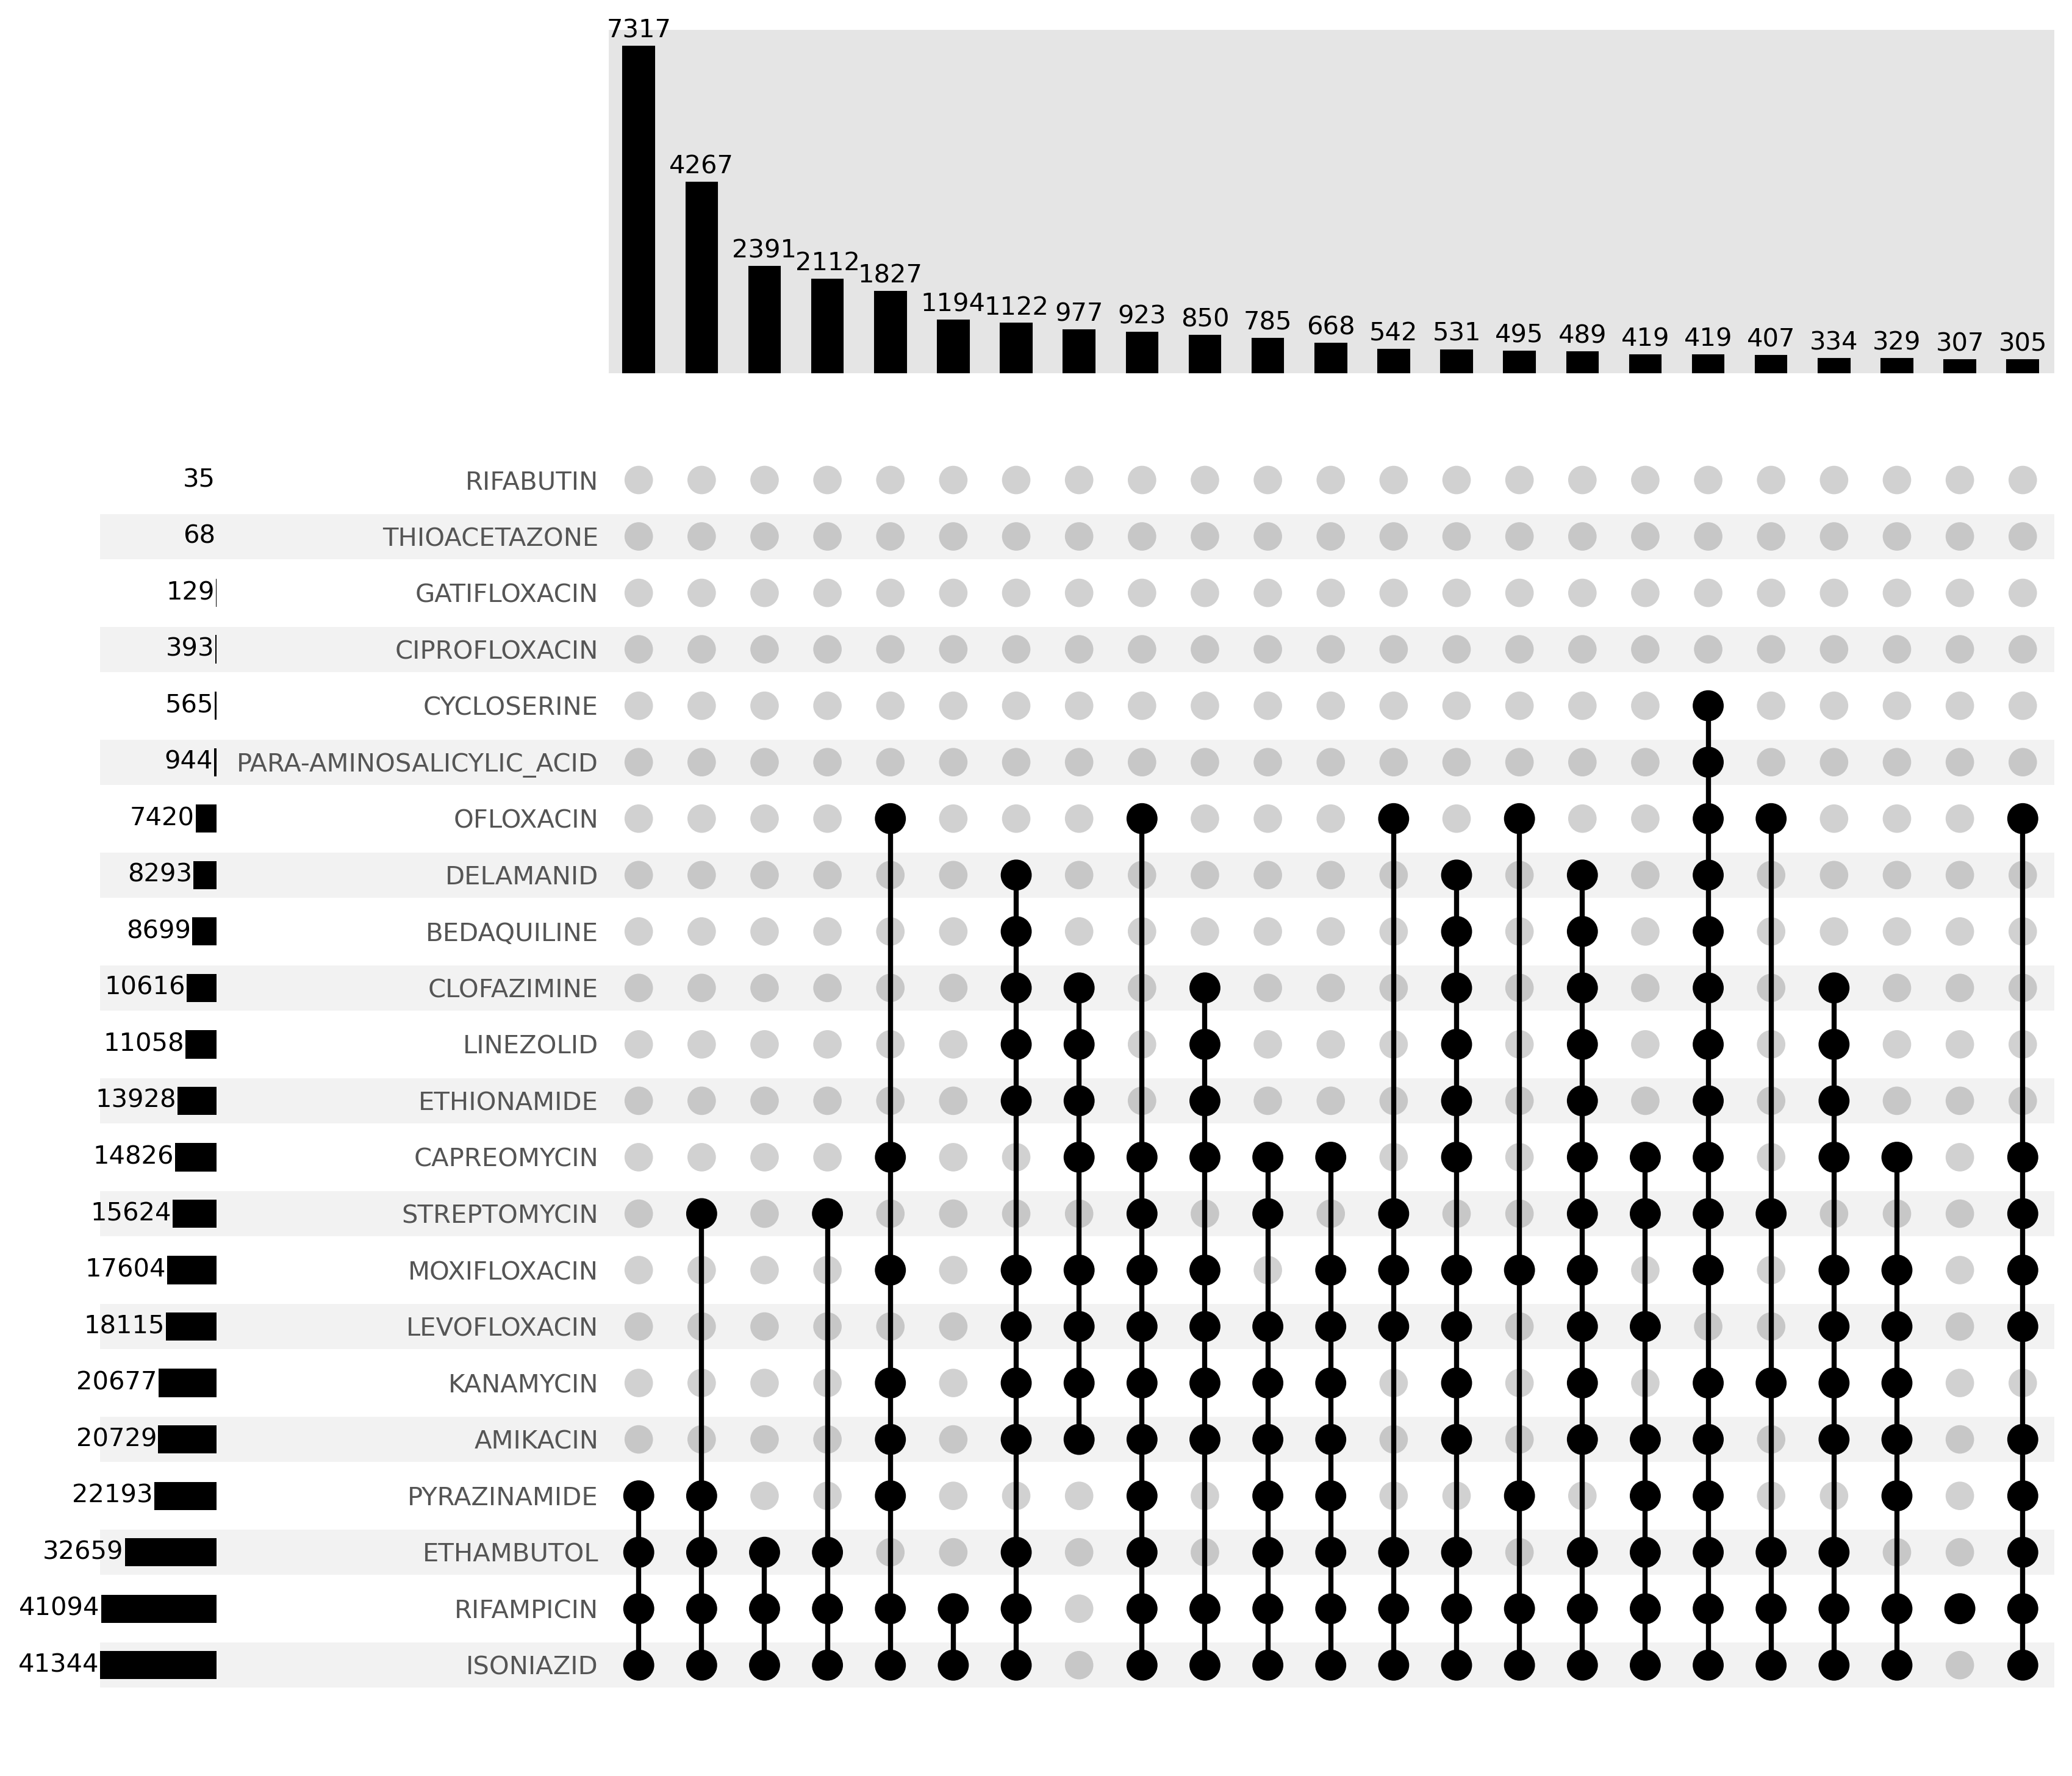

In [57]:
fig, ax = plt.subplots()
p = upsetplot.plot(
    upset_data,
    fig=fig,
    sort_by="cardinality",
    orientation="horizontal",
    show_counts=True,
    min_subset_size=300
)
p["intersections"].set_ylabel("")
p["intersections"].set_yticks([])
ax.axis("off")
# fig.set_figwidth(8)
# fig.set_figheight(10)
p["totals"].set_xticks([])
fig.set_dpi(300)

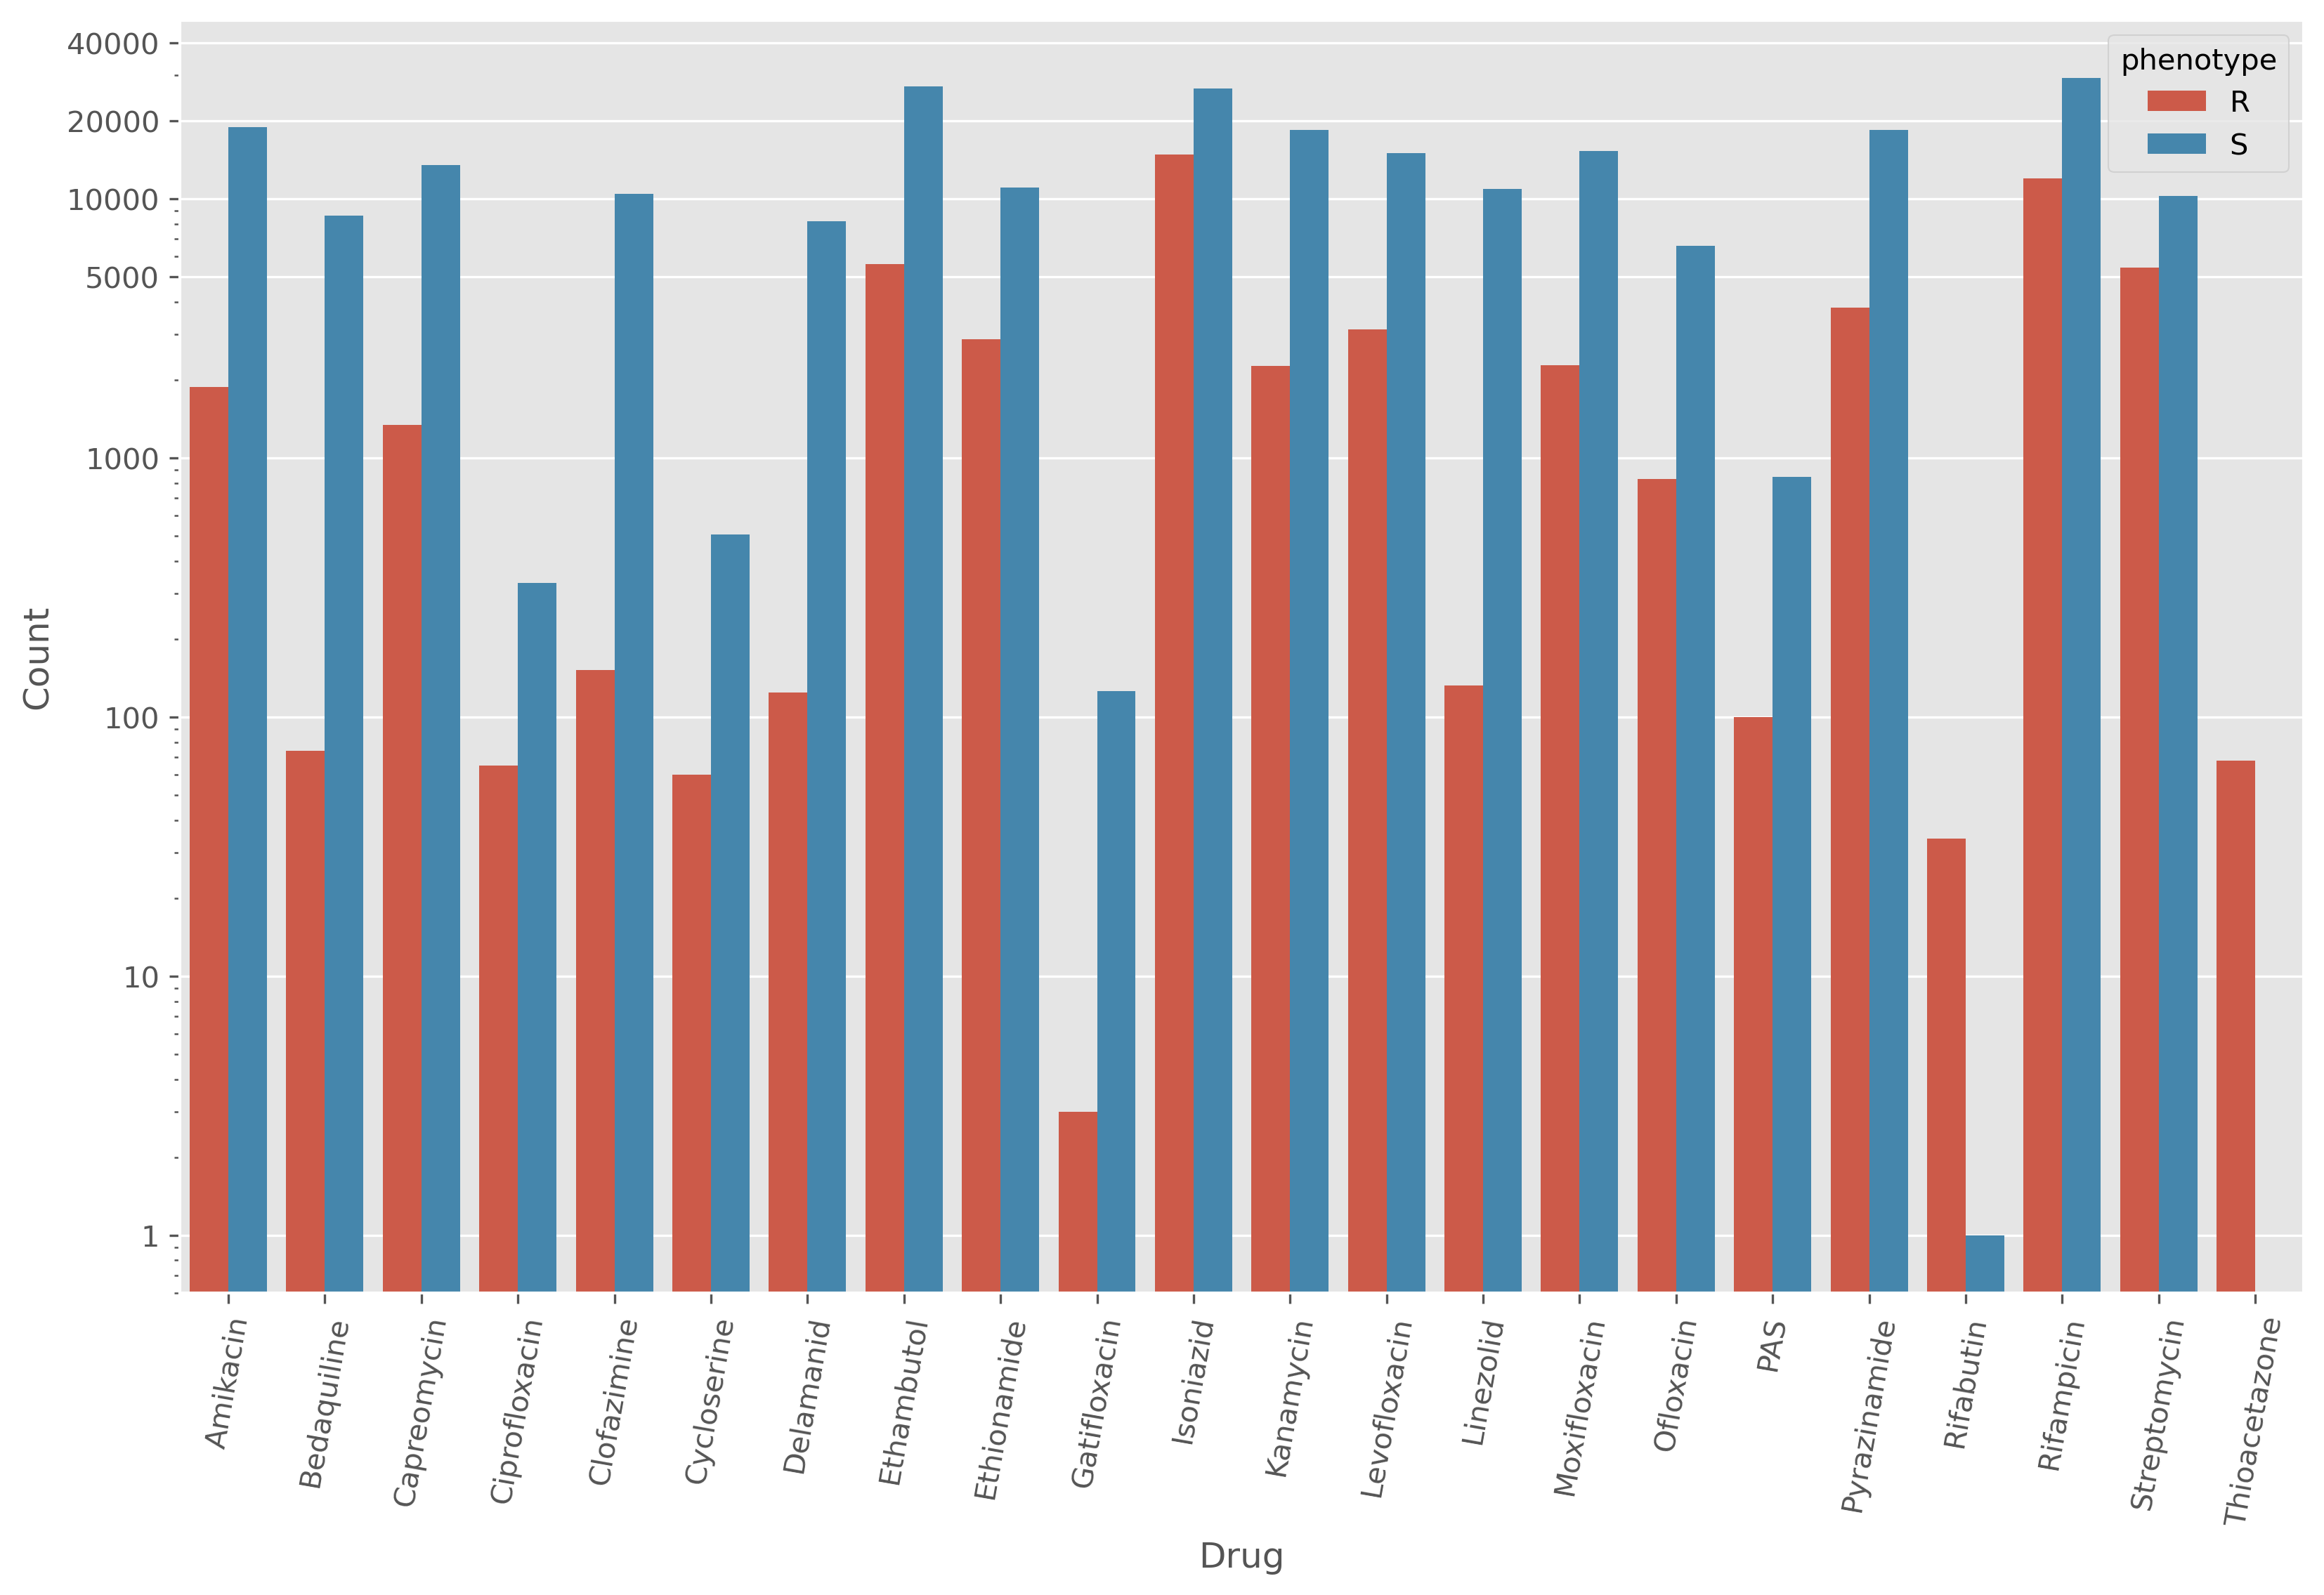

In [58]:
fig, ax = plt.subplots(dpi=300, figsize=(13, 8))
data = pheno_df.dropna()
counts = data.groupby(["drug", "phenotype"]).count().reset_index()
counts["drug"] = [s.capitalize() for s in counts["drug"]]
counts.replace("Para-aminosalicylic_acid", "PAS", inplace=True)
sns.barplot(data=counts, x="drug", y="run", hue="phenotype")
yticks = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set(ylabel="Count", xlabel="Drug")
_ = plt.xticks(rotation=80)

In [59]:
len(samplesheet)

44880

In [91]:
samplesheet = pd.read_csv("../../config/illumina.samplesheet.csv", index_col="run", low_memory=False)

In [4]:
samplesheet

amikacin bedaquiline   bioproject     biosample capreomycin  \
run                                                                      
ERR025832       NaN         NaN    PRJEB2221   SAMEA961581         NaN   
ERR025833       NaN         NaN    PRJEB2221   SAMEA961610         NaN   
ERR025834       NaN         NaN    PRJEB2221   SAMEA961608         NaN   
ERR025835       NaN         NaN    PRJEB2221   SAMEA961609         NaN   
ERR025836       NaN         NaN    PRJEB2221   SAMEA961584         NaN   
...             ...         ...          ...           ...         ...   
SRR7131295      NaN         NaN  PRJNA438921  SAMN09090621         NaN   
SRR7131296      NaN         NaN  PRJNA438921  SAMN09090622         NaN   
SRR7131297      NaN         NaN  PRJNA438921  SAMN09090623         NaN   
SRR7131298      NaN         NaN  PRJNA438921  SAMN09090624         NaN   
SRR7439415      NaN         NaN  PRJNA413593  SAMN09492287         NaN   

           ciprofloxacin clofazimine cycloserine delamanid ethambutol  ...  \
run                                                                    ...   
ERR025832            NaN         NaN         NaN       NaN          S  ...   
ERR025833            NaN         NaN         NaN       NaN          S  ...   
ERR025834            NaN         NaN         NaN       NaN          S  ...   
ERR025835            NaN         NaN         NaN       NaN          S  ...   
ERR025836            NaN         NaN         NaN       NaN          S  ...   
...                  ...         ...         ...       ...        ...  ...   
SRR7131295           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131296           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131297           NaN         NaN         NaN       NaN        NaN  ...   
SRR7131298           NaN         NaN         NaN       NaN        NaN  ...   
SRR7439415           NaN         NaN         NaN       NaN          S  ...   

           kanamycin levofloxacin linezolid moxifloxacin ofloxacin  \
run                                                                  
ERR025832        NaN          NaN       NaN          NaN       NaN   
ERR025833        NaN          NaN       NaN          NaN       NaN   
ERR025834        NaN          NaN       NaN          NaN       NaN   
ERR025835        NaN          NaN       NaN          NaN       NaN   
ERR025836        NaN          NaN       NaN          NaN       NaN   
...              ...          ...       ...          ...       ...   
SRR7131295       NaN          NaN       NaN          NaN       NaN   
SRR7131296       NaN          NaN       NaN          NaN       NaN   
SRR7131297       NaN          NaN       NaN          NaN       NaN   
SRR7131298       NaN          NaN       NaN          NaN       NaN   
SRR7439415       NaN          NaN       NaN          NaN       NaN   

           para-aminosalicylic_acid pyrazinamide rifampicin streptomycin  \
run                                                                        
ERR025832                       NaN            S          S          NaN   
ERR025833                       NaN            S          S          NaN   
ERR025834                       NaN            S          S          NaN   
ERR025835                       NaN            S          S          NaN   
ERR025836                       NaN            S          S          NaN   
...                             ...          ...        ...          ...   
SRR7131295                      NaN          NaN          S          NaN   
SRR7131296                      NaN          NaN          S          NaN   
SRR7131297                      NaN          NaN          S          NaN   
SRR7131298                      NaN          NaN          S          NaN   
SRR7439415                      NaN          NaN          S            S   

           thioacetazone  
run                       
ERR025832            NaN  
ERR025833            NaN  
ERR025834            NaN 

Getting nanopore data together

In [6]:
smith_pheno

rifampicin isoniazid pyrazinamide ethambutol streptomycin  \
Sample                                                                          
IDR1900029422-01-01        NaN       NaN          NaN        NaN          NaN   
IDR1900029655-01-01        NaN       NaN          NaN        NaN            R   
IDR1900030392-01-01          S         S            S          S          NaN   
IDR1900030837-01-01        NaN         S          NaN        NaN          NaN   
IDR1900031532-01-01          S         S            S          S          NaN   
...                        ...       ...          ...        ...          ...   
IDR2000002360-01-01          S         S            S          S            S   
IDR2000002363-01-01          S         S            S          S          NaN   
IDR2000002365-01-01          R         R            S          S            R   
IDR2000002367-01-01          S         S            S          S          NaN   
IDR2000002369-01-01          S         S            R          S          NaN   

                    amikacin kanamycin ofloxacin ethionamide  
Sample                                                        
IDR1900029422-01-01      NaN       NaN       NaN           S  
IDR1900029655-01-01      NaN       NaN       NaN         NaN  
IDR1900030392-01-01      NaN       NaN       NaN           S  
IDR1900030837-01-01      NaN       NaN       NaN         NaN  
IDR1900031532-01-01      NaN       NaN       NaN         NaN  
...                      ...       ...       ...         ...  
IDR2000002360-01-01        S         S         S           R  
IDR2000002363-01-01      NaN       NaN       NaN         NaN  
IDR2000002365-01-01        S         S         S           S  
IDR2000002367-01-01      NaN       NaN       NaN         NaN  
IDR2000002369-01-01      NaN       NaN       NaN         NaN  

[293 rows x 9 columns]

In [75]:
smith_ont_accs = pd.read_csv("smith_PRJNA650381.tsv", sep="\t").query("instrument_platform=='OXFORD_NANOPORE'")

In [76]:
smith_ont_accs.rename(columns={"run_accession": "run", "study_accession": "bioproject", "sample_accession": "biosample"}, inplace=True)

In [77]:
smith_ont_accs.set_index("sample_alias", verify_integrity=True, inplace=True)

In [78]:
keep_cols = ["bioproject", "biosample", "run"]

In [79]:
smith_ont_accs = smith_ont_accs.loc[:,keep_cols]

In [80]:
smith_ont_accs

bioproject     biosample          run
sample_alias                                               
IDR1900036271-01-01  PRJNA650381  SAMN15702997  SRR12395041
IDR1900043669-01-01  PRJNA650381  SAMN15703096  SRR12395042
IDR1900043668-01-01  PRJNA650381  SAMN15703095  SRR12395043
IDR1900043667-01-01  PRJNA650381  SAMN15703094  SRR12395044
IDR1900043666-01-01  PRJNA650381  SAMN15703093  SRR12395045
...                          ...           ...          ...
IDR1900043677-01-01  PRJNA650381  SAMN15703101  SRR12395463
IDR1900043676-01-01  PRJNA650381  SAMN15703100  SRR12395464
IDR1900043675-01-01  PRJNA650381  SAMN15703099  SRR12395465
IDR1900043673-01-01  PRJNA650381  SAMN15703098  SRR12395466
IDR1900043671-01-01  PRJNA650381  SAMN15703097  SRR12395467

[427 rows x 3 columns]

In [81]:
smith_ont_df = smith_ont_accs.combine_first(smith_pheno)

In [82]:
a2d = {
    "RIF": "rifampicin",
    "ISO": "isoniazid",
    "PRZ": "pyrazinamide",
    "ETM": "ethambutol",
    "STR": "streptomycin",
    "AMI": "amikacin",
    "KAN": "kanamycin",
    "FLQ": "ofloxacin",
    "ETH": "ethionamide"
}

In [83]:
no_pheno_ix = smith_ont_df[list(a2d.values())].isna().apply(lambda x: all(x), axis=1)
smith_ont_df = smith_ont_df.loc[~no_pheno_ix]
missing_accs = smith_ont_df[["run", "biosample", "bioproject"]].isna().apply(lambda x: any(x), axis=1)
smith_ont_df = smith_ont_df.loc[~missing_accs]
smith_ont_df = smith_ont_df.reset_index(drop=True).set_index("run", verify_integrity=True)
smith_ont_df

amikacin   bioproject     biosample ethambutol ethionamide  \
run                                                                      
SRR12395083      NaN  PRJNA650381  SAMN15702924        NaN           S   
SRR12395081      NaN  PRJNA650381  SAMN15702926        NaN         NaN   
SRR12395341      NaN  PRJNA650381  SAMN15702930          S           S   
SRR12395339      NaN  PRJNA650381  SAMN15702932        NaN         NaN   
SRR12395332      NaN  PRJNA650381  SAMN15702938          S         NaN   
...              ...          ...           ...        ...         ...   
SRR12395147        S  PRJNA650381  SAMN15703343          S           R   
SRR12395146      NaN  PRJNA650381  SAMN15703344          S         NaN   
SRR12395145        S  PRJNA650381  SAMN15703345          S           S   
SRR12395144      NaN  PRJNA650381  SAMN15703346          S         NaN   
SRR12395143      NaN  PRJNA650381  SAMN15703347          S         NaN   

            isoniazid kanamycin ofloxacin pyrazinamide rifampicin streptomycin  
run                                                                             
SRR12395083       NaN       NaN       NaN          NaN        NaN          NaN  
SRR12395081       NaN       NaN       NaN          NaN        NaN            R  
SRR12395341         S       NaN       NaN            S          S          NaN  
SRR12395339         S       NaN       NaN          NaN        NaN          NaN  
SRR12395332         S       NaN       NaN            S          S          NaN  
...               ...       ...       ...          ...        ...          ...  
SRR12395147         S         S         S            S          S            S  
SRR12395146         S       NaN       NaN            S          S          NaN  
SRR12395145         R         S         S            S          R            R  
SRR12395144         S       NaN       NaN            S          S          NaN  
SRR12395143         S       NaN       NaN            R          S          NaN  

[291 rows x 11 columns]

In [84]:
smith_ont_df.to_csv("smith_ont.csv")

In [85]:
ont_samplesheet = smith_ont_df.copy(deep=True)

In [86]:
csv_url = "https://figshare.com/ndownloader/files/34302611"
h2h_df = pd.read_csv(csv_url)
# use the first accession where there are multiple
h2h_df.set_index("sample", verify_integrity=True, inplace=True)
# h2h_df.index.rename("run", inplace=True)
h2h_df

site  matched  pacbio  excluded  failed_qc  \
sample                                                         
mada_1-7    madagascar        1       0         0          0   
mada_109    madagascar        1       0         0          0   
mada_1-28   madagascar        1       0         0          0   
mada_135    madagascar        1       0         0          0   
mada_1-43   madagascar        1       0         0          0   
...                ...      ...     ...       ...        ...   
18_0622446  birmingham        1       0         0          0   
18_0622455  birmingham        1       0         0          0   
18_0622456  birmingham        1       0         0          0   
18_0622465  birmingham        1       0         0          0   
18_620606   birmingham        1       0         0          0   

                             run  barcode barcode_kit collection_date  \
sample                                                                  
mada_1-7     madagascar_tb_mdr_4        1  EXP-NBD103       24/3/2016   
mada_109      md_tb_reseq_2019_3        6  EXP-NBD104       12/2/2014   
mada_1-28    madagascar_tb_mdr_1        4  EXP-NBD103       18/8/2015   
mada_135      madagscar_tb_aug_1        7  EXP-NBD103        9/5/2017   
mada_1-43     md_tb_reseq_2019_5        7  EXP-NBD104        1/4/2014   
...                          ...      ...         ...             ...   
18_0622446  birmingham-mgit-run5        2  EXP-NBD103            2018   
18_0622455  birmingham-mgit-run6        1  EXP-NBD103            2018   
18_0622456  birmingham-mgit-run3        4  EXP-NBD103            2018   
18_0622465  birmingham-mgit-run4       10  EXP-NBD103            2018   
18_620606             mgit_phe_1        2  EXP-NBD103            2018   

            lineage illumina_run_accession nanopore_run_accession  \
sample                                                              
mada_1-7      1.1.2             ERR9030348             ERR9030361   
mada_109    4.6.2.2             ERR9030337             ERR9030369   
mada_1-28     2.2.7             ERR9030251             ERR9030326   
mada_135      3.1.1             ERR9030486             ERR9030252   
mada_1-43     1.1.2             ERR9030356             ERR9030513   
...             ...                    ...                    ...   
18_0622446    4.2.2             ERR4815143             ERR9030423   
18_0622455    3.1.2             ERR4818353             ERR9030518   
18_0622456  4.4.1.2             ERR4818310             ERR9030479   
18_0622465      2.2             ERR4814410             ERR9030543   
18_620606       4.1             ERR4821577             ERR9030517   

           pacbio_run_accession sample_accession biosample_accession  \
sample                                                                 
mada_1-7                    NaN      ERS10792195       SAMEA13188658   
mada_109                    NaN      ERS10792196       SAMEA13188659   
mada_1-28                   NaN      ERS10792197       SAMEA13188660   
mada_135                    NaN      ERS10792198       SAMEA13188661   
mada_1-43                   NaN      ERS10792199       SAMEA13188662   
...                         ...              ...                 ...   
18_0622446                  NaN      ERS10792341       SAMEA13188804   
18_0622455                  NaN      ERS10792342       SAMEA13188805   
18_0622456                  NaN      ERS10792343       SAMEA13188806   
18_0622465                  NaN      ERS10792344       SAMEA13188807   
18_620606                   NaN      ERS10792345       SAMEA13188808   

           assembly_accession  
sample                         
mada_1-7                  NaN  
mada_109                  NaN  
mada_1-28                 NaN  
mada_135                  NaN  
mada_1-43                 NaN  
...                       ...  
18_0622446                NaN  
18_0622455                NaN  
18_0622456                NaN  
18_0622465                NaN  
18_620606       

In [87]:
url = "https://raw.githubusercontent.com/mbhall88/head_to_head_pipeline/3ed818c9f3754612a33060428ee651cd0f91234b/docs/phenotypes.csv"
h2h_pheno = pd.read_csv(url, index_col="sample")
# drop the LPA phenotypes
drop_cols = [c for c in h2h_pheno.columns if c.endswith("-lpa")]
h2h_pheno.drop(columns=drop_cols, inplace=True)
# some phenos have ND
h2h_pheno.replace("ND", np.nan, inplace=True)
h2h_pheno

streptomycin isoniazid rifampicin ethambutol  pas thioacetazone  \
sample                                                                     
mada_101            S         S          S          S    S             R   
mada_102            S         S          S          S    S             R   
mada_103            S         S          S          S    S             R   
mada_104            S         R          S          S    S             R   
mada_105            S         R          S          S    S             R   
...               ...       ...        ...        ...  ...           ...   
R36431            NaN         S          S          S    S           NaN   
R36440            NaN       NaN        NaN        NaN  NaN           NaN   
R37259            NaN       NaN        NaN        NaN  NaN           NaN   
R37765            NaN       NaN        NaN        NaN  NaN           NaN   
R38290            NaN       NaN        NaN        NaN  NaN           NaN   

         moxifloxacin ofloxacin amikacin kanamycin capreomycin pyrazinamide  \
sample                                                                        
mada_101          NaN       NaN      NaN       NaN         NaN          NaN   
mada_102          NaN         S        S         S           S          NaN   
mada_103          NaN       NaN      NaN       NaN         NaN          NaN   
mada_104          NaN         S        S         S           S          NaN   
mada_105          NaN         S        S         S           S          NaN   
...               ...       ...      ...       ...         ...          ...   
R36431              S       NaN        S         S           S            S   
R36440            NaN       NaN      NaN       NaN         NaN          NaN   
R37259            NaN         S        R       NaN         NaN          NaN   
R37765            NaN       NaN      NaN       NaN         NaN          NaN   
R38290            NaN       NaN      NaN       NaN         NaN          NaN   

         ethionamide  
sample                
mada_101         NaN  
mada_102         NaN  
mada_103         NaN  
mada_104         NaN  
mada_105         NaN  
...              ...  
R36431             R  
R36440           NaN  
R37259           NaN  
R37765           NaN  
R38290           NaN  

[200 rows x 13 columns]

In [88]:
# drop all but the nanopore run and biosample accessions
h2h_df = h2h_df.loc[:,["biosample_accession", "nanopore_run_accession"]]

In [89]:
h2h_df = h2h_pheno.join(h2h_df, how="inner")

In [90]:
h2h_df.rename(columns={"pas": "para-aminosalicylic_acid", "illumina_run_accession": "run", "biosample_accession": "biosample"}, inplace=True)

In [91]:
h2h_df = h2h_df.rename(columns={"nanopore_run_accession": "run"}).reset_index(drop=True).set_index("run")

In [92]:
h2h_df["bioproject"] = "PRJEB49093"

In [93]:
h2h_df.replace("N", np.nan, inplace=True)
h2h_df

streptomycin isoniazid rifampicin ethambutol  \
run                                                       
ERR9030471          NaN         S        NaN        NaN   
ERR9030394          NaN       NaN        NaN        NaN   
ERR9030283          NaN       NaN        NaN        NaN   
ERR9030530          NaN       NaN        NaN        NaN   
ERR9030378          NaN       NaN        NaN        NaN   
...                 ...       ...        ...        ...   
ERR9030537            S         R          R          R   
ERR9030379            S         R          R          S   
ERR9030349            S         R          R          S   
ERR9030514            S         R          R          S   
ERR9030466            S         R          R          S   

           para-aminosalicylic_acid thioacetazone moxifloxacin ofloxacin  \
run                                                                        
ERR9030471                      NaN           NaN          NaN         S   
ERR9030394                      NaN           NaN          NaN         S   
ERR9030283                      NaN           NaN          NaN         R   
ERR9030530                      NaN           NaN          NaN         S   
ERR9030378                      NaN           NaN          NaN         R   
...                             ...           ...          ...       ...   
ERR9030537                        S             R          NaN       NaN   
ERR9030379                        S             R          NaN         S   
ERR9030349                      NaN           NaN          NaN         S   
ERR9030514                        S             R          NaN         S   
ERR9030466                        S             R          NaN         S   

           amikacin kanamycin capreomycin pyrazinamide ethionamide  \
run                                                                  
ERR9030471        S       NaN         NaN          NaN           S   
ERR9030394        R       NaN         NaN          NaN           R   
ERR9030283        S       NaN         NaN          NaN           S   
ERR9030530        S       NaN         NaN          NaN           S   
ERR9030378        S       NaN         NaN          NaN           S   
...             ...       ...         ...          ...         ...   
ERR9030537      NaN       NaN         NaN          NaN         NaN   
ERR9030379        S         S           S          NaN         NaN   
ERR9030349        S         S           S          NaN         NaN   
ERR9030514        S         S           S          NaN         NaN   
ERR9030466        S         S           S          NaN         NaN   

                biosample  bioproject  
run                                    
ERR9030471  SAMEA13188786  PRJEB49093  
ERR9030394  SAMEA13188759  PRJEB49093  
ERR9030283  SAMEA13188777  PRJEB49093  
ERR9030530  SAMEA13188782  PRJEB49093  
ERR9030378  SAMEA13188767  PRJEB49093  
...                   ...         ...  
ERR9030537  SAMEA13188675  PRJEB49093  
ERR9030379  SAMEA13188703  PRJEB49093  
ERR9030349  SAMEA13188691  PRJEB49093  
ERR9030514  SAMEA13188664  PRJEB49093  
ERR9030466  SAMEA13188747  PRJEB49093  

[131 rows x 15 columns]

In [94]:
h2h_df.to_csv("h2h_ont.csv")

In [95]:
ont_samplesheet = ont_samplesheet.combine(h2h_df, func=combine_func, overwrite=False)

In [121]:
# ont_samplesheet.to_csv("../../config/nanopore.samplesheet.csv")

In [122]:
ont_samplesheet = pd.read_csv("../../config/nanopore.samplesheet.csv", low_memory=False, index_col="run")

In [123]:
ont_samplesheet

amikacin   bioproject      biosample capreomycin ethambutol  \
run                                                                       
ERR9030248         S   PRJEB49093  SAMEA13188784         NaN        NaN   
ERR9030249       NaN   PRJEB49093  SAMEA13188702         NaN          S   
ERR9030252       NaN   PRJEB49093  SAMEA13188661         NaN          S   
ERR9030253         R   PRJEB49093  SAMEA13188780         NaN        NaN   
ERR9030254         S   PRJEB49093  SAMEA13188719           S          S   
...              ...          ...            ...         ...        ...   
SRR14196854        S  PRJNA720906   SAMN18521323           S          R   
SRR14196856        S  PRJNA720906   SAMN18521322           S          R   
SRR14196858        S  PRJNA720906   SAMN18521321           S          R   
SRR14196860        R  PRJNA720906   SAMN18521320           R          S   
SRR14196862        S  PRJNA720906   SAMN18521315           S          S   

            ethionamide isoniazid kanamycin moxifloxacin ofloxacin  \
run                                                                  
ERR9030248          NaN       NaN       NaN          NaN         S   
ERR9030249          NaN         S       NaN          NaN       NaN   
ERR9030252          NaN         S       NaN          NaN       NaN   
ERR9030253          NaN       NaN       NaN          NaN         R   
ERR9030254          NaN         S         S          NaN         S   
...                 ...       ...       ...          ...       ...   
SRR14196854         NaN         R       NaN          NaN         S   
SRR14196856         NaN         R       NaN          NaN         S   
SRR14196858         NaN         R       NaN          NaN         S   
SRR14196860         NaN         R       NaN          NaN         S   
SRR14196862         NaN         R       NaN          NaN         S   

            para-aminosalicylic_acid pyrazinamide rifampicin streptomycin  \
run                                                                         
ERR9030248                       NaN          NaN        NaN          NaN   
ERR9030249                         S          NaN          S            S   
ERR9030252                       NaN          NaN          S            S   
ERR9030253                       NaN          NaN        NaN          NaN   
ERR9030254                         S          NaN          S            S   
...                              ...          ...        ...          ...   
SRR14196854                      NaN            S          R            R   
SRR14196856                      NaN            R          R            R   
SRR14196858                      NaN            R          R            R   
SRR14196860                      NaN            S          R            R   
SRR14196862                      NaN            R          R            R   

            thioacetazone  
run                        
ERR9030248            NaN  
ERR9030249              R  
ERR9030252            NaN  
ERR9030253            NaN  
ERR9030254              R  
...                   ...  
SRR14196854           NaN  
SRR14196856           NaN  
SRR14196858           NaN  
SRR14196860           NaN  
SRR14196862           NaN  

[437 rows x 15 columns]

In [116]:
peker_pheno = pd.read_csv(datadir/"peker_pheno.csv", index_col="sample_alias")
peker_accs = pd.read_csv(datadir / "peker_PRJNA720906.tsv", sep="\t")
peker_accs.rename(columns={"run_accession": "run", "study_accession": "bioproject", "sample_accession": "biosample"}, inplace=True)
peker_accs = peker_accs.query("instrument_platform=='OXFORD_NANOPORE'")
peker_accs.set_index("sample_alias", verify_integrity=True, inplace=True)
keep_cols = ["bioproject", "biosample", "run"]
peker_accs = peker_accs.loc[:,keep_cols]
peker_accs = peker_accs.loc[peker_pheno.index]
peker_df = peker_accs.combine_first(peker_pheno)
peker_df = peker_df.reset_index(drop=True).set_index("run", verify_integrity=True)
peker_df

amikacin   bioproject     biosample capreomycin ethambutol  \
run                                                                      
SRR14196862        S  PRJNA720906  SAMN18521315           S          S   
SRR14196840        R  PRJNA720906  SAMN18521316           R          S   
SRR14196818        S  PRJNA720906  SAMN18521317           S          S   
SRR14196816        S  PRJNA720906  SAMN18521318           S          R   
SRR14196814        S  PRJNA720906  SAMN18521319           S          S   
SRR14196860        R  PRJNA720906  SAMN18521320           R          S   
SRR14196858        S  PRJNA720906  SAMN18521321           S          R   
SRR14196856        S  PRJNA720906  SAMN18521322           S          R   
SRR14196854        S  PRJNA720906  SAMN18521323           S          R   
SRR14196852        S  PRJNA720906  SAMN18521324           S          S   
SRR14196849        S  PRJNA720906  SAMN18521325           S          S   
SRR14196847        S  PRJNA720906  SAMN18521326           S          R   
SRR14196845        S  PRJNA720906  SAMN18521327           S          S   
SRR14196843        S  PRJNA720906  SAMN18521328           S          R   
SRR14196841        S  PRJNA720906  SAMN18521329           S          S   

            isoniazid ofloxacin pyrazinamide rifampicin streptomycin  
run                                                                   
SRR14196862         R         S            R          R            R  
SRR14196840         R         S            S          R            R  
SRR14196818         R         S            S          R            R  
SRR14196816         R         S            R          R            R  
SRR14196814         R         S            S          R            R  
SRR14196860         R         S            S          R            R  
SRR14196858         R         S            R          R            R  
SRR14196856         R         S            R          R            R  
SRR14196854         R         S            S          R            R  
SRR14196852         R         S            R          R            R  
SRR14196849         R         S            S          R            R  
SRR14196847         R         S            R          R            R  
SRR14196845         R         S            S          R            R  
SRR14196843         R         S            R          R            R  
SRR14196841         R         S            S          R            R

In [117]:
ont_samplesheet = ont_samplesheet.combine(peker_df, func=combine_func, overwrite=False)

In [124]:
drop_cols = {"biosample", "bioproject"}
DRUGS = set(ont_samplesheet.drop(columns=drop_cols).columns)
pheno_df = ont_samplesheet.drop(columns=drop_cols).melt(ignore_index=False, var_name="drug", value_name="phenotype").reset_index()

In [125]:
d = {}
exclude = set()
samples_with_pheno = []
for drug in map(str.lower, DRUGS):
    drug_df = pheno_df.query("drug == @drug").dropna()
    samples = list(drug_df["run"])
    samples_with_pheno.extend(samples)
    if samples:
        d[drug.upper()] = samples
        
upset_data = upsetplot.from_contents(d)

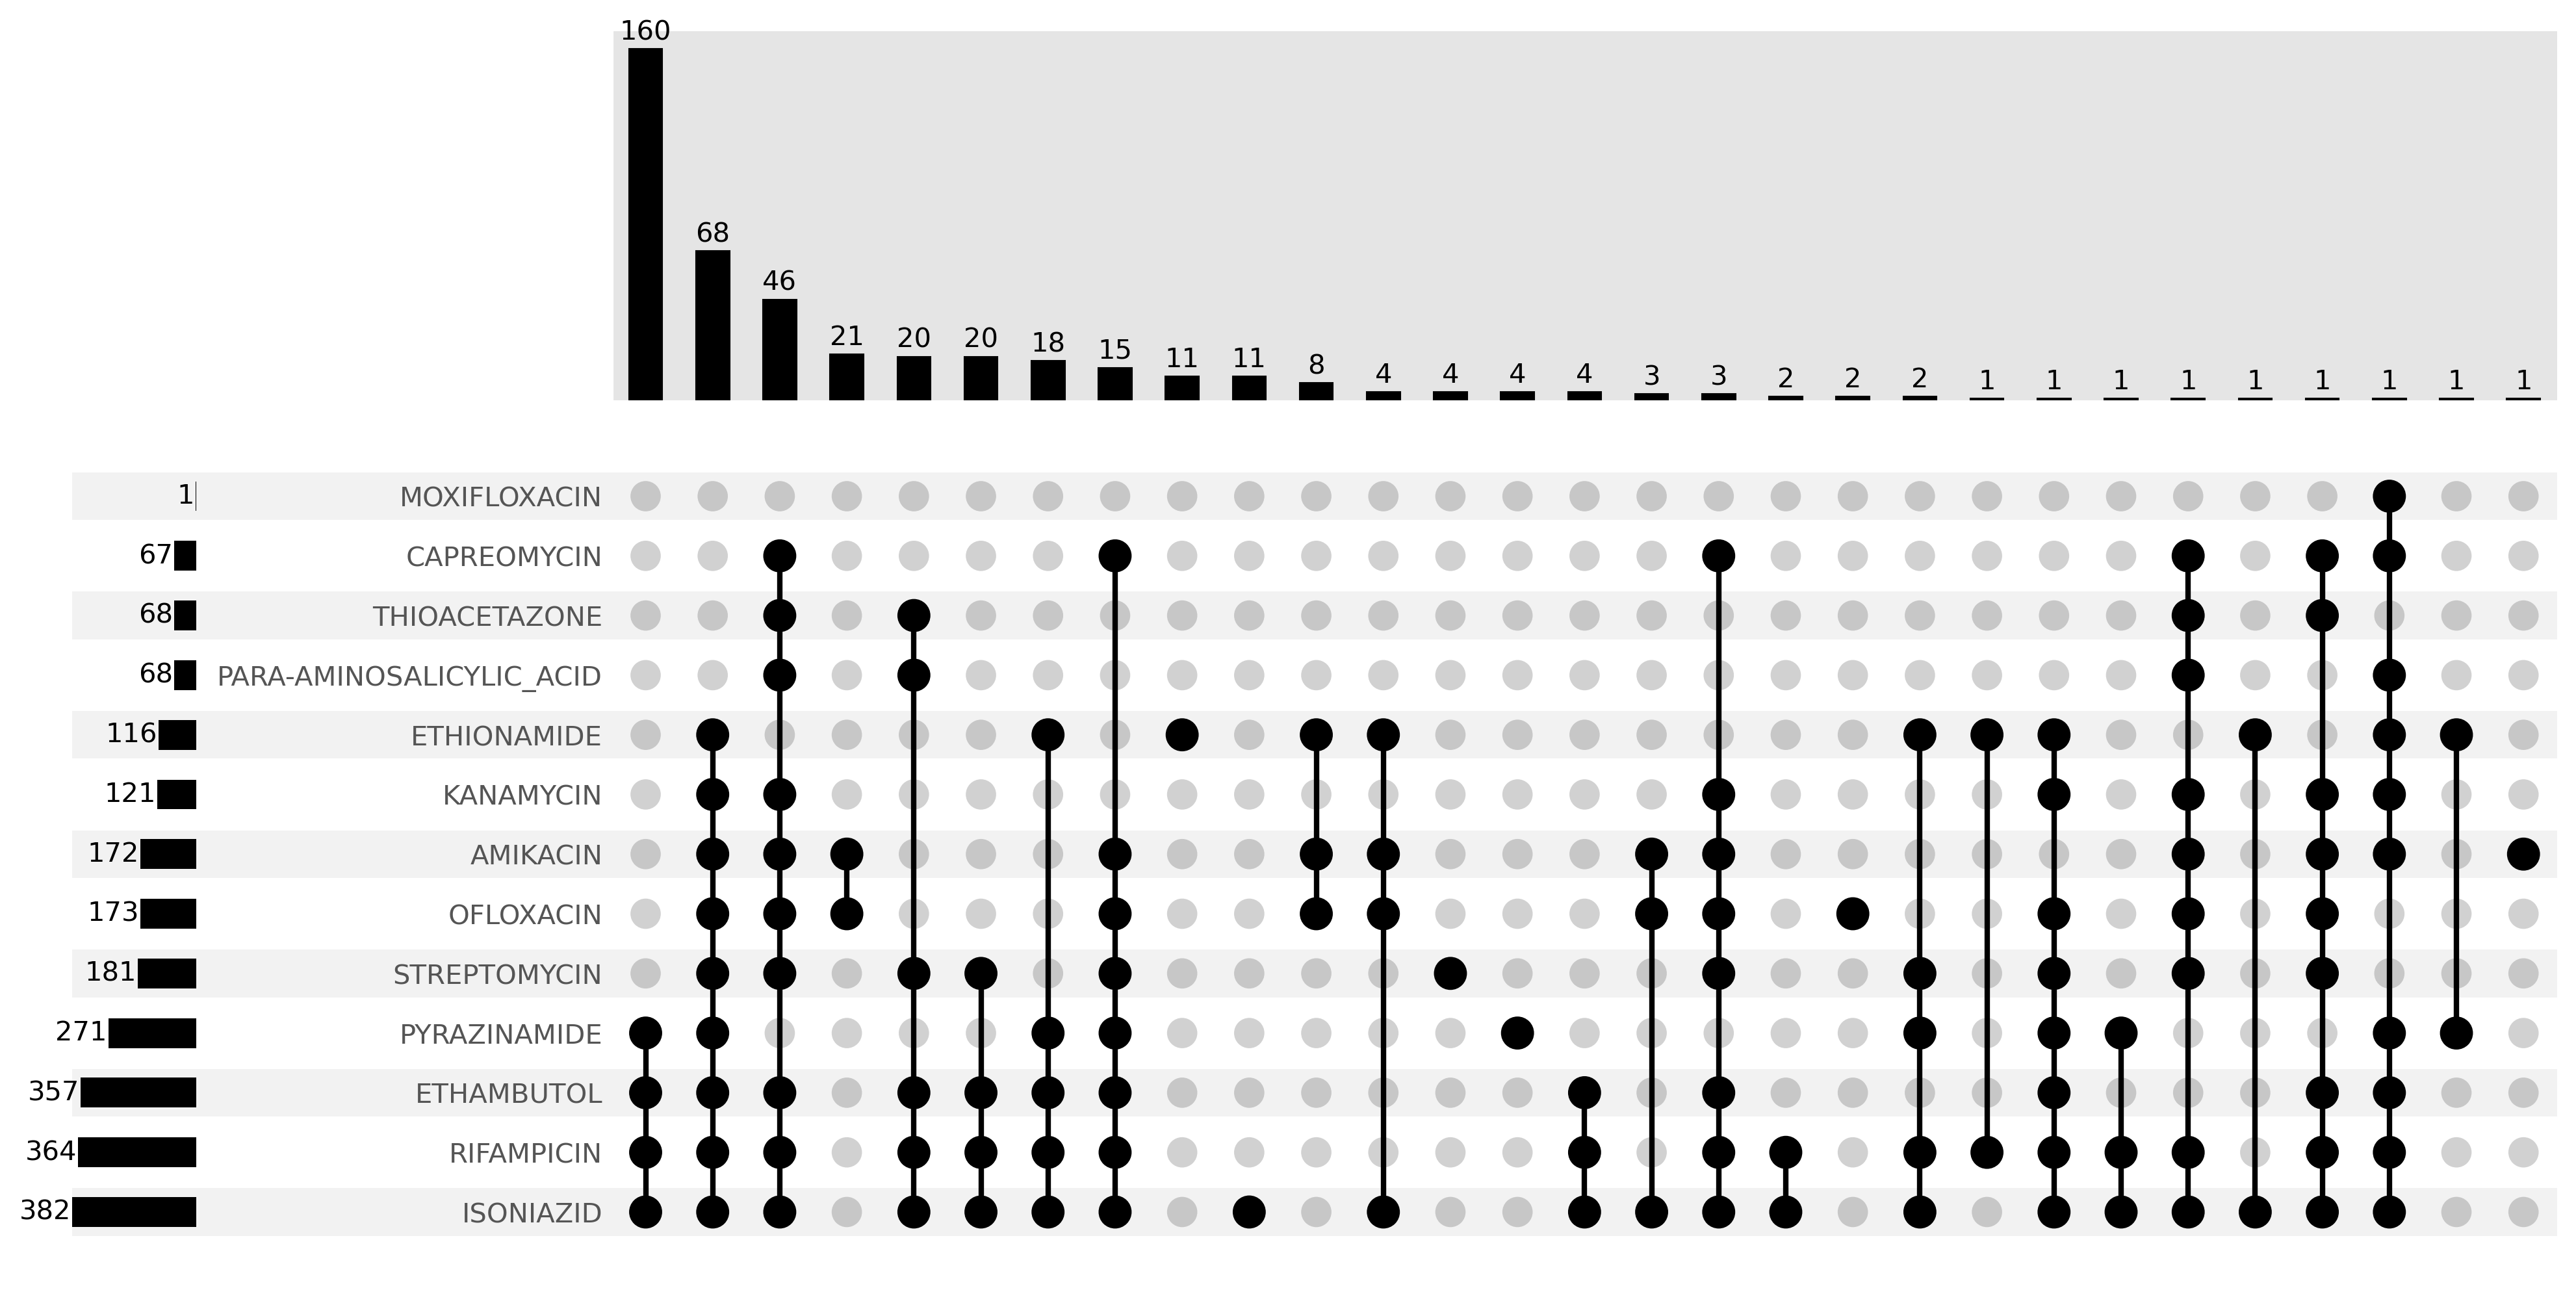

In [126]:
fig, ax = plt.subplots()
p = upsetplot.plot(
    upset_data,
    fig=fig,
    sort_by="cardinality",
    orientation="horizontal",
    show_counts=True,
#     min_subset_size=300
)
p["intersections"].set_ylabel("")
p["intersections"].set_yticks([])
ax.axis("off")
# fig.set_figwidth(8)
# fig.set_figheight(10)
p["totals"].set_xticks([])
fig.set_dpi(300)

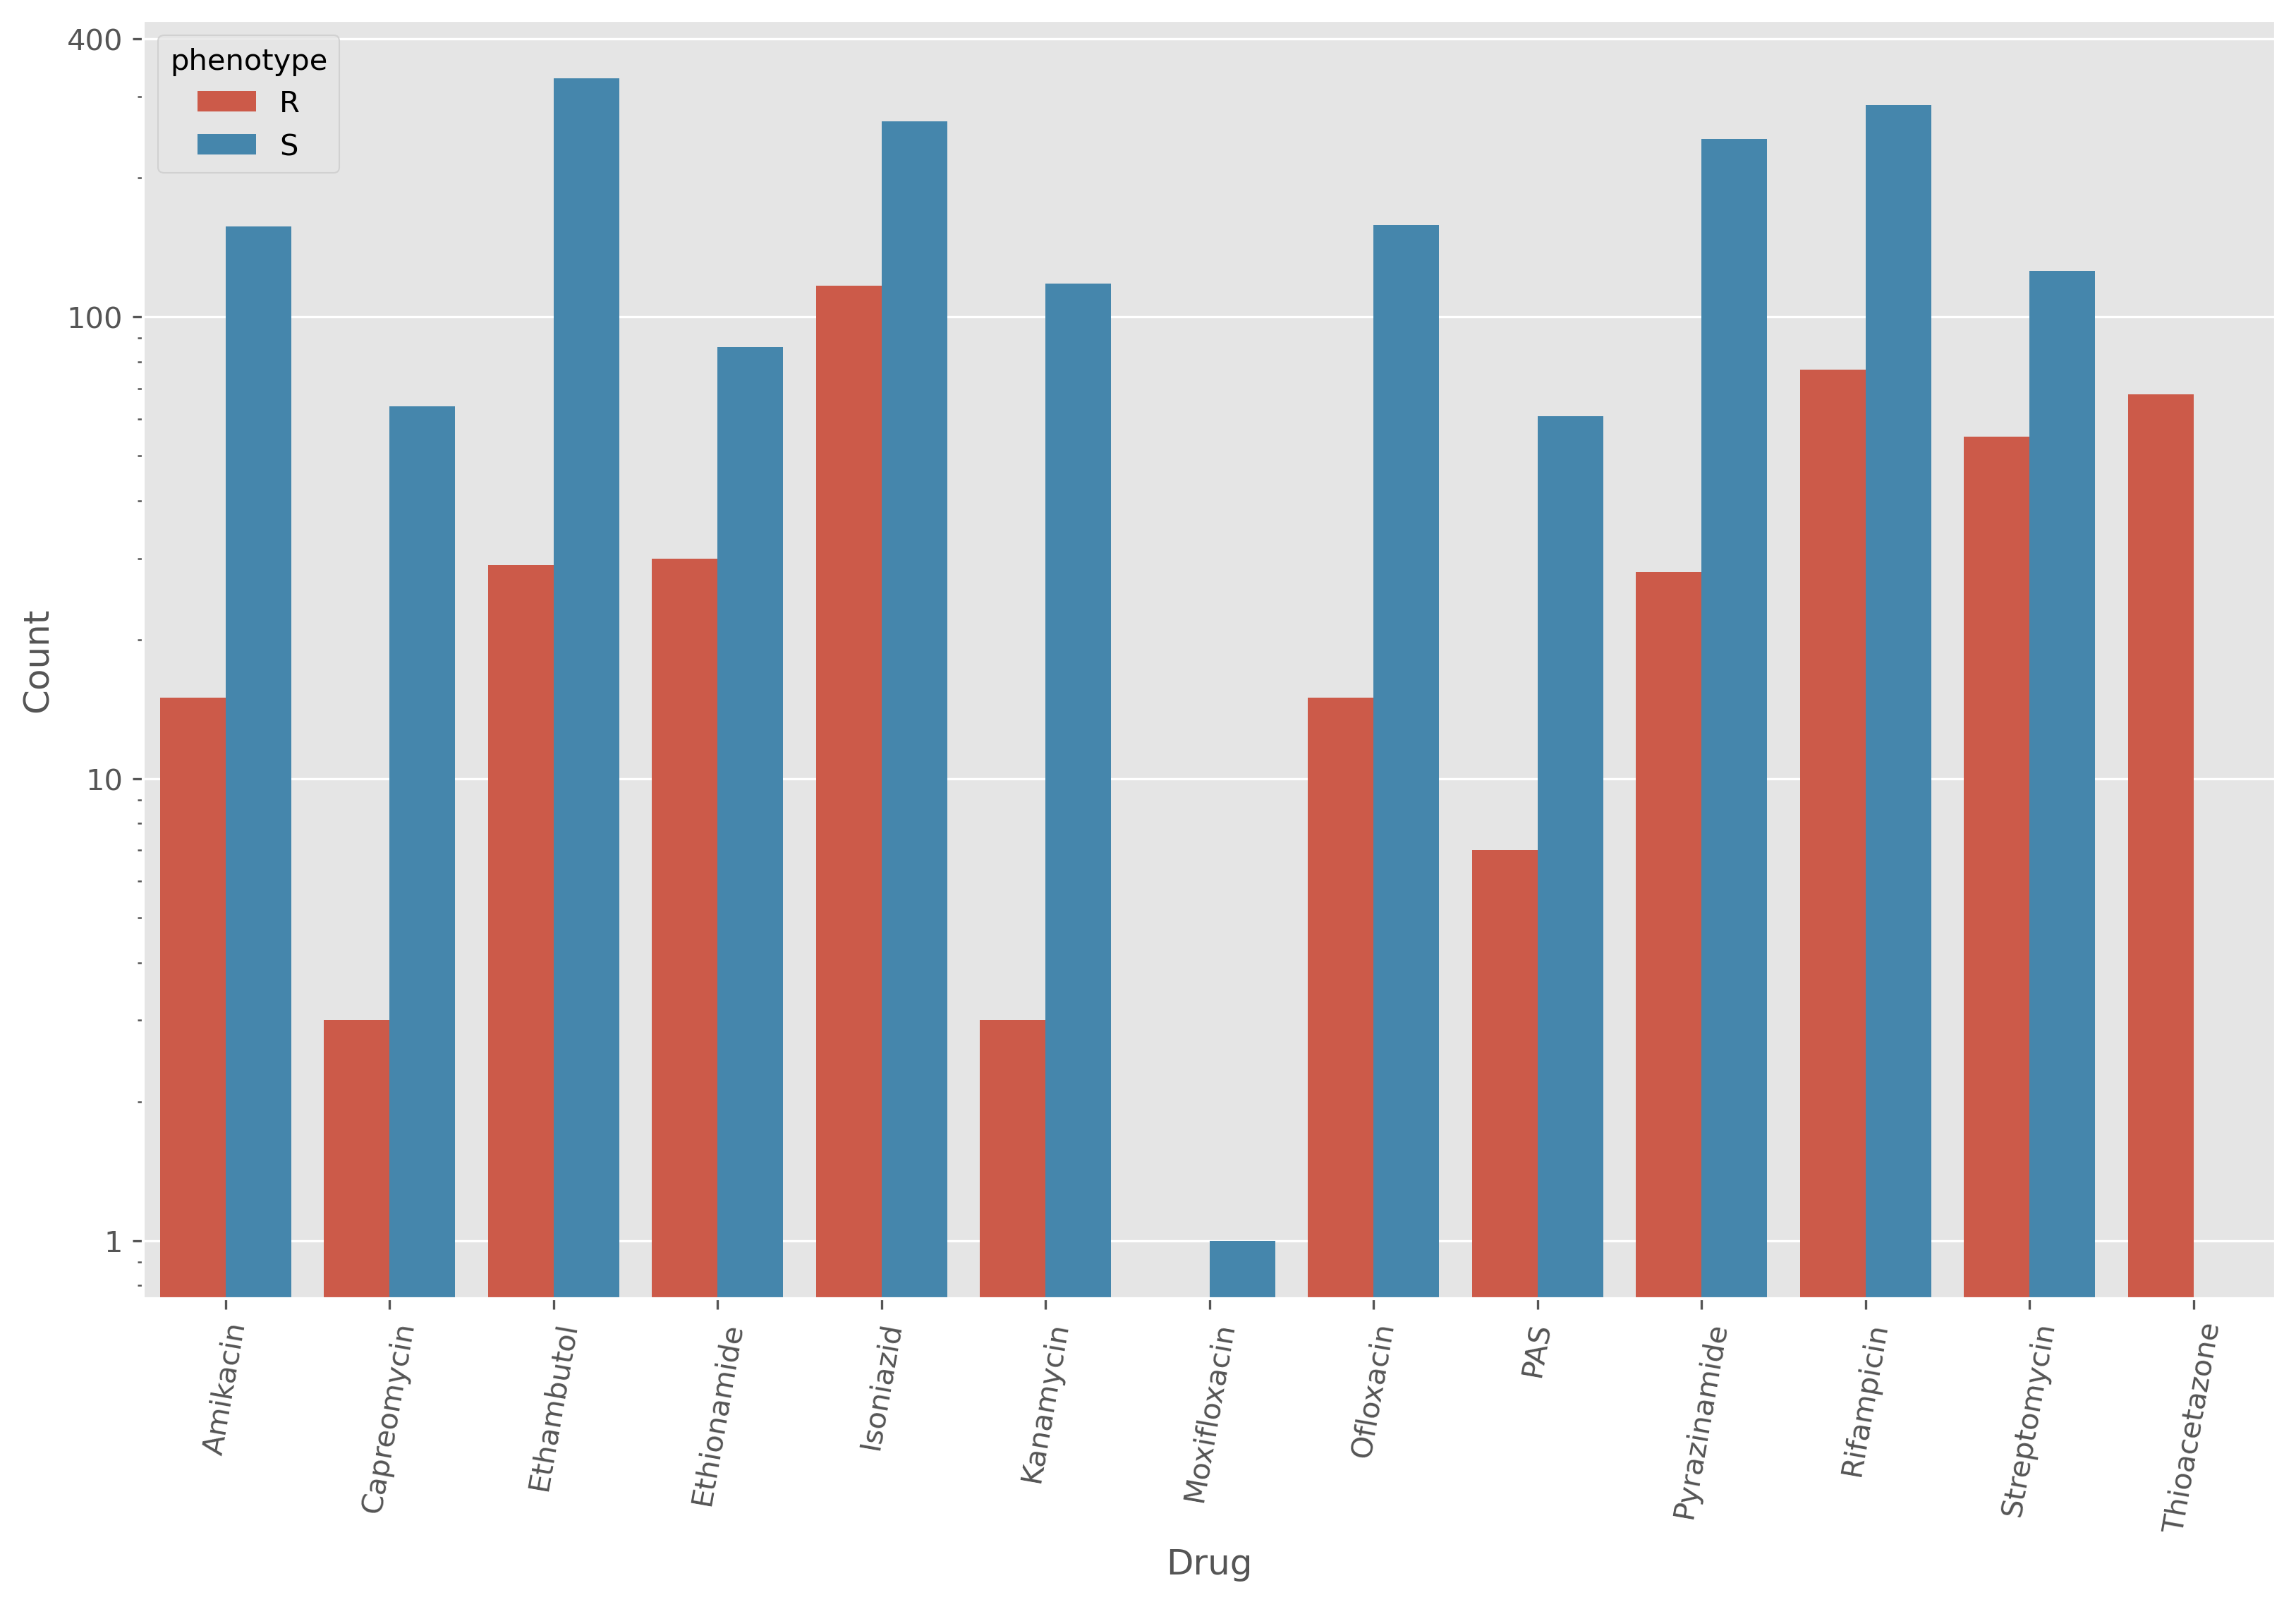

In [127]:
fig, ax = plt.subplots(dpi=300, figsize=(13, 8))
data = pheno_df.dropna()
counts = data.groupby(["drug", "phenotype"]).count().reset_index()
counts["drug"] = [s.capitalize() for s in counts["drug"]]
counts.replace("Para-aminosalicylic_acid", "PAS", inplace=True)
sns.barplot(data=counts, x="drug", y="run", hue="phenotype")
yticks = [1, 10, 100, 400]
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set(ylabel="Count", xlabel="Drug")
_ = plt.xticks(rotation=80)

In [64]:
pheno_df.query("phenotype=='N'")

run         drug phenotype
13    ERR9030286     amikacin         N
81    ERR9030433     amikacin         N
90    ERR9030452     amikacin         N
109   ERR9030501     amikacin         N
435   ERR9030286  capreomycin         N
503   ERR9030433  capreomycin         N
512   ERR9030452  capreomycin         N
531   ERR9030501  capreomycin         N
2123  ERR9030286    kanamycin         N
2191  ERR9030433    kanamycin         N
2200  ERR9030452    kanamycin         N
2219  ERR9030501    kanamycin         N
2967  ERR9030286    ofloxacin         N
3035  ERR9030433    ofloxacin         N
3044  ERR9030452    ofloxacin         N
3063  ERR9030501    ofloxacin         N

In [32]:
xs = [{'chrom': 'Chromosome', 'genome_pos': 7362, 'ref': 'G', 'alt': 'C', 'freq': 0.989247311827957, 'gene_name': 'gyrA', 'gene_id': 'Rv0006', 'feature_id': 'CCP42728', 'type': 'missense_variant', 'nucleotide_change': 'c.61G>C', 'protein_change': 'p.Glu21Gln', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Glu21Gln', 'drug': 'moxifloxacin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'p.Glu21Gln', 'drug': 'levofloxacin', 'who_confidence': 'Not assoc w R'}], 'alternate_consequences': [], 'change': 'p.Glu21Gln'}, {'chrom': 'Chromosome', 'genome_pos': 7585, 'ref': 'G', 'alt': 'C', 'freq': 0.9835164835164835, 'gene_name': 'gyrA', 'gene_id': 'Rv0006', 'feature_id': 'CCP42728', 'type': 'missense_variant', 'nucleotide_change': 'c.284G>C', 'protein_change': 'p.Ser95Thr', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Ser95Thr', 'drug': 'levofloxacin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'p.Ser95Thr', 'drug': 'moxifloxacin', 'who_confidence': 'Not assoc w R'}], 'alternate_consequences': [], 'change': 'p.Ser95Thr'}, {'chrom': 'Chromosome', 'genome_pos': 9304, 'ref': 'G', 'alt': 'A', 'freq': 0.9801324503311258, 'gene_name': 'gyrA', 'gene_id': 'Rv0006', 'feature_id': 'CCP42728', 'type': 'missense_variant', 'nucleotide_change': 'c.2003G>A', 'protein_change': 'p.Gly668Asp', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Gly668Asp', 'drug': 'moxifloxacin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'p.Gly668Asp', 'drug': 'levofloxacin', 'who_confidence': 'Not assoc w R'}], 'alternate_consequences': [], 'change': 'p.Gly668Asp'}, {'chrom': 'Chromosome', 'genome_pos': 491742, 'ref': 'T', 'alt': 'C', 'freq': 0.8961038961038961, 'gene_name': 'fgd1', 'gene_id': 'Rv0407', 'feature_id': 'CCP43138', 'type': 'synonymous_variant', 'nucleotide_change': 'c.960T>C', 'protein_change': 'p.Phe320Phe', 'alternate_consequences': [], 'change': 'c.960T>C'}, {'chrom': 'Chromosome', 'genome_pos': 761110, 'ref': 'A', 'alt': 'T', 'freq': 0.9736842105263158, 'gene_name': 'rpoB', 'gene_id': 'Rv0667', 'feature_id': 'CCP43410', 'type': 'missense_variant', 'nucleotide_change': 'c.1304A>T', 'protein_change': 'p.Asp435Val', 'alternate_consequences': [], 'change': 'p.Asp435Val'}, {'chrom': 'Chromosome', 'genome_pos': 763031, 'ref': 'T', 'alt': 'C', 'freq': 0.922077922077922, 'gene_name': 'rpoC', 'gene_id': 'Rv0668', 'feature_id': 'CCP43411', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-339T>C', 'protein_change': '', 'alternate_consequences': [{'gene_name': 'rpoB', 'gene_id': 'Rv0667', 'feature_id': 'CCP43410', 'type': 'synonymous_variant', 'nucleotide_change': 'c.3225T>C', 'protein_change': 'p.Ala1075Ala'}], 'change': 'c.-339T>C'}, {'chrom': 'Chromosome', 'genome_pos': 775639, 'ref': 'T', 'alt': 'C', 'freq': 0.9758064516129032, 'gene_name': 'mmpL5', 'gene_id': 'Rv0676c', 'feature_id': 'CCP43419', 'type': 'missense_variant', 'nucleotide_change': 'c.2842A>G', 'protein_change': 'p.Ile948Val', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Ile948Val', 'drug': 'bedaquiline', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'p.Ile948Val', 'drug': 'clofazimine', 'who_confidence': 'Not assoc w R'}], 'alternate_consequences': [], 'change': 'p.Ile948Val'}, {'chrom': 'Chromosome', 'genome_pos': 776100, 'ref': 'G', 'alt': 'A', 'freq': 0.9846153846153847, 'gene_name': 'mmpL5', 'gene_id': 'Rv0676c', 'feature_id': 'CCP43419', 'type': 'missense_variant', 'nucleotide_change': 'c.2381C>T', 'protein_change': 'p.Thr794Ile', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Thr794Ile', 'drug': 'clofazimine', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'p.Thr794Ile', 'drug': 'bedaquiline', 'who_confidence': 'Not assoc w R'}], 'alternate_consequences': [], 'change': 'p.Thr794Ile'}, {'chrom': 'Chromosome', 'genome_pos': 779615, 'ref': 'G', 'alt': 'C', 'freq': 0.9568965517241379, 'gene_name': 'mmpS5', 'gene_id': 'Rv0677c', 'feature_id': 'CCP43420', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-710C>G', 'protein_change': '', 'alternate_consequences': [], 'change': 'c.-710C>G'}, {'chrom': 'Chromosome', 'genome_pos': 781395, 'ref': 'T', 'alt': 'C', 'freq': 0.9343065693430657, 'gene_name': 'rpsL', 'gene_id': 'Rv0682', 'feature_id': 'CCP43425', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-165T>C', 'protein_change': '', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'c.-165T>C', 'drug': 'streptomycin', 'who_confidence': 'Not assoc w R'}], 'alternate_consequences': [], 'change': 'c.-165T>C'}, {'chrom': 'Chromosome', 'genome_pos': 1302482, 'ref': 'C', 'alt': 'T', 'freq': 0.9545454545454546, 'gene_name': 'fbiC', 'gene_id': 'Rv1173', 'feature_id': 'CCP43929', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-449C>T', 'protein_change': '', 'alternate_consequences': [], 'change': 'c.-449C>T'}, {'chrom': 'Chromosome', 'genome_pos': 1471474, 'ref': 'G', 'alt': 'A', 'freq': 0.9615384615384616, 'gene_name': 'rrs', 'gene_id': 'EBG00000313325', 'feature_id': 'EBG00000313325-1', 'type': 'upstream_gene_variant', 'nucleotide_change': 'n.-372G>A', 'protein_change': '', 'alternate_consequences': [], 'change': 'n.-372G>A'}, {'chrom': 'Chromosome', 'genome_pos': 1471659, 'ref': 'C', 'alt': 'T', 'freq': 0.9785714285714285, 'gene_name': 'rrs', 'gene_id': 'EBG00000313325', 'feature_id': 'EBG00000313325-1', 'type': 'upstream_gene_variant', 'nucleotide_change': 'n.-187C>T', 'protein_change': '', 'alternate_consequences': [], 'change': 'n.-187C>T'}, {'chrom': 'Chromosome', 'genome_pos': 1472359, 'ref': 'A', 'alt': 'C', 'freq': 0.944, 'gene_name': 'rrs', 'gene_id': 'EBG00000313325', 'feature_id': 'EBG00000313325-1', 'type': 'non_coding_transcript_exon_variant', 'nucleotide_change': 'n.514A>C', 'protein_change': '', 'annotation': [{'type': 'drug', 'drug': 'Streptomycin', 'original_mutation': 'n.514A>C', 'confers': 'resistance'}, {'type': 'who_confidence', 'original_mutation': 'n.514A>C', 'drug': 'amikacin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'n.514A>C', 'drug': 'capreomycin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'n.514A>C', 'drug': 'kanamycin', 'who_confidence': 'Not assoc w R'}], 'alternate_consequences': [], 'change': 'n.514A>C'}, {'chrom': 'Chromosome', 'genome_pos': 1473246, 'ref': 'A', 'alt': 'G', 'freq': 1.0, 'gene_name': 'rrs', 'gene_id': 'EBG00000313325', 'feature_id': 'EBG00000313325-1', 'type': 'non_coding_transcript_exon_variant', 'nucleotide_change': 'n.1401A>G', 'protein_change': '', 'annotation': [{'type': 'drug', 'drug': 'Amikacin', 'original_mutation': 'n.1401A>G', 'confers': 'resistance'}, {'type': 'drug', 'drug': 'Capreomycin', 'original_mutation': 'n.1401A>G', 'confers': 'resistance'}, {'type': 'drug', 'drug': 'Kanamycin', 'original_mutation': 'n.1401A>G', 'confers': 'resistance'}, {'type': 'who_confidence', 'original_mutation': 'n.1401A>G', 'drug': 'streptomycin', 'who_confidence': 'Uncertain significance'}], 'alternate_consequences': [], 'change': 'n.1401A>G'}, {'chrom': 'Chromosome', 'genome_pos': 1673423, 'ref': 'G', 'alt': 'T', 'freq': 0.9572649572649573, 'consequences': [{'gene_name': 'fabG1', 'gene_id': 'Rv1483', 'feature_id': 'CCP44243', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-17G>T', 'protein_change': '', 'annotation': [{'type': 'drug', 'drug': 'Isoniazid', 'original_mutation': 'c.-17G>T', 'confers': 'resistance'}]}, {'gene_name': 'inhA', 'gene_id': 'Rv1484', 'feature_id': 'CCP44244', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-779G>T', 'protein_change': '', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'c.-779G>T', 'drug': 'ethionamide', 'who_confidence': 'Uncertain significance'}, {'type': 'who_confidence', 'original_mutation': 'c.-779G>T', 'drug': 'isoniazid', 'who_confidence': 'Uncertain significance'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 1917084, 'ref': 'C', 'alt': 'A', 'freq': 0.9290780141843972, 'consequences': [{'gene_name': 'tlyA', 'gene_id': 'Rv1694', 'feature_id': 'CCP44459', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-856C>A', 'protein_change': ''}]}, {'chrom': 'Chromosome', 'genome_pos': 1917972, 'ref': 'A', 'alt': 'G', 'freq': 0.9769230769230769, 'consequences': [{'gene_name': 'tlyA', 'gene_id': 'Rv1694', 'feature_id': 'CCP44459', 'type': 'synonymous_variant', 'nucleotide_change': 'c.33A>G', 'protein_change': 'p.Leu11Leu'}]}, {'chrom': 'Chromosome', 'genome_pos': 2154724, 'ref': 'C', 'alt': 'A', 'freq': 0.916030534351145, 'consequences': [{'gene_name': 'katG', 'gene_id': 'Rv1908c', 'feature_id': 'CCP44675', 'type': 'missense_variant', 'nucleotide_change': 'c.1388G>T', 'protein_change': 'p.Arg463Leu', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Arg463Leu', 'drug': 'isoniazid', 'who_confidence': 'Not assoc w R'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 2155168, 'ref': 'C', 'alt': 'G', 'freq': 0.9841269841269841, 'consequences': [{'gene_name': 'katG', 'gene_id': 'Rv1908c', 'feature_id': 'CCP44675', 'type': 'missense_variant', 'nucleotide_change': 'c.944G>C', 'protein_change': 'p.Ser315Thr', 'annotation': [{'type': 'drug', 'drug': 'Isoniazid', 'original_mutation': 'p.Ser315Thr', 'confers': 'resistance'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 2167926, 'ref': 'A', 'alt': 'G', 'freq': 1.0, 'consequences': [{'gene_name': 'PPE35', 'gene_id': 'Rv1918c', 'feature_id': 'CCP44685', 'type': 'missense_variant', 'nucleotide_change': 'c.2687T>C', 'protein_change': 'p.Leu896Ser', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Leu896Ser', 'drug': 'pyrazinamide', 'who_confidence': 'Not assoc w R'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 2221939, 'ref': 'C', 'alt': 'T', 'freq': 0.9872611464968153, 'consequences': [{'gene_name': 'Rv1979c', 'gene_id': 'Rv1979c', 'feature_id': 'CCP44748', 'type': 'missense_variant', 'nucleotide_change': 'c.1226G>A', 'protein_change': 'p.Arg409Gln', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Arg409Gln', 'drug': 'bedaquiline', 'who_confidence': 'Uncertain significance'}, {'type': 'who_confidence', 'original_mutation': 'p.Arg409Gln', 'drug': 'clofazimine', 'who_confidence': 'Uncertain significance'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 2223293, 'ref': 'T', 'alt': 'C', 'freq': 0.9107142857142857, 'consequences': [{'gene_name': 'Rv1979c', 'gene_id': 'Rv1979c', 'feature_id': 'CCP44748', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-129A>G', 'protein_change': '', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'c.-129A>G', 'drug': 'bedaquiline', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'c.-129A>G', 'drug': 'clofazimine', 'who_confidence': 'Not assoc w R'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 2288724, 'ref': 'T', 'alt': 'TC', 'freq': 0.8442622950819673, 'consequences': [{'gene_name': 'pncA', 'gene_id': 'Rv2043c', 'feature_id': 'CCP44816', 'type': 'frameshift_variant', 'nucleotide_change': 'c.517dupG', 'protein_change': 'p.Glu173fs', 'annotation': [{'type': 'drug', 'drug': 'Pyrazinamide', 'original_mutation': 'frameshift', 'confers': 'resistance'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 3473996, 'ref': 'G', 'alt': 'GA', 'freq': 0.9724770642201835, 'consequences': [{'gene_name': 'fprA', 'gene_id': 'Rv3106', 'feature_id': 'CCP45916', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-11_-10insA', 'protein_change': ''}]}, {'chrom': 'Chromosome', 'genome_pos': 3612813, 'ref': 'T', 'alt': 'C', 'freq': 0.9791666666666666, 'consequences': [{'gene_name': 'Rv3236c', 'gene_id': 'Rv3236c', 'feature_id': 'CCP46055', 'type': 'missense_variant', 'nucleotide_change': 'c.304A>G', 'protein_change': 'p.Thr102Ala', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Thr102Ala', 'drug': 'pyrazinamide', 'who_confidence': 'Not assoc w R'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 4242643, 'ref': 'C', 'alt': 'T', 'freq': 0.8620689655172413, 'consequences': [{'gene_name': 'embC', 'gene_id': 'Rv3793', 'feature_id': 'CCP46622', 'type': 'synonymous_variant', 'nucleotide_change': 'c.2781C>T', 'protein_change': 'p.Arg927Arg'}, {'gene_name': 'embA', 'gene_id': 'Rv3794', 'feature_id': 'CCP46623', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-590C>T', 'protein_change': ''}]}, {'chrom': 'Chromosome', 'genome_pos': 4243460, 'ref': 'C', 'alt': 'T', 'freq': 0.965034965034965, 'consequences': [{'gene_name': 'embA', 'gene_id': 'Rv3794', 'feature_id': 'CCP46623', 'type': 'synonymous_variant', 'nucleotide_change': 'c.228C>T', 'protein_change': 'p.Cys76Cys'}]}, {'chrom': 'Chromosome', 'genome_pos': 4247431, 'ref': 'G', 'alt': 'A', 'freq': 0.7638888888888888, 'consequences': [{'gene_name': 'embB', 'gene_id': 'Rv3795', 'feature_id': 'CCP46624', 'type': 'missense_variant', 'nucleotide_change': 'c.918G>A', 'protein_change': 'p.Met306Ile', 'annotation': [{'type': 'drug', 'drug': 'Ethambutol', 'original_mutation': 'p.Met306Ile', 'confers': 'resistance'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 4267647, 'ref': 'T', 'alt': 'C', 'freq': 0.9618320610687023, 'consequences': [{'gene_name': 'aftB', 'gene_id': 'Rv3805c', 'feature_id': 'CCP46634', 'type': 'missense_variant', 'nucleotide_change': 'c.1190A>G', 'protein_change': 'p.Asp397Gly', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Asp397Gly', 'drug': 'capreomycin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'p.Asp397Gly', 'drug': 'amikacin', 'who_confidence': 'Not assoc w R'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 4326333, 'ref': 'C', 'alt': 'G', 'freq': 0.9802631578947368, 'consequences': [{'gene_name': 'ethA', 'gene_id': 'Rv3854c', 'feature_id': 'CCP46683', 'type': 'missense_variant', 'nucleotide_change': 'c.1141G>C', 'protein_change': 'p.Ala381Pro', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Ala381Pro', 'drug': 'ethionamide', 'who_confidence': 'Uncertain significance'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 4338595, 'ref': 'GC', 'alt': 'G', 'freq': 0.992, 'consequences': [{'gene_name': 'whiB6', 'gene_id': 'Rv3862c', 'feature_id': 'CCP46691', 'type': 'upstream_gene_variant', 'nucleotide_change': 'c.-75delG', 'protein_change': '', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'c.-75del', 'drug': 'streptomycin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'c.-75del', 'drug': 'capreomycin', 'who_confidence': 'Uncertain significance'}, {'type': 'who_confidence', 'original_mutation': 'c.-75del', 'drug': 'streptomycin', 'who_confidence': 'Uncertain significance'}, {'type': 'who_confidence', 'original_mutation': 'c.-75del', 'drug': 'capreomycin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'c.-75del', 'drug': 'amikacin', 'who_confidence': 'Not assoc w R'}, {'type': 'who_confidence', 'original_mutation': 'c.-75del', 'drug': 'amikacin', 'who_confidence': 'Uncertain significance'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 4407588, 'ref': 'T', 'alt': 'C', 'freq': 0.9810126582278481, 'consequences': [{'gene_name': 'gid', 'gene_id': 'Rv3919c', 'feature_id': 'CCP46748', 'type': 'synonymous_variant', 'nucleotide_change': 'c.615A>G', 'protein_change': 'p.Ala205Ala'}]}, {'chrom': 'Chromosome', 'genome_pos': 4407927, 'ref': 'T', 'alt': 'G', 'freq': 0.9666666666666667, 'consequences': [{'gene_name': 'gid', 'gene_id': 'Rv3919c', 'feature_id': 'CCP46748', 'type': 'missense_variant', 'nucleotide_change': 'c.276A>C', 'protein_change': 'p.Glu92Asp', 'annotation': [{'type': 'who_confidence', 'original_mutation': 'p.Glu92Asp', 'drug': 'streptomycin', 'who_confidence': 'Not assoc w R'}]}]}, {'chrom': 'Chromosome', 'genome_pos': 4407967, 'ref': 'A', 'alt': 'G', 'freq': 0.9936305732484076, 'consequences': [{'gene_name': 'gid', 'gene_id': 'Rv3919c', 'feature_id': 'CCP46748', 'type': 'missense_variant', 'nucleotide_change': 'c.236T>C', 'protein_change': 'p.Leu79Ser', 'annotation': [{'type': 'drug', 'drug': 'Streptomycin', 'original_mutation': 'p.Leu79Ser', 'confers': 'resistance'}, {'type': 'who_confidence', 'original_mutation': 'p.Leu79Ser', 'drug': 'streptomycin', 'who_confidence': 'Uncertain significance'}]}]}]

In [33]:
len(xs)

35

In [43]:
for d in xs:
    annotated_csq = []
    for csq in d.get("consequences", []):
        if "annotation" in csq:
            annotated_csq.append(csq)
    if len(annotated_csq) > 1:
        break

In [44]:
annotated_csq

[{'gene_name': 'fabG1',
  'gene_id': 'Rv1483',
  'feature_id': 'CCP44243',
  'type': 'upstream_gene_variant',
  'nucleotide_change': 'c.-17G>T',
  'protein_change': '',
  'annotation': [{'type': 'drug',
    'drug': 'Isoniazid',
    'original_mutation': 'c.-17G>T',
    'confers': 'resistance'}]},
 {'gene_name': 'inhA',
  'gene_id': 'Rv1484',
  'feature_id': 'CCP44244',
  'type': 'upstream_gene_variant',
  'nucleotide_change': 'c.-779G>T',
  'protein_change': '',
  'annotation': [{'type': 'who_confidence',
    'original_mutation': 'c.-779G>T',
    'drug': 'ethionamide',
    'who_confidence': 'Uncertain significance'},
   {'type': 'who_confidence',
    'original_mutation': 'c.-779G>T',
    'drug': 'isoniazid',
    'who_confidence': 'Uncertain significance'}]}]

In [45]:
d

{'chrom': 'Chromosome',
 'genome_pos': 1673423,
 'ref': 'G',
 'alt': 'T',
 'freq': 0.9572649572649573,
 'consequences': [{'gene_name': 'fabG1',
   'gene_id': 'Rv1483',
   'feature_id': 'CCP44243',
   'type': 'upstream_gene_variant',
   'nucleotide_change': 'c.-17G>T',
   'protein_change': '',
   'annotation': [{'type': 'drug',
     'drug': 'Isoniazid',
     'original_mutation': 'c.-17G>T',
     'confers': 'resistance'}]},
  {'gene_name': 'inhA',
   'gene_id': 'Rv1484',
   'feature_id': 'CCP44244',
   'type': 'upstream_gene_variant',
   'nucleotide_change': 'c.-779G>T',
   'protein_change': '',
   'annotation': [{'type': 'who_confidence',
     'original_mutation': 'c.-779G>T',
     'drug': 'ethionamide',
     'who_confidence': 'Uncertain significance'},
    {'type': 'who_confidence',
     'original_mutation': 'c.-779G>T',
     'drug': 'isoniazid',
     'who_confidence': 'Uncertain significance'}]}]}

# Plotting Sn and Sp

In [9]:
from pathlib import Path
from itertools import product
from collections import defaultdict
from dataclasses import dataclass
from scipy import stats
from math import sqrt
import pandas as pd
import numpy as np
from typing import Tuple
from enum import Enum
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

In [10]:
class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    Failed = "F"

    def __str__(self) -> str:
        return self.value


class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value


class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
        unknown_is_resistant: bool = False,
        failed_is_resistant: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.unknown_is_resistant = unknown_is_resistant
        self.failed_is_resistant = failed_is_resistant
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)

        if self.unknown_is_resistant:
            self.resistant.add(Prediction.Unknown)
        else:
            self.susceptible.add(Prediction.Unknown)

        if self.failed_is_resistant:
            self.resistant.add(Prediction.Failed)
        else:
            self.susceptible.add(Prediction.Failed)

    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative

@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])
    
    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def sensitivity(self) -> Tuple[float, float, float]:
        """Also known as recall and true positive rate (TPR)"""
        try:
            sn =  self.tp / (self.tp + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fn)
            return sn, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def specificity(self) -> Tuple[float, float, float]:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            sp = self.tn / (self.tn + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fp)
            return sp, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None
        
    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = 0.95) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z ** 2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

In [11]:
frames = []
for p in Path("../../results/amr_predictions/").rglob("*ry.csv"):
    frames.append(pd.read_csv(p))
calls = pd.concat(frames).query("technology=='nanopore'")

In [12]:
calls["drug"] = calls.drug.str.lower()
calls.set_index(["run", "tool", "drug"], verify_integrity=True, inplace=True, drop=False)

In [13]:
phenotypes = pd.read_csv("../../config/nanopore.samplesheet.csv", index_col="run", low_memory=False)

In [14]:
min_depth = 15

In [15]:
qc = pd.read_csv("../../results/QC/nanopore.qc.csv", index_col="run")
qc

coverage    f_keep  f_contam  f_unmapped
run                                                    
ERR9030361    42.174783  0.999955  0.000006    0.000039
ERR9030369   147.864397  0.999393  0.000010    0.000597
ERR9030326    64.868864  0.999932  0.000028    0.000040
ERR9030252    42.933135  0.999436  0.000028    0.000536
ERR9030513    35.414114  0.985082  0.000182    0.014736
...                 ...       ...       ...         ...
SRR14196849   43.149224  0.992063  0.000240    0.007697
SRR14196847  414.698417  0.990247  0.000239    0.009514
SRR14196845  302.530523  0.991824  0.000216    0.007960
SRR14196843  239.036384  0.990469  0.000241    0.009290
SRR14196841  146.831355  0.992501  0.000202    0.007297

[435 rows x 4 columns]

/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_22097/3857049134.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=qc, x="f_contam", ax=ax, palette="Set2", bins=100)


[Text(0, 1, '1'), Text(0, 10, '10'), Text(0, 100, '100')]

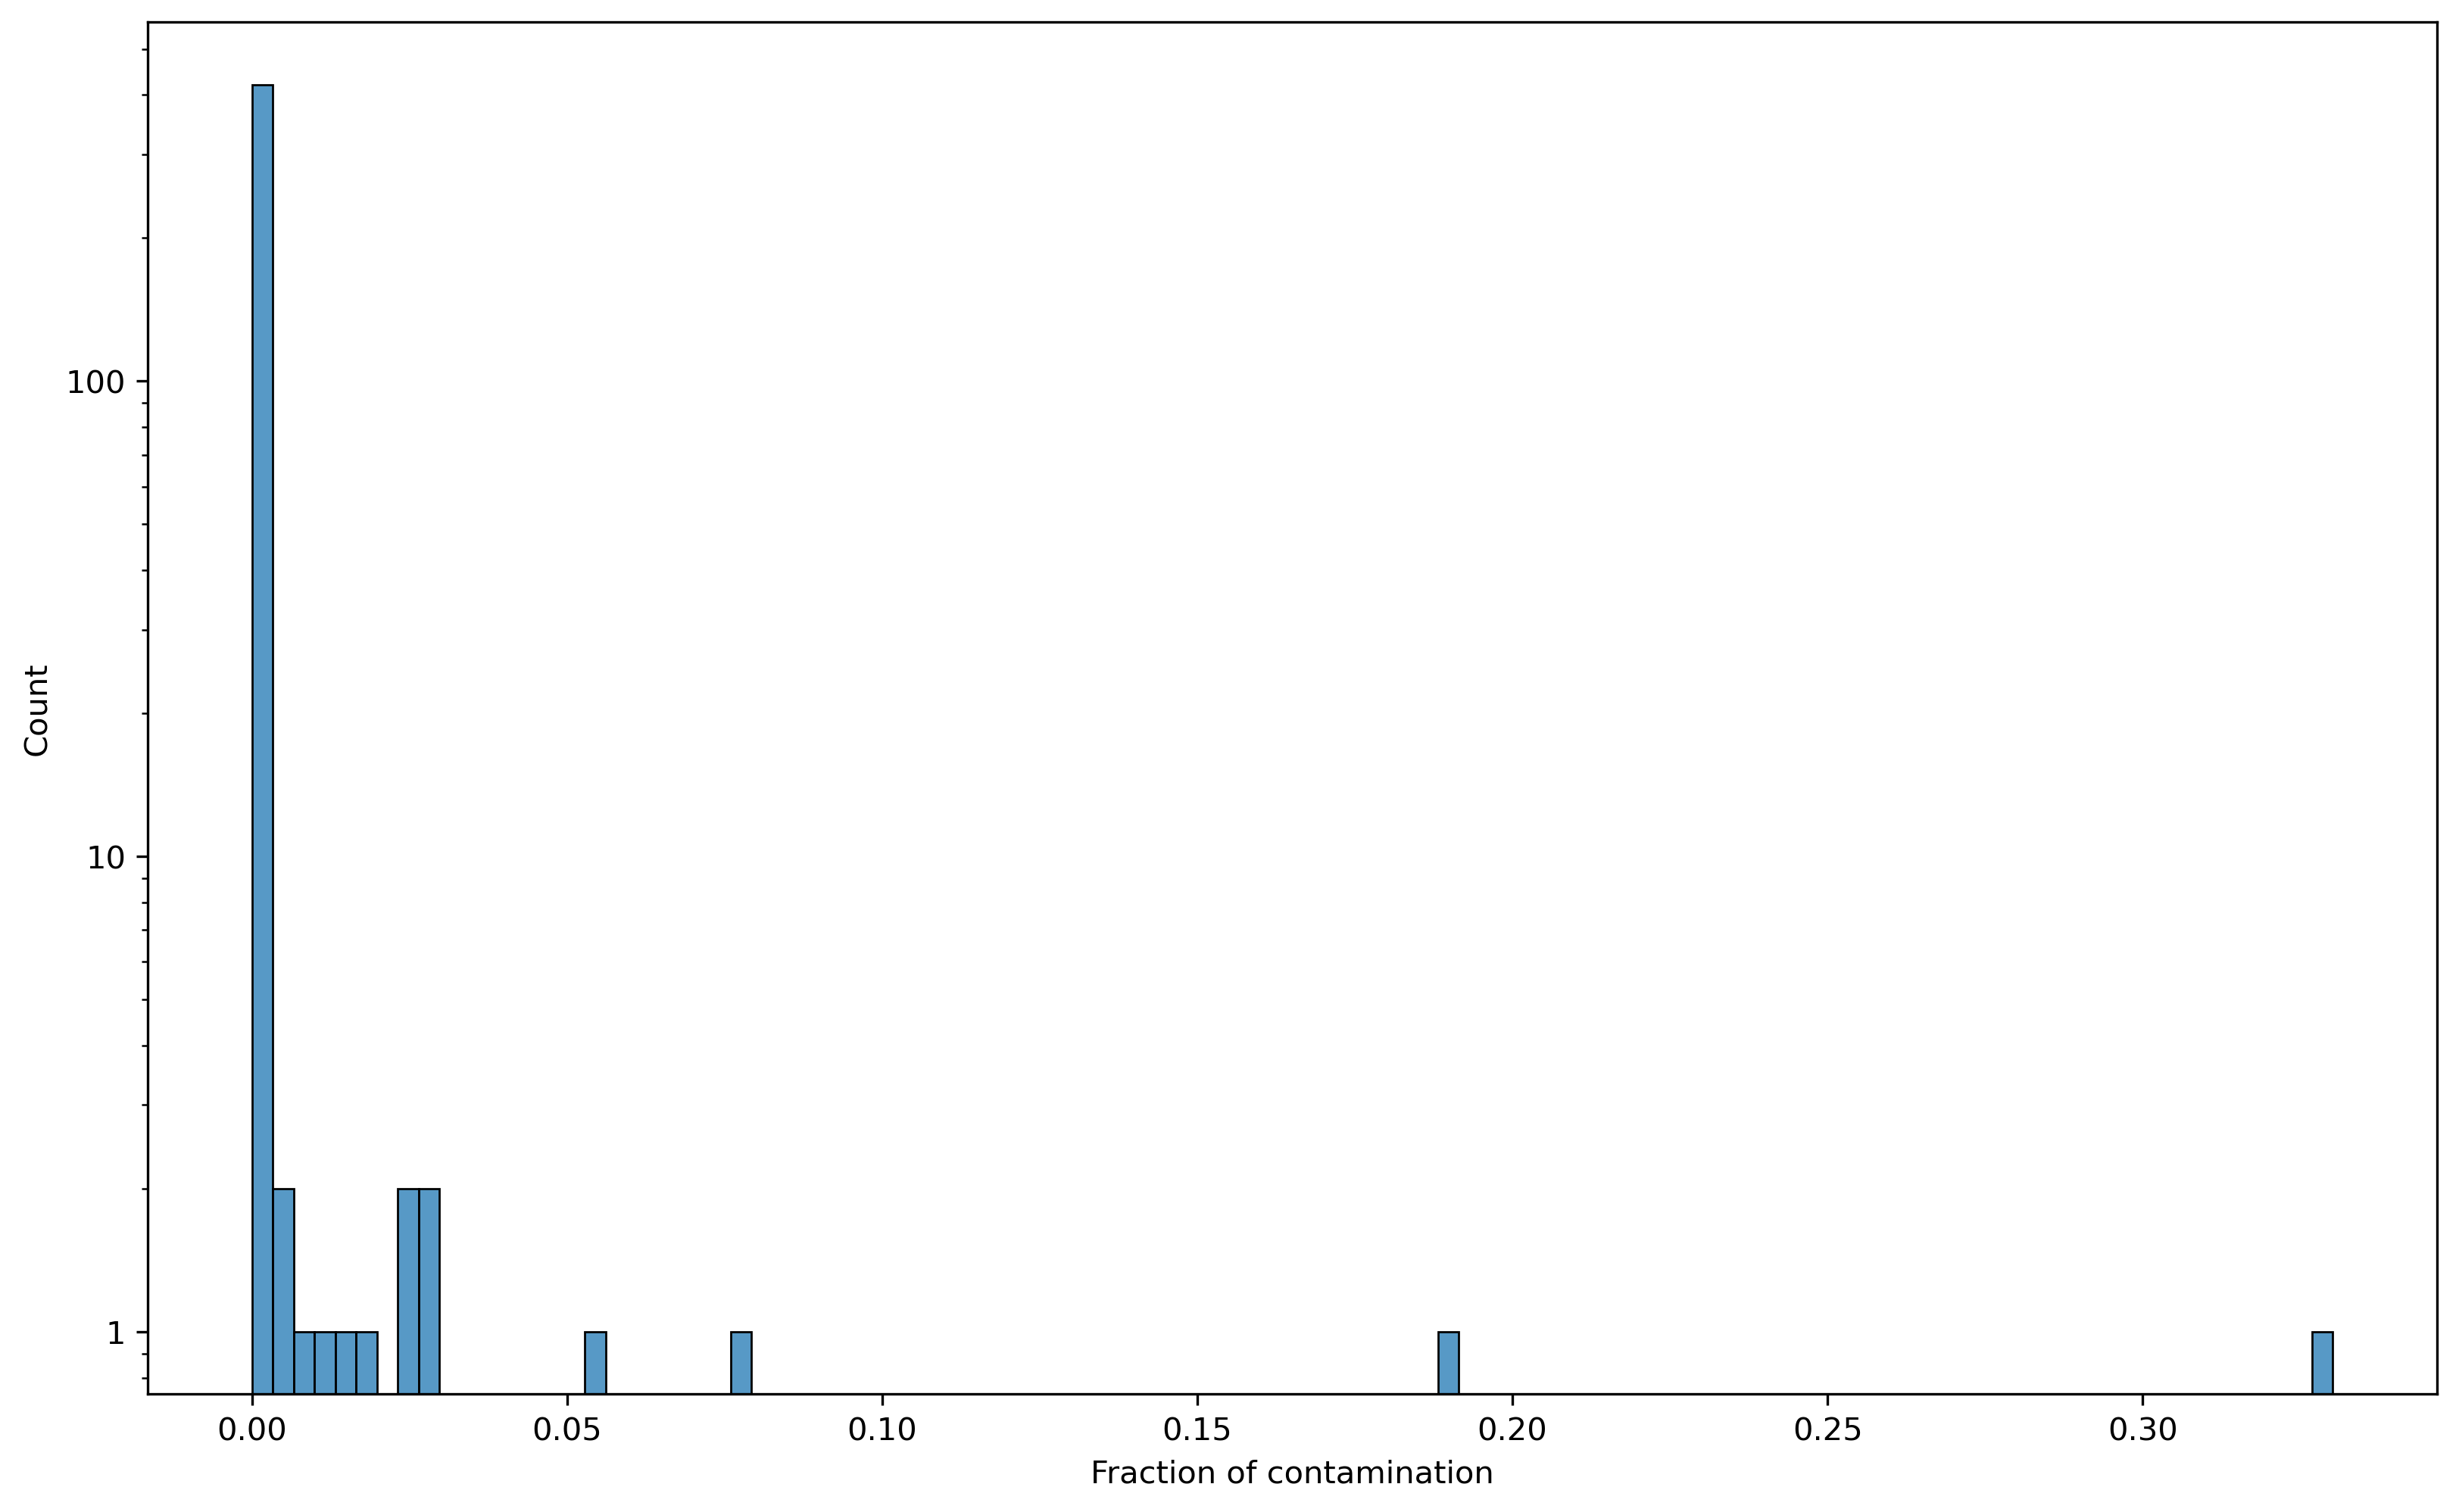

In [16]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=qc, x="f_contam", ax=ax, palette="Set2", bins=100)
ax.set_xlabel("Fraction of contamination")
ax.set_yscale("log")
ticks = [1, 10, 100]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_22097/3652863804.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=qc, x="coverage", ax=ax, palette="Set2", bins=100)


[Text(1, 0, '1'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(30, 0, '30'),
 Text(60, 0, '60'),
 Text(100, 0, '100'),
 Text(200, 0, '200'),
 Text(500, 0, '500'),
 Text(1000, 0, '1000')]

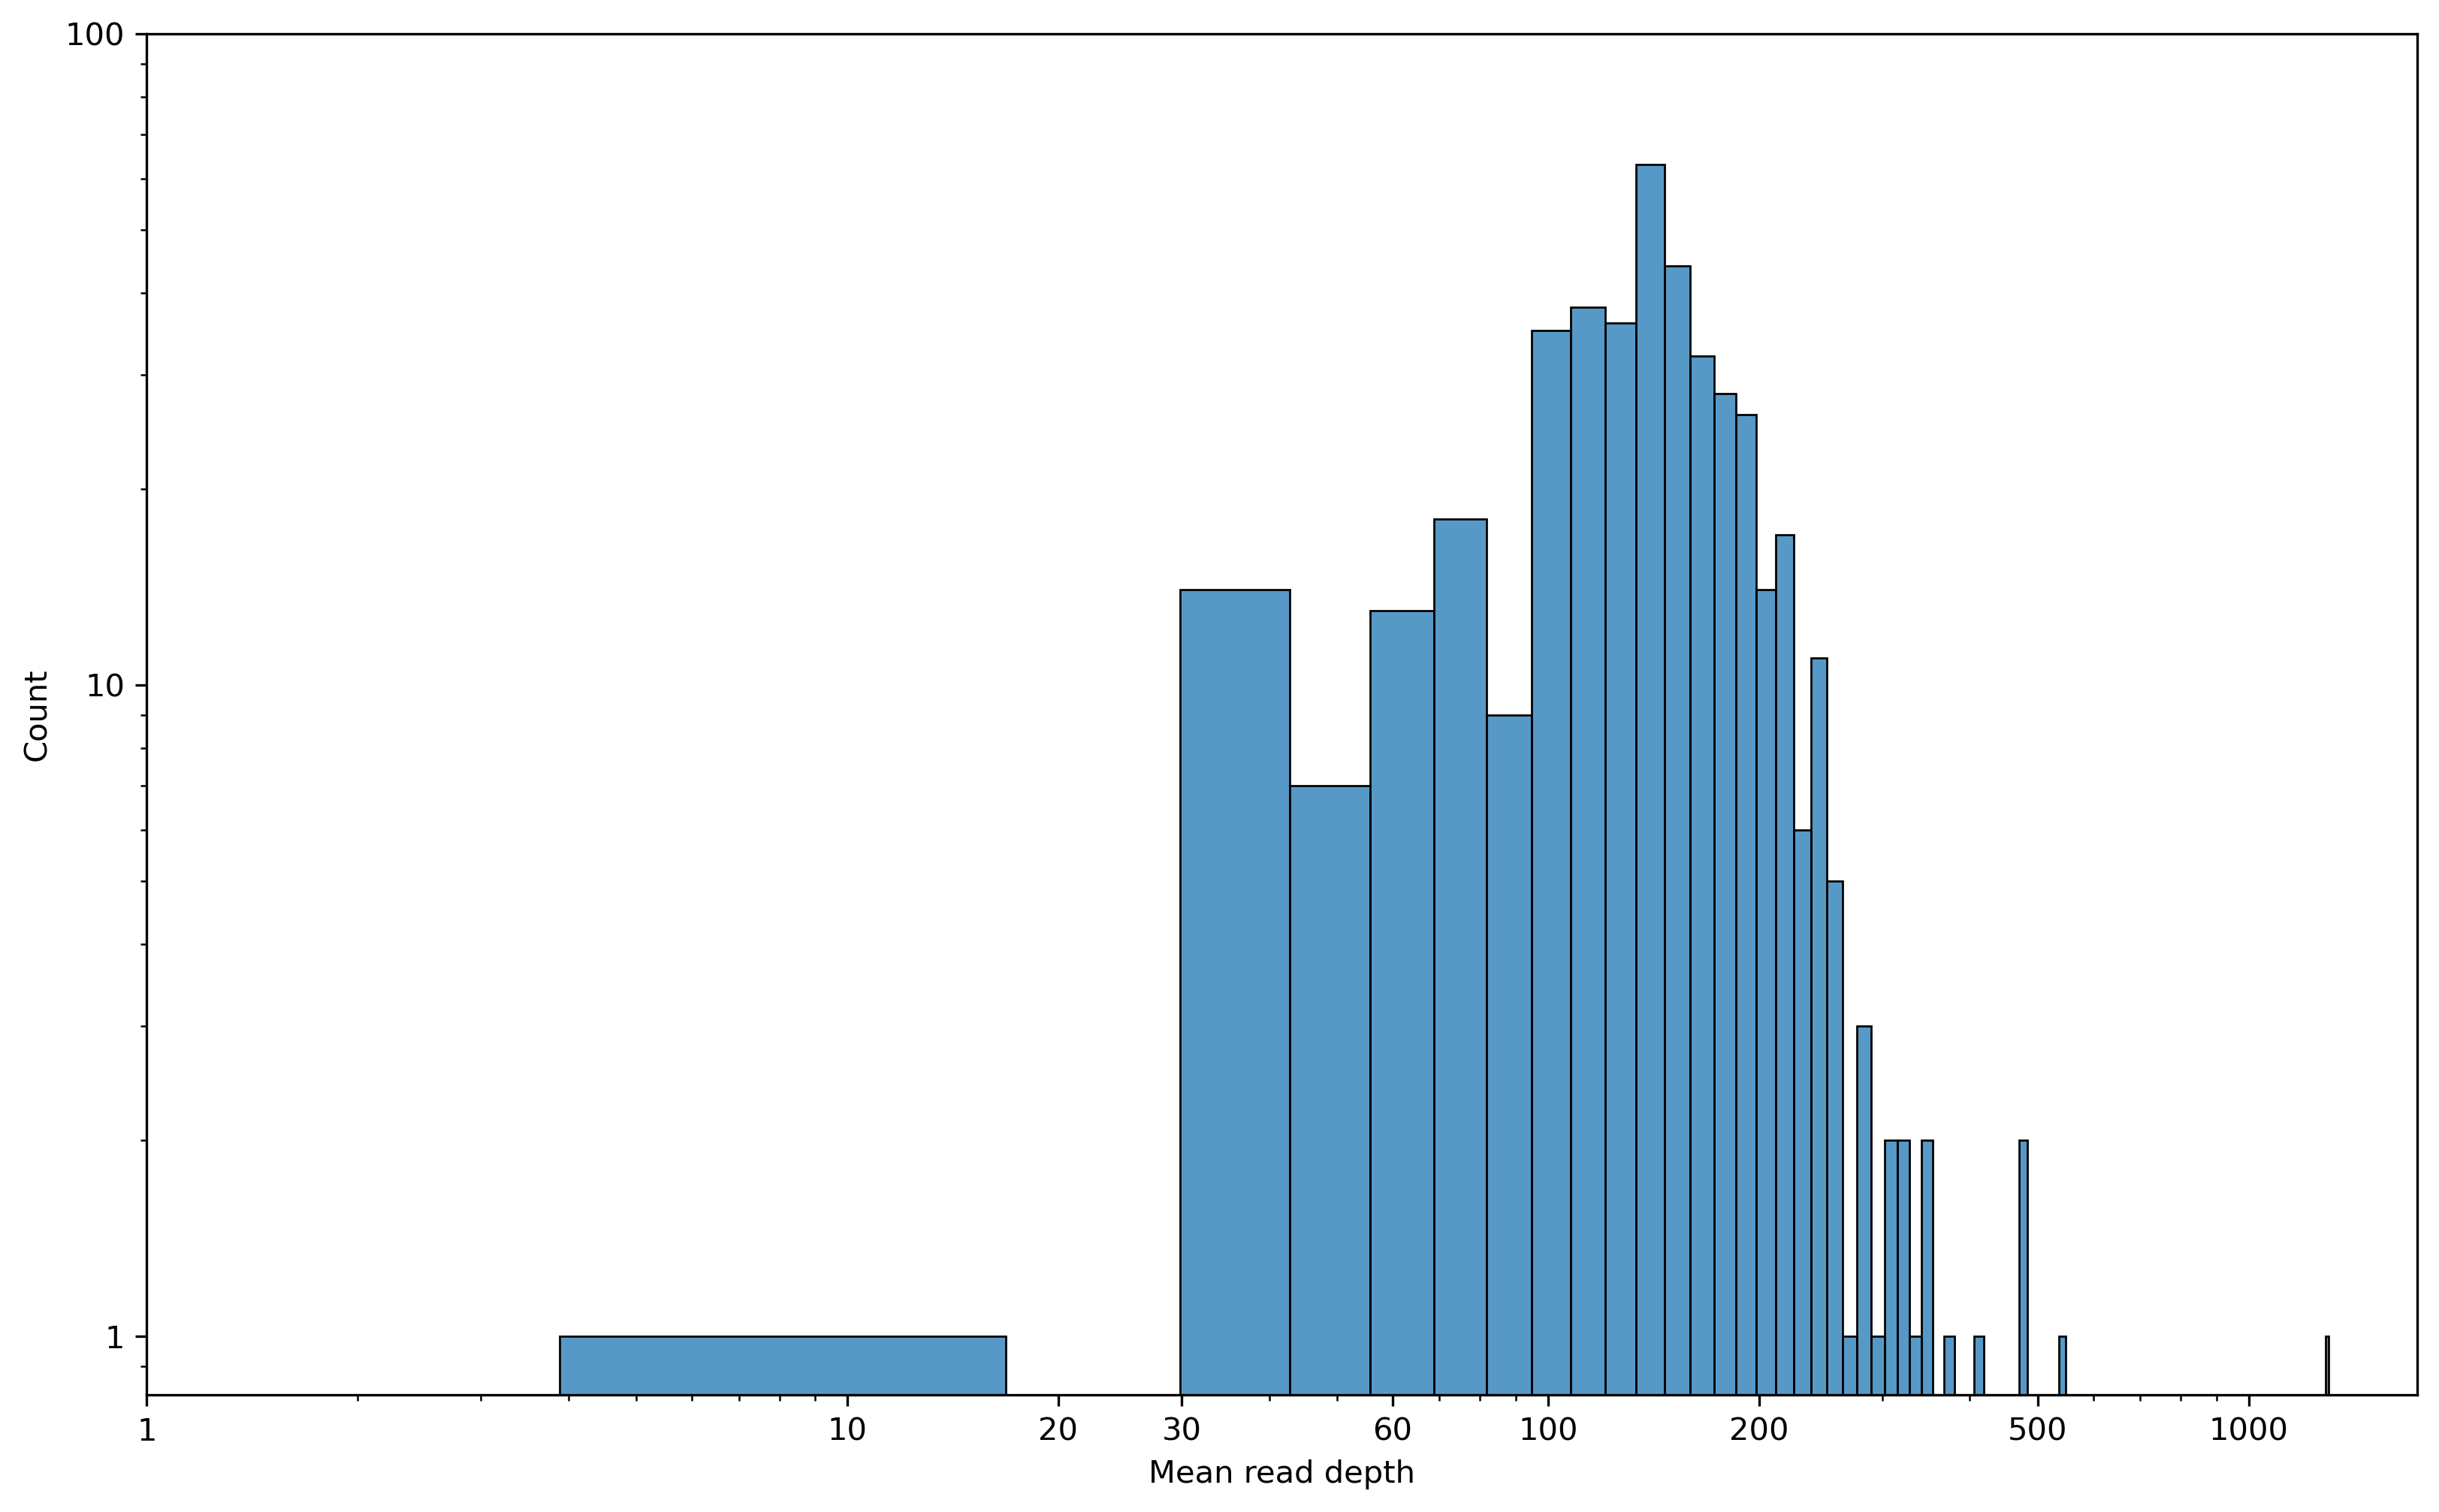

In [17]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=qc, x="coverage", ax=ax, palette="Set2", bins=100)
ax.set_xlabel("Mean read depth")
ax.set_yscale("log")
ticks = [1, 10, 100]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xscale("log")
ticks = [1, 10, 20, 30, 60, 100, 200, 500, 1000]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

In [18]:
minor_is_susceptible = False
unknown_is_resistant = False
failed_is_resistant = False
classifier = Classifier(unknown_is_resistant=unknown_is_resistant, minor_is_susceptible=minor_is_susceptible)
ignore_drugs = {"ciprofloxacin", "all"}

In [19]:
DRUGS = set(calls["drug"]) - ignore_drugs
TOOLS = set(calls["tool"])
RUNS = set(calls["run"])

In [20]:
pheno_clf = []
TECH = "nanopore"
for drug, tool, run in product(DRUGS, TOOLS, RUNS):
    try:
        ph = phenotypes.at[run, drug]
        if pd.isna(ph):
            continue
        else:
            truth = Prediction(ph)
    except KeyError:
        print(f"Warning: {run} has no phenotype column for {drug}")
        continue
    
    
    ix = (run, tool, drug)
    try:
        pred = calls.at[ix, "prediction"]
    except KeyError:
        # tbprofiler doesnt explicitly report S
        assert tool == "tbprofiler", ix
        pred = "S"
    clf = classifier.from_predictions(truth, Prediction(pred))

    pheno_clf.append((run, drug, str(clf), TECH, tool))

In [21]:
cols = ["run", "drug", "classification", "technology", "tool"]
df = pd.DataFrame(pheno_clf, columns=cols)
df

run        drug classification technology     tool
0     ERR9030343   ofloxacin             TN   nanopore  mykrobe
1     ERR9030431   ofloxacin             TN   nanopore  mykrobe
2     ERR9030485   ofloxacin             TN   nanopore  mykrobe
3     ERR9030513   ofloxacin             TN   nanopore  mykrobe
4     ERR9030420   ofloxacin             TN   nanopore  mykrobe
...          ...         ...            ...        ...      ...
1999  ERR9030475  rifampicin             TP   nanopore    drprg
2000  ERR9030477  rifampicin             TN   nanopore    drprg
2001  ERR9030252  rifampicin             TN   nanopore    drprg
2002  ERR9030434  rifampicin             TN   nanopore    drprg
2003  ERR9030326  rifampicin             TP   nanopore    drprg

[2004 rows x 5 columns]

In [22]:
min_depth = 15
min_contam = 0.05

In [23]:
valid_samples = qc.query("coverage>=@min_depth and f_contam<=@min_contam").index
df.query("run in @valid_samples", inplace=True)

In [24]:
df

run        drug classification technology     tool
0     ERR9030343   ofloxacin             TN   nanopore  mykrobe
1     ERR9030431   ofloxacin             TN   nanopore  mykrobe
2     ERR9030485   ofloxacin             TN   nanopore  mykrobe
3     ERR9030513   ofloxacin             TN   nanopore  mykrobe
4     ERR9030420   ofloxacin             TN   nanopore  mykrobe
...          ...         ...            ...        ...      ...
1999  ERR9030475  rifampicin             TP   nanopore    drprg
2000  ERR9030477  rifampicin             TN   nanopore    drprg
2001  ERR9030252  rifampicin             TN   nanopore    drprg
2002  ERR9030434  rifampicin             TN   nanopore    drprg
2003  ERR9030326  rifampicin             TP   nanopore    drprg

[2004 rows x 5 columns]

In [25]:
qc.index.difference(valid_samples)

Index(['SRR12395124', 'SRR12395219', 'SRR12395398', 'SRR12395400',
       'SRR12395456'],
      dtype='object', name='run')

In [26]:
cms = defaultdict()

for drug, tool in product(DRUGS, TOOLS):
    s = df.query("drug == @drug and technology == @TECH and tool == @tool").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    cms[(drug, TECH, tool)] = cm

In [27]:
metrics = []
for (drug, tech, tool), cm in cms.items():
    sn = cm.sensitivity()[0]
    sp = cm.specificity()[0]
    metrics.append((drug, tech, tool, sn, sp))

summary_cols = [
    "drug",
    "technology",
    "tool",
    "Sensitivity",
    "Specificity",
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "technology", "tool"], var_name="metric")

In [28]:
counts = df.groupby(["drug", "technology", "tool", "classification"])["run"].count()
table = summary.set_index(["drug", "technology", "tool", "metric"])["value"].unstack().reset_index()

for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["technology"], row["tool"])
    cm = cms[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn
    
for k in ["drug", "technology", "tool"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = ["drug", "technology", "tool", "Sensitivity", "Specificity", "TP", "TN", "FN", "FP"]
table = table[summary_cols]

In [29]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    sn = cm.sensitivity()
    sp = cm.specificity()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            row["technology"].capitalize(),
            row["tool"],
            fn_str,
            fp_str,
            ci_str(sn),
            ci_str(sp),
        )
    )
pretty_cols = [
    "Drug",
    "Technology",
    "Tool",
    "FN(R)",
    "FP(S)",
    "Sensitivity (95% CI)",
    "Specificity (95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)

In [30]:
table

Drug Technology        Tool  FN(R)   FP(S)  Sensitivity (95% CI)  \
0       Amikacin   Nanopore       Drprg  0(11)   3(78)  100.0% (74.1-100.0%)   
1       Amikacin   Nanopore     Mykrobe  0(11)   3(78)  100.0% (74.1-100.0%)   
2       Amikacin   Nanopore  Tbprofiler  0(11)   3(78)  100.0% (74.1-100.0%)   
3    Capreomycin   Nanopore       Drprg   1(1)   1(51)      0.0% (0.0-79.3%)   
4    Capreomycin   Nanopore     Mykrobe   1(1)   1(51)      0.0% (0.0-79.3%)   
5    Capreomycin   Nanopore  Tbprofiler   1(1)   1(51)      0.0% (0.0-79.3%)   
6      Delamanid   Nanopore       Drprg   0(0)    0(0)                     -   
7      Delamanid   Nanopore     Mykrobe   0(0)    0(0)                     -   
8      Delamanid   Nanopore  Tbprofiler   0(0)    0(0)                     -   
9     Ethambutol   Nanopore       Drprg  4(14)  15(77)    71.4% (45.4-88.3%)   
10    Ethambutol   Nanopore     Mykrobe  4(14)  15(77)    71.4% (45.4-88.3%)   
11    Ethambutol   Nanopore  Tbprofiler  5(14)  15(77)    64.3% (38.8-83.7%)   
12   Ethionamide   Nanopore       Drprg   0(4)    1(9)  100.0% (51.0-100.0%)   
13   Ethionamide   Nanopore     Mykrobe   0(4)    1(9)  100.0% (51.0-100.0%)   
14   Ethionamide   Nanopore  Tbprofiler   0(4)    1(9)  100.0% (51.0-100.0%)   
15     Isoniazid   Nanopore       Drprg  9(51)   3(48)    82.4% (69.7-90.4%)   
16     Isoniazid   Nanopore     Mykrobe  9(51)   4(48)    82.4% (69.7-90.4%)   
17     Isoniazid   Nanopore  Tbprofiler  9(51)   3(48)    82.4% (69.7-90.4%)   
18     Kanamycin   Nanopore       Drprg   0(0)   1(52)                     -   
19     Kanamycin   Nanopore     Mykrobe   0(0)   1(52)                     -   
20     Kanamycin   Nanopore  Tbprofiler   0(0)   1(52)                     -   
21  Levofloxacin   Nanopore       Drprg   0(0)    0(0)                     -   
22  Levofloxacin   Nanopore     Mykrobe   0(0)    0(0)                     -   
23  Levofloxacin   Nanopore  Tbprofiler   0(0)    0(0)                     -   
24     Linezolid   Nanopore       Drprg   0(0)    0(0)                     -   
25     Linezolid   Nanopore     Mykrobe   0(0)    0(0)                     -   
26     Linezolid   Nanopore  Tbprofiler   0(0)    0(0)                     -   
27  Moxifloxacin   Nanopore       Drprg   0(0)    1(1)                     -   
28  Moxifloxacin   Nanopore     Mykrobe   0(0)    1(1)                     -   
29  Moxifloxacin   Nanopore  Tbprofiler   0(0)    1(1)                     -   
30     Ofloxacin   Nanopore       Drprg  0(10)   3(77)  100.0% (72.2-100.0%)   
31     Ofloxacin   Nanopore     Mykrobe  0(10)   4(77)  100.0% (72.2-100.0%)   
32     Ofloxacin   Nanopore  Tbprofiler  0(10)   3(77)  100.0% (72.2-100.0%)   
33  Pyrazinamide   Nanopore       Drprg   0(0)    0(1)                     -   
34  Pyrazinamide   Nanopore     Mykrobe   0(0)    0(1)                     -   
35  Pyrazinamide   Nanopore  Tbprofiler   0(0)    0(1)                     -   
36    Rifampicin   Nanopore       Drprg  6(48)   2(44)    87.5% (75.3-94.1%)   
37    Rifampicin   Nanopore     Mykrobe  5(48)   1(44)    89.6% (77.8-95.5%)   
38    Rifampicin   Nanopore  Tbprofiler  5(48)   1(44)    89.6% (77.8-95.5%)   
39  Streptomycin   Nanopore       Drprg   2(8)  14(83)    75.0% (40.9-92.9%)   
40  Streptomycin   Nanopore     Mykrobe   2(8)  27(83)    75.0% (40.9-92.9%)   
41  Streptomycin   Nanopore  Tbprofiler   2(8)  12(83)    75.0% (40.9-92.9%)   

    Specificity (95% CI)  
0     96.2% (89.3-98.7%)  
1     96.2% (89.3-98.7%)  
2     96.2% (89.3-98.7%)  
3     98.0% (89.7-99.7%)  
4     98.0% (89.7-99.7%)  
5     98.0% (89.7-99.7%)  
6                      -  
7                      -  
8                      -  
9     80.5% (70.3-87.8%)  
10    80.5% (70.3-87.8%)  
11    80.5% (70.3-87.8%)  
12    88.9% (56.5-98.0%)  
13    88.9% (56.5-98.0%)  
14    88.9% (56.5-98.0%)  
15    93.8% (83.2-97.9%)  
16    91.7% (80.4-96.7%)  
17    93.8% (83.2-97.9%)  
18    98.1% (89.9-99.7%)  
19    98.1% (89.9-99.7%)  
20  

In [31]:
sn_data = []
sp_data = []
for drug, tool in product(DRUGS, TOOLS):
    s = df.query("drug == @drug and tool == @tool and technology == @TECH").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    sn = cm.sensitivity()
    sp = cm.specificity()
    sn_data.append((drug, TECH, tool, *sn))
    sp_data.append((drug, TECH, tool, *sp))
    
sn_df = pd.DataFrame(sn_data, columns=["drug", "technology", "tool", "value", "lower", "upper"])
sp_df = pd.DataFrame(sp_data, columns=["drug", "technology", "tool", "value", "lower", "upper"])

In [32]:
DRUGS

{'amikacin',
 'capreomycin',
 'delamanid',
 'ethambutol',
 'ethionamide',
 'isoniazid',
 'kanamycin',
 'levofloxacin',
 'linezolid',
 'moxifloxacin',
 'ofloxacin',
 'pyrazinamide',
 'rifampicin',
 'streptomycin'}

In [33]:
sn_df

drug technology        tool     value     lower     upper
0      ofloxacin   nanopore     mykrobe  1.000000  0.722467  1.000000
1      ofloxacin   nanopore  tbprofiler  1.000000  0.722467  1.000000
2      ofloxacin   nanopore       drprg  1.000000  0.722467  1.000000
3       amikacin   nanopore     mykrobe  1.000000  0.741167  1.000000
4       amikacin   nanopore  tbprofiler  1.000000  0.741167  1.000000
5       amikacin   nanopore       drprg  1.000000  0.741167  1.000000
6     ethambutol   nanopore     mykrobe  0.714286  0.453509  0.882786
7     ethambutol   nanopore  tbprofiler  0.642857  0.387644  0.836553
8     ethambutol   nanopore       drprg  0.714286  0.453509  0.882786
9    capreomycin   nanopore     mykrobe  0.000000  0.000000  0.793451
10   capreomycin   nanopore  tbprofiler  0.000000  0.000000  0.793451
11   capreomycin   nanopore       drprg  0.000000  0.000000  0.793451
12     delamanid   nanopore     mykrobe       NaN       NaN       NaN
13     delamanid   nanopore  tbprofiler       NaN       NaN       NaN
14     delamanid   nanopore       drprg       NaN       NaN       NaN
15     linezolid   nanopore     mykrobe       NaN       NaN       NaN
16     linezolid   nanopore  tbprofiler       NaN       NaN       NaN
17     linezolid   nanopore       drprg       NaN       NaN       NaN
18     kanamycin   nanopore     mykrobe       NaN       NaN       NaN
19     kanamycin   nanopore  tbprofiler       NaN       NaN       NaN
20     kanamycin   nanopore       drprg       NaN       NaN       NaN
21  moxifloxacin   nanopore     mykrobe       NaN       NaN       NaN
22  moxifloxacin   nanopore  tbprofiler       NaN       NaN       NaN
23  moxifloxacin   nanopore       drprg       NaN       NaN       NaN
24     isoniazid   nanopore     mykrobe  0.823529  0.697459  0.904276
25     isoniazid   nanopore  tbprofiler  0.823529  0.697459  0.904276
26     isoniazid   nanopore       drprg  0.823529  0.697459  0.904276
27  streptomycin   nanopore     mykrobe  0.750000  0.409275  0.928521
28  streptomycin   nanopore  tbprofiler  0.750000  0.409275  0.928521
29  streptomycin   nanopore       drprg  0.750000  0.409275  0.928521
30   ethionamide   nanopore     mykrobe  1.000000  0.510109  1.000000
31   ethionamide   nanopore  tbprofiler  1.000000  0.510109  1.000000
32   ethionamide   nanopore       drprg  1.000000  0.510109  1.000000
33  pyrazinamide   nanopore     mykrobe       NaN       NaN       NaN
34  pyrazinamide   nanopore  tbprofiler       NaN       NaN       NaN
35  pyrazinamide   nanopore       drprg       NaN       NaN       NaN
36    rifampicin   nanopore     mykrobe  0.895833  0.778326  0.954678
37    rifampicin   nanopore  tbprofiler  0.895833  0.778326  0.954678
38    rifampicin   nanopore       drprg  0.875000  0.752995  0.941429
39  levofloxacin   nanopore     mykrobe       NaN       NaN       NaN
40  levofloxacin   nanopore  tbprofiler       NaN       NaN       NaN
41  levofloxacin   nanopore       drprg       NaN       NaN       NaN

In [34]:
summary

drug technology        tool       metric     value
0      ofloxacin   nanopore     mykrobe  Sensitivity  1.000000
1      ofloxacin   nanopore  tbprofiler  Sensitivity  1.000000
2      ofloxacin   nanopore       drprg  Sensitivity  1.000000
3       amikacin   nanopore     mykrobe  Sensitivity  1.000000
4       amikacin   nanopore  tbprofiler  Sensitivity  1.000000
..           ...        ...         ...          ...       ...
79    rifampicin   nanopore  tbprofiler  Specificity  0.977273
80    rifampicin   nanopore       drprg  Specificity  0.954545
81  levofloxacin   nanopore     mykrobe  Specificity       NaN
82  levofloxacin   nanopore  tbprofiler  Specificity       NaN
83  levofloxacin   nanopore       drprg  Specificity       NaN

[84 rows x 5 columns]

In [35]:
DRUGS

{'amikacin',
 'capreomycin',
 'delamanid',
 'ethambutol',
 'ethionamide',
 'isoniazid',
 'kanamycin',
 'levofloxacin',
 'linezolid',
 'moxifloxacin',
 'ofloxacin',
 'pyrazinamide',
 'rifampicin',
 'streptomycin'}

In [36]:
s = """AMK amikacin
CAP capreomycin
DLM delamanid
EMB ethambutol
ETO ethionamide
INH isoniazid
KAN kanamycin
LFX levofloxacin
LZD linezolid
MFX moxifloxacin
OFX ofloxacin
PZA pyrazinamide
RIF rifampicin
STM streptomycin"""
long2short = dict()
for line in s.splitlines():
    ab, d = line.split()
    long2short[d.capitalize()] = ab
    
short2long = dict()
for line in s.splitlines():
    ab, d = line.split()
    short2long[ab] = d.capitalize()
    
first_line = [short2long[d] for d in ["INH", "RIF", "EMB", "PZA"]]
fluoroquinolones = [short2long[d] for d in ["LFX", "MFX", "OFX"]]  # group A - have excluded ciprofloxacin
macrolides = [short2long[d] for d in ["AMK", "CAP", "KAN", "STM"]] # group B - second-line injectables
other =  [short2long[d] for d in ["ETO", "LZD", "DLM"]]# group C and D
drug_order = [*first_line, *fluoroquinolones, *macrolides, *other]

In [37]:
from collections import Counter

def sort_drugs(a):
    xs = list(map(str.lower, drug_order))
    out = []
    c = Counter()
    for x in a:
        i = xs.index(x)
        d = xs[i]
        c[d] += 1
        out.append((i, c[d]))
    return out

In [38]:
sn_df = sn_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)
sp_df = sp_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)

In [39]:
import matplotlib.lines as mlines
from matplotlib.colors import to_rgba
from matplotlib.ticker import ScalarFormatter
plt.style.use("ggplot")

/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_22097/3070044933.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


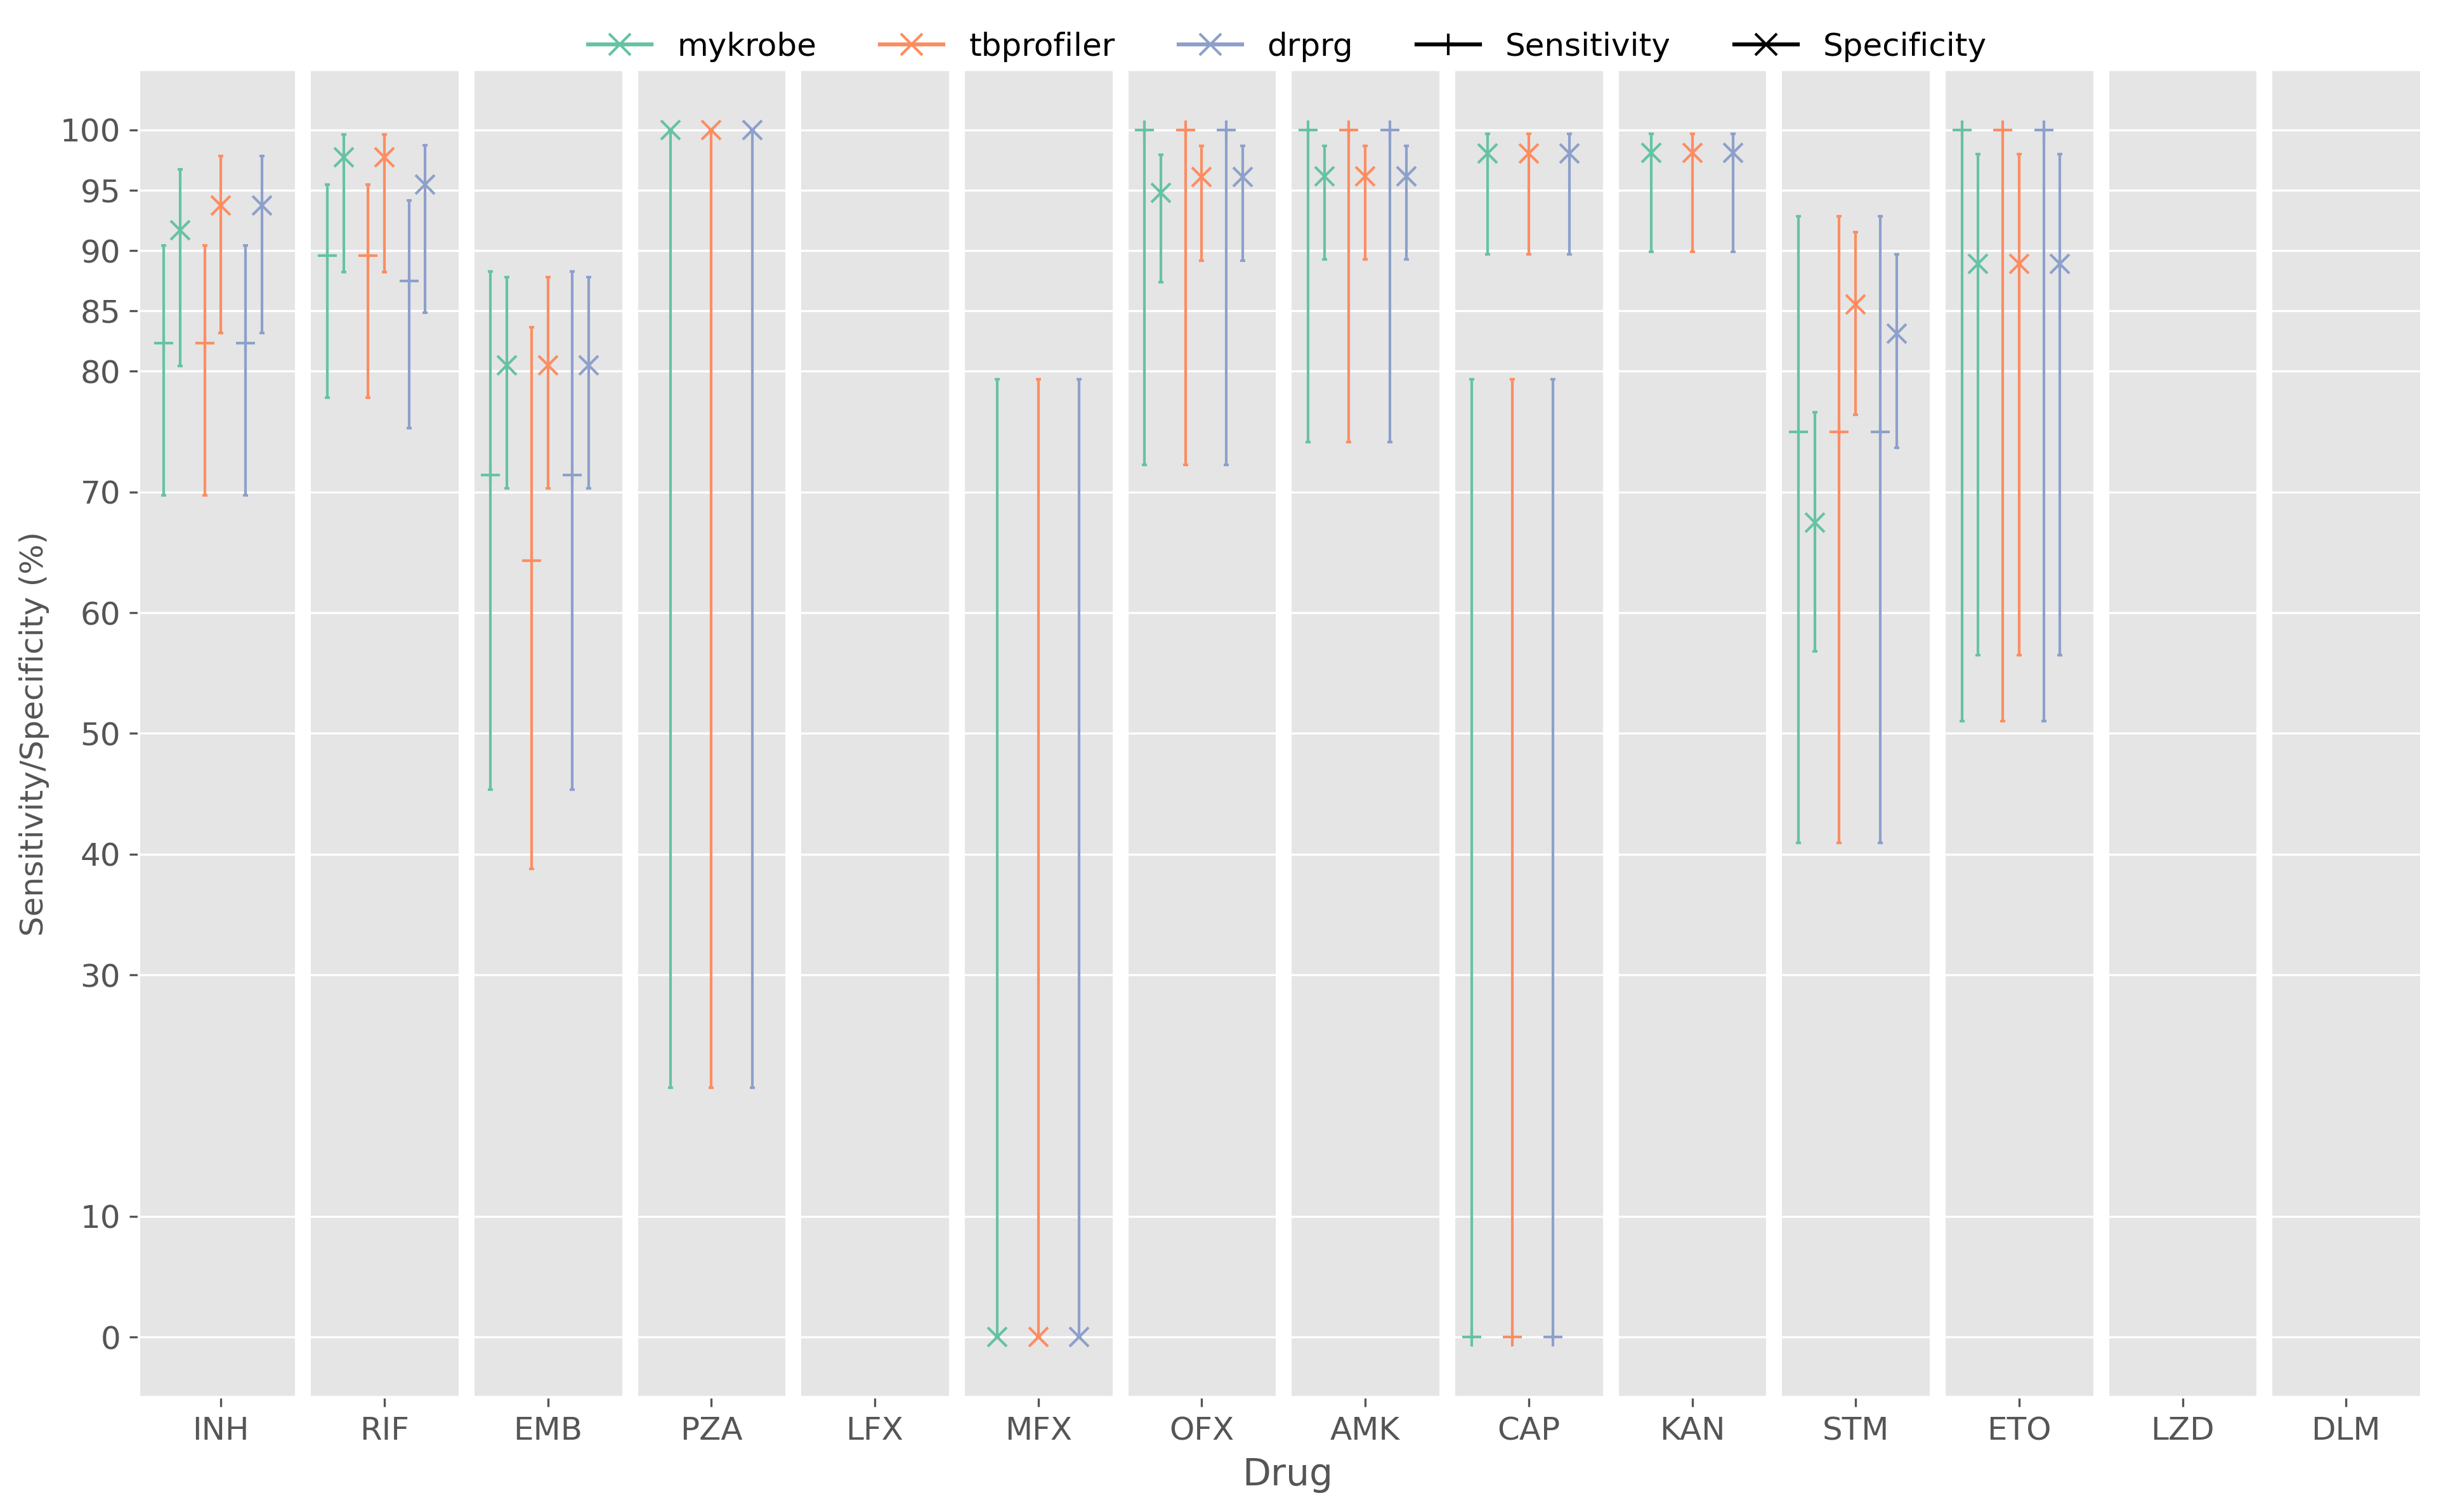

In [59]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300, tight_layout=True)
dodge = 0.1
all_positions = []
i = -1
leghandles = []
sn_marker = "+"
epsilon = 0.05
elw = 1
capsize = 1
rotate = 0
bar_width = 0.2
fs = 12
marker_size = 7
sp_marker = "x"
edge_alpha = 0.7
edgecol = to_rgba("black", alpha=edge_alpha)
leg_marker_size = 8
cmap = plt.get_cmap("Set2").colors
for tool in TOOLS:

    i += 1
    
    positions = [(p-1) + ((bar_width + epsilon) * i) for p in np.arange(len(DRUGS))]
        
    all_positions.append(positions)
    
    colour = mpl.colors.to_rgba(cmap[i], alpha=1.0)
    label = tool

    tool_sp_df = sp_df.query("tool==@tool")
    sp_ys = tool_sp_df["value"] * 100
    sp_lb = sp_ys - tool_sp_df["lower"] * 100
    sp_ub = tool_sp_df["upper"] * 100 - sp_ys
    sp_ub = [min(100, x) for x in sp_ub]

    
    plotprops = dict(
        label=label, 
        color=colour, 
        capsize=capsize, 
        elinewidth=elw,
        mec=colour,
        markersize=marker_size,
    )
    
    sp_bar = ax.errorbar(
        x=positions, 
        y=sp_ys,
        yerr=[sp_lb, sp_ub],
        fmt=sp_marker,
        **plotprops
    )
    
    tool_sn_df = sn_df.query("tool==@tool")
    sn_ys = tool_sn_df["value"] * 100
    sn_lb = sn_ys - tool_sn_df["lower"] * 100
    sn_ub = tool_sn_df["upper"] * 100 - sn_ys


    
    sn_bar = ax.errorbar(
        x=[p - dodge for p in positions], 
        y=sn_ys,
        yerr=[sn_lb, sn_ub],
        fmt=sn_marker,
        **plotprops
    )
    
    h = mlines.Line2D([], [], color=cmap[i], marker=sp_marker,
                      markersize=leg_marker_size, label=label)
    leghandles.append(h)
    
labels = [long2short[d] for d in drug_order]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=rotate, fontsize=fs)
ax.set_ylabel("Sensitivity/Specificity (%)")
# ax.set_yscale("logit", nonpositive="clip")
# yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, ]
yticks = [0, 10, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100]
ax.set_yticklabels(yticks)

ax.set_yticks(yticks)
for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.set_xticks(label_pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, fontsize=fs)
ax.tick_params("both", labelsize=fs)




leghandles.append(mlines.Line2D([], [], color="black", marker=sn_marker,
                          markersize=leg_marker_size, label="Sensitivity"))
leghandles.append(mlines.Line2D([], [], color="black", marker=sp_marker,
                          markersize=leg_marker_size, label="Specificity"))

legend_props = dict(
    loc="upper center", 
    prop=dict(size=fs), 
    frameon=False, 
#     title_fontproperties=dict(size=fs-1, weight="bold"),
#     shadow=True,
    ncol=len(leghandles),
#     fancybox=True
)
ax.legend(handles=leghandles, bbox_to_anchor=(0.5, 1.05), **legend_props)
# axS.legend(leghandles[-2:], leglabels[-2:], title="Walker et al.", bbox_to_anchor=(1, 0.68), **legend_props)

ax.grid(False, axis="x",)
# draw line between drug bars
for xpos in all_positions[-1]:
    vpos = xpos+epsilon+bar_width
    ax.axvline(vpos, color="white", linestyle="-", alpha=1, linewidth=6)
    
xlim = (all_positions[0][0]-(epsilon+bar_width), vpos+(epsilon))
ax.set_xlim(xlim)
_ = ax.set_xlabel("Drug", fontsize=fs+2)

In [93]:
help(ax.set_yscale)

Help on method set_yscale in module matplotlib.axes._base:

set_yscale(value, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the y-axis scale.
    
    Parameters
    ----------
    value : {"linear", "log", "symlog", "logit", ...} or `.ScaleBase`
        The axis scale type to apply.
    
    **kwargs
        Different keyword arguments are accepted, depending on the scale.
        See the respective class keyword arguments:
    
        - `matplotlib.scale.LinearScale`
        - `matplotlib.scale.LogScale`
        - `matplotlib.scale.SymmetricalLogScale`
        - `matplotlib.scale.LogitScale`
        - `matplotlib.scale.FuncScale`
    
    Notes
    -----
    By default, Matplotlib supports the above mentioned scales.
    Additionally, custom scales may be registered using
    `matplotlib.scale.register_scale`. These scales can then also
    be used here.



In [397]:
np.__version__

'1.23.0'

In [398]:
pd.__version__

'1.4.3'

In [399]:
import scipy
scipy.__version__

'1.8.1'

## Looking at whether building PRG from AMR samples would be better

In [22]:
effects = pd.read_csv("EFFECTS.csv.gz", low_memory=False)

In [30]:
effects.query("PREDICTION=='R'", inplace=True)

In [24]:
from collections import Counter

In [31]:
drug_counts = dict()
for drug in set(effects["DRUG"]):
    df = effects.query("DRUG==@drug")
    gene_muts = [(g, m) for g, m in zip(df["GENE"], df["MUTATION"])]
    drug_counts[drug] = Counter(gene_muts)

In [32]:
drug_counts

{'LZD': Counter({('rplC', 'C154R'): 208}),
 'MXF': Counter({('gyrA', 'D94G'): 18690,
          ('gyrA', 'A90V'): 12264,
          ('gyrA', 'D94Y'): 1525,
          ('gyrA', 'D94A'): 4844,
          ('gyrA', 'D94N'): 3675,
          ('gyrA', 'S91P'): 3052,
          ('gyrA', 'D94H'): 500,
          ('gyrA', 'G88C'): 136}),
 'PZA': Counter({('pncA', 'C14R'): 1648,
          ('pncA', 'K96M'): 12,
          ('pncA', 'P62L'): 252,
          ('pncA', 'T160P'): 360,
          ('pncA', 'V139G'): 427,
          ('pncA', 'L116R'): 70,
          ('pncA', 'T76P'): 1344,
          ('pncA', 'G132D'): 329,
          ('pncA', 'a-11g'): 4512,
          ('pncA', 'V7G'): 553,
          ('pncA', 'W68L'): 48,
          ('pncA', 'L27P'): 2422,
          ('pncA', 'L156P'): 144,
          ('pncA', 'D8E'): 144,
          ('pncA', 'F13V'): 42,
          ('pncA', 'V128G'): 252,
          ('pncA', 'H71Q'): 70,
          ('pncA', 'A146V'): 642,
          ('pncA', 'M175V'): 392,
          ('pncA', 'D49N'): 259,
   

In [34]:
for drug, counts in drug_counts.items():
    print(drug)
    print(counts.most_common(50))
    print("-----")

LZD
[(('rplC', 'C154R'), 208)]
-----
MXF
[(('gyrA', 'D94G'), 18690), (('gyrA', 'A90V'), 12264), (('gyrA', 'D94A'), 4844), (('gyrA', 'D94N'), 3675), (('gyrA', 'S91P'), 3052), (('gyrA', 'D94Y'), 1525), (('gyrA', 'D94H'), 500), (('gyrA', 'G88C'), 136)]
-----
PZA
[(('pncA', 'a-11g'), 4512), (('pncA', 'Q10P'), 3672), (('pncA', 'H57D'), 3496), (('pncA', 'L27P'), 2422), (('pncA', 'G132A'), 2004), (('pncA', 'C14R'), 1648), (('pncA', 'D49G'), 1400), (('pncA', 'Q141P'), 1368), (('pncA', 'T76P'), 1344), (('pncA', 'Q10R'), 1338), (('pncA', 'H51R'), 1314), (('pncA', 'W68G'), 1225), (('pncA', 'V139A'), 1170), (('rpsA', 'V260I'), 1162), (('pncA', 'H71Y'), 976), (('pncA', 'S104R'), 896), (('pncA', 'T135P'), 888), (('pncA', 'H57R'), 872), (('pncA', 'G97D'), 856), (('pncA', 'D12A'), 840), (('pncA', 'Y103!'), 826), (('pncA', 'L4S'), 714), (('pncA', 'L172P'), 696), (('pncA', 'D8N'), 693), (('pncA', 'K48T'), 679), (('pncA', 'A146V'), 642), (('pncA', 'W68R'), 624), (('pncA', 'V125G'), 608), (('pncA', 'K96T'

In [36]:
    df = effects.query("DRUG=='RIF'")
    for u, g, m in zip(df["UNIQUEID"], df["GENE"], df["MUTATION"]):
        if g == "rpoB" and m[:4] == "L452":
            print(u)

site.02.subj.0168.lab.2013232003.iso.1
site.02.subj.0880.lab.22A114.iso.1
site.02.subj.0916.lab.22A151.iso.1
site.02.subj.0979.lab.22A219.iso.1
site.02.subj.0530.lab.241139-14.iso.1
site.02.subj.0125.lab.22A079.iso.1
site.02.subj.1190.lab.2015291005.iso.1
site.02.subj.0141.lab.2013232142.iso.1
site.02.subj.0943.lab.22A178.iso.1
site.05.subj.PSLM-0772.lab.SLM-026.iso.1
site.05.subj.PMOP-0517.lab.MOP-033.iso.1
site.05.subj.PMFR-0748.lab.MFR-256.iso.1
site.05.subj.PMFR-0710.lab.MFR-164.iso.1
site.05.subj.PMFR-0704.lab.MFR-138.iso.1
site.08.subj.28TB-D13-004.lab.2573.iso.1
site.08.subj.02TB2322.lab.25789.iso.1
site.08.subj.02TB2346.lab.26277.iso.1
site.08.subj.02TB1295.lab.19778.iso.1
site.08.subj.28TB-D15-001.lab.3002.iso.1
site.08.subj.02TB1968.lab.22328.iso.1
site.08.subj.02TB1968.lab.21702.iso.1
site.27.subj.HCMC2104.lab.25789.iso.1
site.27.subj.HCMC2124.lab.26277.iso.1
site.27.subj.HCMC2010.lab.20226.iso.1
site.11.subj.MDR052.lab.SWE-40.iso.1
site.11.subj.MDR079.lab.SWE-62.iso.1
site.

In [35]:
df

UNIQUEID DRUG  GENE  \
12                       site.02.subj.0958.lab.22A197.iso.1  EMB  embB   
360                      site.02.subj.0918.lab.22A153.iso.1  EMB  embB   
738                  site.02.subj.1033.lab.2013185075.iso.1  EMB  embB   
782                  site.02.subj.0739.lab.2013221518.iso.1  EMB  embB   
1240                     site.02.subj.0104.lab.22A057.iso.1  EMB  embB   
...                                                     ...  ...   ...   
36342802  site.10.subj.SATRL0115669_S18.lab.TRL0115669_S...  EMB  embB   
36342910       site.10.subj.XD01227882.lab.XD01227882.iso.1  EMB  embB   
36343009       site.10.subj.WG00269790.lab.WG00269790.iso.1  EMB  embB   
36343110       site.10.subj.YA00008913.lab.YA00008913.iso.1  EMB  embB   
36343335       site.10.subj.YA00166043.lab.YA00166043.iso.1  EMB  embB   

         MUTATION CATALOGUE_NAME CATALOGUE_VERSION CATALOGUE_GRAMMAR SITEID  \
12          M306I        CRyPTIC             v1.31             GARC1     02   
360         Q497R        CRyPTIC             v1.31             GARC1     02   
738         Q497R        CRyPTIC             v1.31             GARC1     02   
782         G406D        CRyPTIC             v1.31             GARC1     02   
1240        M306I        CRyPTIC             v1.31             GARC1     02   
...           ...            ...               ...               ...    ...   
36342802    M306V        CRyPTIC              v1.4             GARC1     10   
36342910    D328Y        CRyPTIC              v1.4             GARC1     10   
36343009    M306V        CRyPTIC              v1.4             GARC1     10   
36343110    M306V        CRyPTIC              v1.4             GARC1     10   
36343335    M306I        CRyPTIC              v1.4             GARC1     10   

         PREDICTION  DEFAULT_CATALOGUE  
12                R               True  
360               R               True  
738               R               True  
782               R               True  
1240              R               True  
...             ...                ...  
36342802          R              False  
36342910          R              False  
36343009          R              False  
36343110          R              False  
36343335          R              False  

[113277 rows x 10 columns]

In [60]:
df = pd.read_csv("../../config/nanopore.samplesheet.csv", low_memory=False, index_col="run")

In [63]:
df.melt(id_vars=["bioproject", "biosample"], var_name="drug", value_name="phenotype")

bioproject      biosample           drug phenotype
0      PRJEB49093  SAMEA13188784       amikacin         S
1      PRJEB49093  SAMEA13188702       amikacin       NaN
2      PRJEB49093  SAMEA13188661       amikacin       NaN
3      PRJEB49093  SAMEA13188780       amikacin         R
4      PRJEB49093  SAMEA13188719       amikacin         S
...           ...            ...            ...       ...
5650  PRJNA720906   SAMN18521323  thioacetazone       NaN
5651  PRJNA720906   SAMN18521322  thioacetazone       NaN
5652  PRJNA720906   SAMN18521321  thioacetazone       NaN
5653  PRJNA720906   SAMN18521320  thioacetazone       NaN
5654  PRJNA720906   SAMN18521315  thioacetazone       NaN

[5655 rows x 4 columns]

## Plot benchmark

In [12]:
df = pd.read_csv("../../results/benchmark/predict/illumina.summary.csv")

In [13]:
df

techology        tool         run         s    h:m:s  max_rss  max_vms  \
0     illumina     mykrobe  ERR4814939   90.7987  0:01:30  1538.21  1984.43   
1     illumina       drprg  ERR4814939   65.4921  0:01:05    29.01   238.95   
2     illumina  tbprofiler  ERR4814939  113.6742  0:01:53   617.26  2118.10   
3     illumina     mykrobe  ERR4813774  145.7175  0:02:25  1539.98  1984.33   
4     illumina       drprg  ERR4813774  146.7154  0:02:26    45.54   245.07   
...        ...         ...         ...       ...      ...      ...      ...   
1195  illumina       drprg  ERR4814746   53.8785  0:00:53    26.56   239.17   
1196  illumina  tbprofiler  ERR4814746  100.5913  0:01:40   706.12  2147.55   
1197  illumina     mykrobe  ERR4799359  179.3203  0:02:59  1537.97  1984.29   
1198  illumina       drprg  ERR4799359  138.1085  0:02:18   110.57   742.05   
1199  illumina  tbprofiler  ERR4799359  198.4135  0:03:18  1339.46  2345.32   

      max_uss  max_pss    io_in   io_out  mean_load  cpu_time  
0     1531.83  1534.46   641.38   425.58     105.59     28.86  
1       27.32    28.46   313.36   242.18      36.62      1.18  
2      602.75   604.12   957.04   786.72      24.26     24.89  
3     1533.56  1536.20   766.16   425.88     111.93     68.50  
4       41.84    43.34   419.81   242.56      77.90     71.13  
...       ...      ...      ...      ...        ...       ...  
1195    24.35    25.62   229.49   236.64      51.10     12.84  
1196   686.18   687.67   804.76   634.46      24.87      4.23  
1197  1531.62  1534.21   749.56   426.12      90.32     69.94  
1198   104.57   106.63   403.10   242.52      82.84     77.58  
1199  1320.79  1322.50  1864.53  1578.71     103.31     61.82  

[1200 rows x 13 columns]

In [14]:
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from statannotations.Annotator import Annotator

In [16]:
plt.style.use("ggplot")

In [17]:
def legend_without_duplicate_labels(ax, title=""):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), title=title, fontsize=fs)

p-value annotation legend:
      ns: p <= 1.00e+00
$p\leq0.05$: 1.00e-02 < p <= 5.00e-02
$p\leq0.01$: 1.00e-03 < p <= 1.00e-02
$p\leq0.001$: 1.00e-04 < p <= 1.00e-03
$p\leq0.0001$: p <= 1.00e-04

drprg vs. mykrobe: Wilcoxon test (paired samples), P_val:2.730e-67 Stat=0.000e+00
mykrobe vs. tbprofiler: Wilcoxon test (paired samples), P_val:4.643e-01 Stat=3.841e+04
drprg vs. tbprofiler: Wilcoxon test (paired samples), P_val:2.730e-67 Stat=0.000e+00


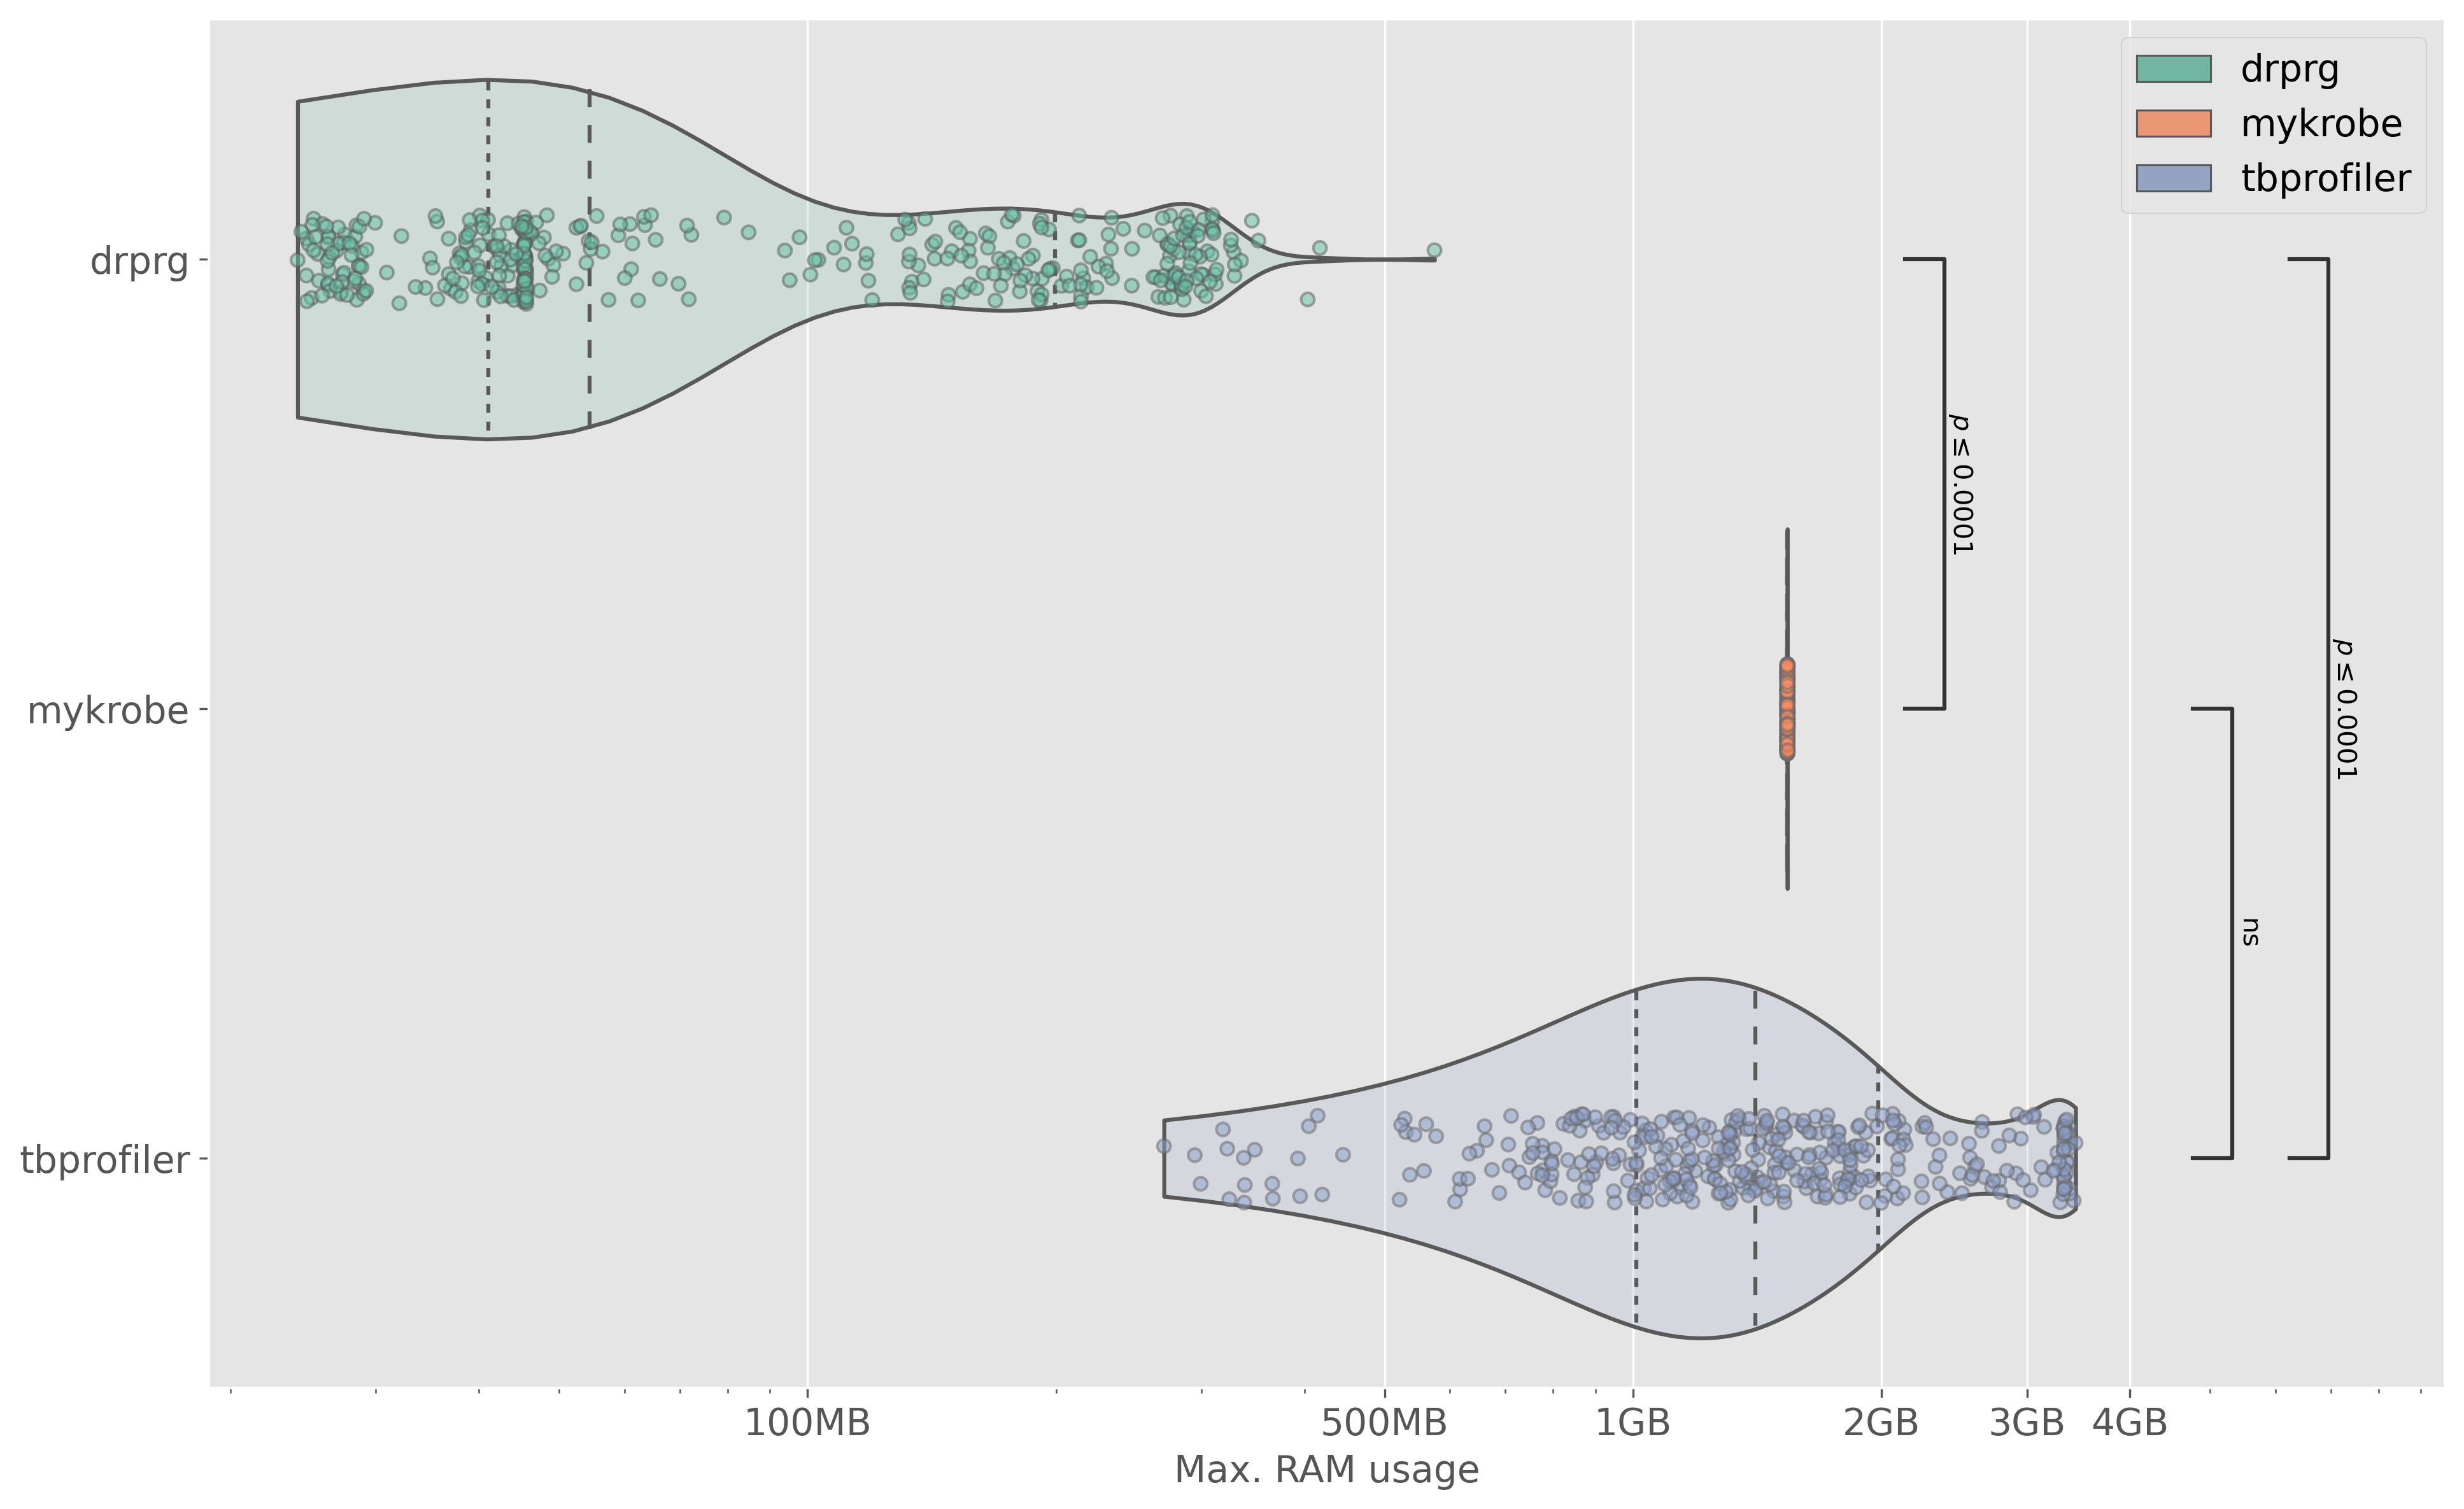

In [18]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
fs = 14
x = "tool"
hue = x
y = "max_rss"
pal = "Set2"
hue_order = sorted(set(df["tool"]))
pval_fmt = {"pvalue_thresholds":[[1e-4, "$p\leq0.0001$"], [1e-3, "$p\leq0.001$"], [1e-2, "$p\leq0.01$"], [0.05, "$p\leq0.05$"], [1, "ns"]]}

kwargs = dict(
    data=df, 
    x=y, 
    y=x, 
    hue=hue, 
    palette=pal, 
    hue_order=hue_order,
    order=hue_order,
    orient="h",
    ax=ax,
    dodge=False
)

# sns.boxplot(**kwargs, showfliers=False, showcaps=False, boxprops=dict(facecolor="none"))
sns.violinplot(**kwargs, cut=0, inner="quartile")
for violin in ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=0.2))
    
sns.stripplot(**kwargs, alpha=0.5, edgecolor="gray", linewidth=1)

ax.set_xscale("log")
ticks = [(100, "100MB"), (500, "500MB"), (1000, "1GB"), (2000, "2GB"), (3000, "3GB"), (4000, "4GB")]
ax.set_xticks([t[0] for t in ticks])
ax.set_xticklabels([t[1] for t in ticks], fontsize=fs)
ax.set_xlabel("Max. RAM usage", fontsize=fs)
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=fs)

annot = Annotator(ax, [("drprg", "mykrobe"), ("mykrobe", "tbprofiler"), ("drprg", "tbprofiler")], data=df, x=y, y=x, orient="h", order=hue_order)
annot.configure(test='Wilcoxon', pvalue_format=pval_fmt)
annot.apply_test()
annot.annotate()

legend_without_duplicate_labels(ax)

plt.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
$p\leq0.05$: 1.00e-02 < p <= 5.00e-02
$p\leq0.01$: 1.00e-03 < p <= 1.00e-02
$p\leq0.001$: 1.00e-04 < p <= 1.00e-03
$p\leq0.0001$: p <= 1.00e-04

drprg vs. mykrobe: Wilcoxon test (paired samples), P_val:2.556e-62 Stat=1.553e+03
mykrobe vs. tbprofiler: Wilcoxon test (paired samples), P_val:2.418e-41 Stat=8.939e+03
drprg vs. tbprofiler: Wilcoxon test (paired samples), P_val:6.187e-67 Stat=1.090e+02


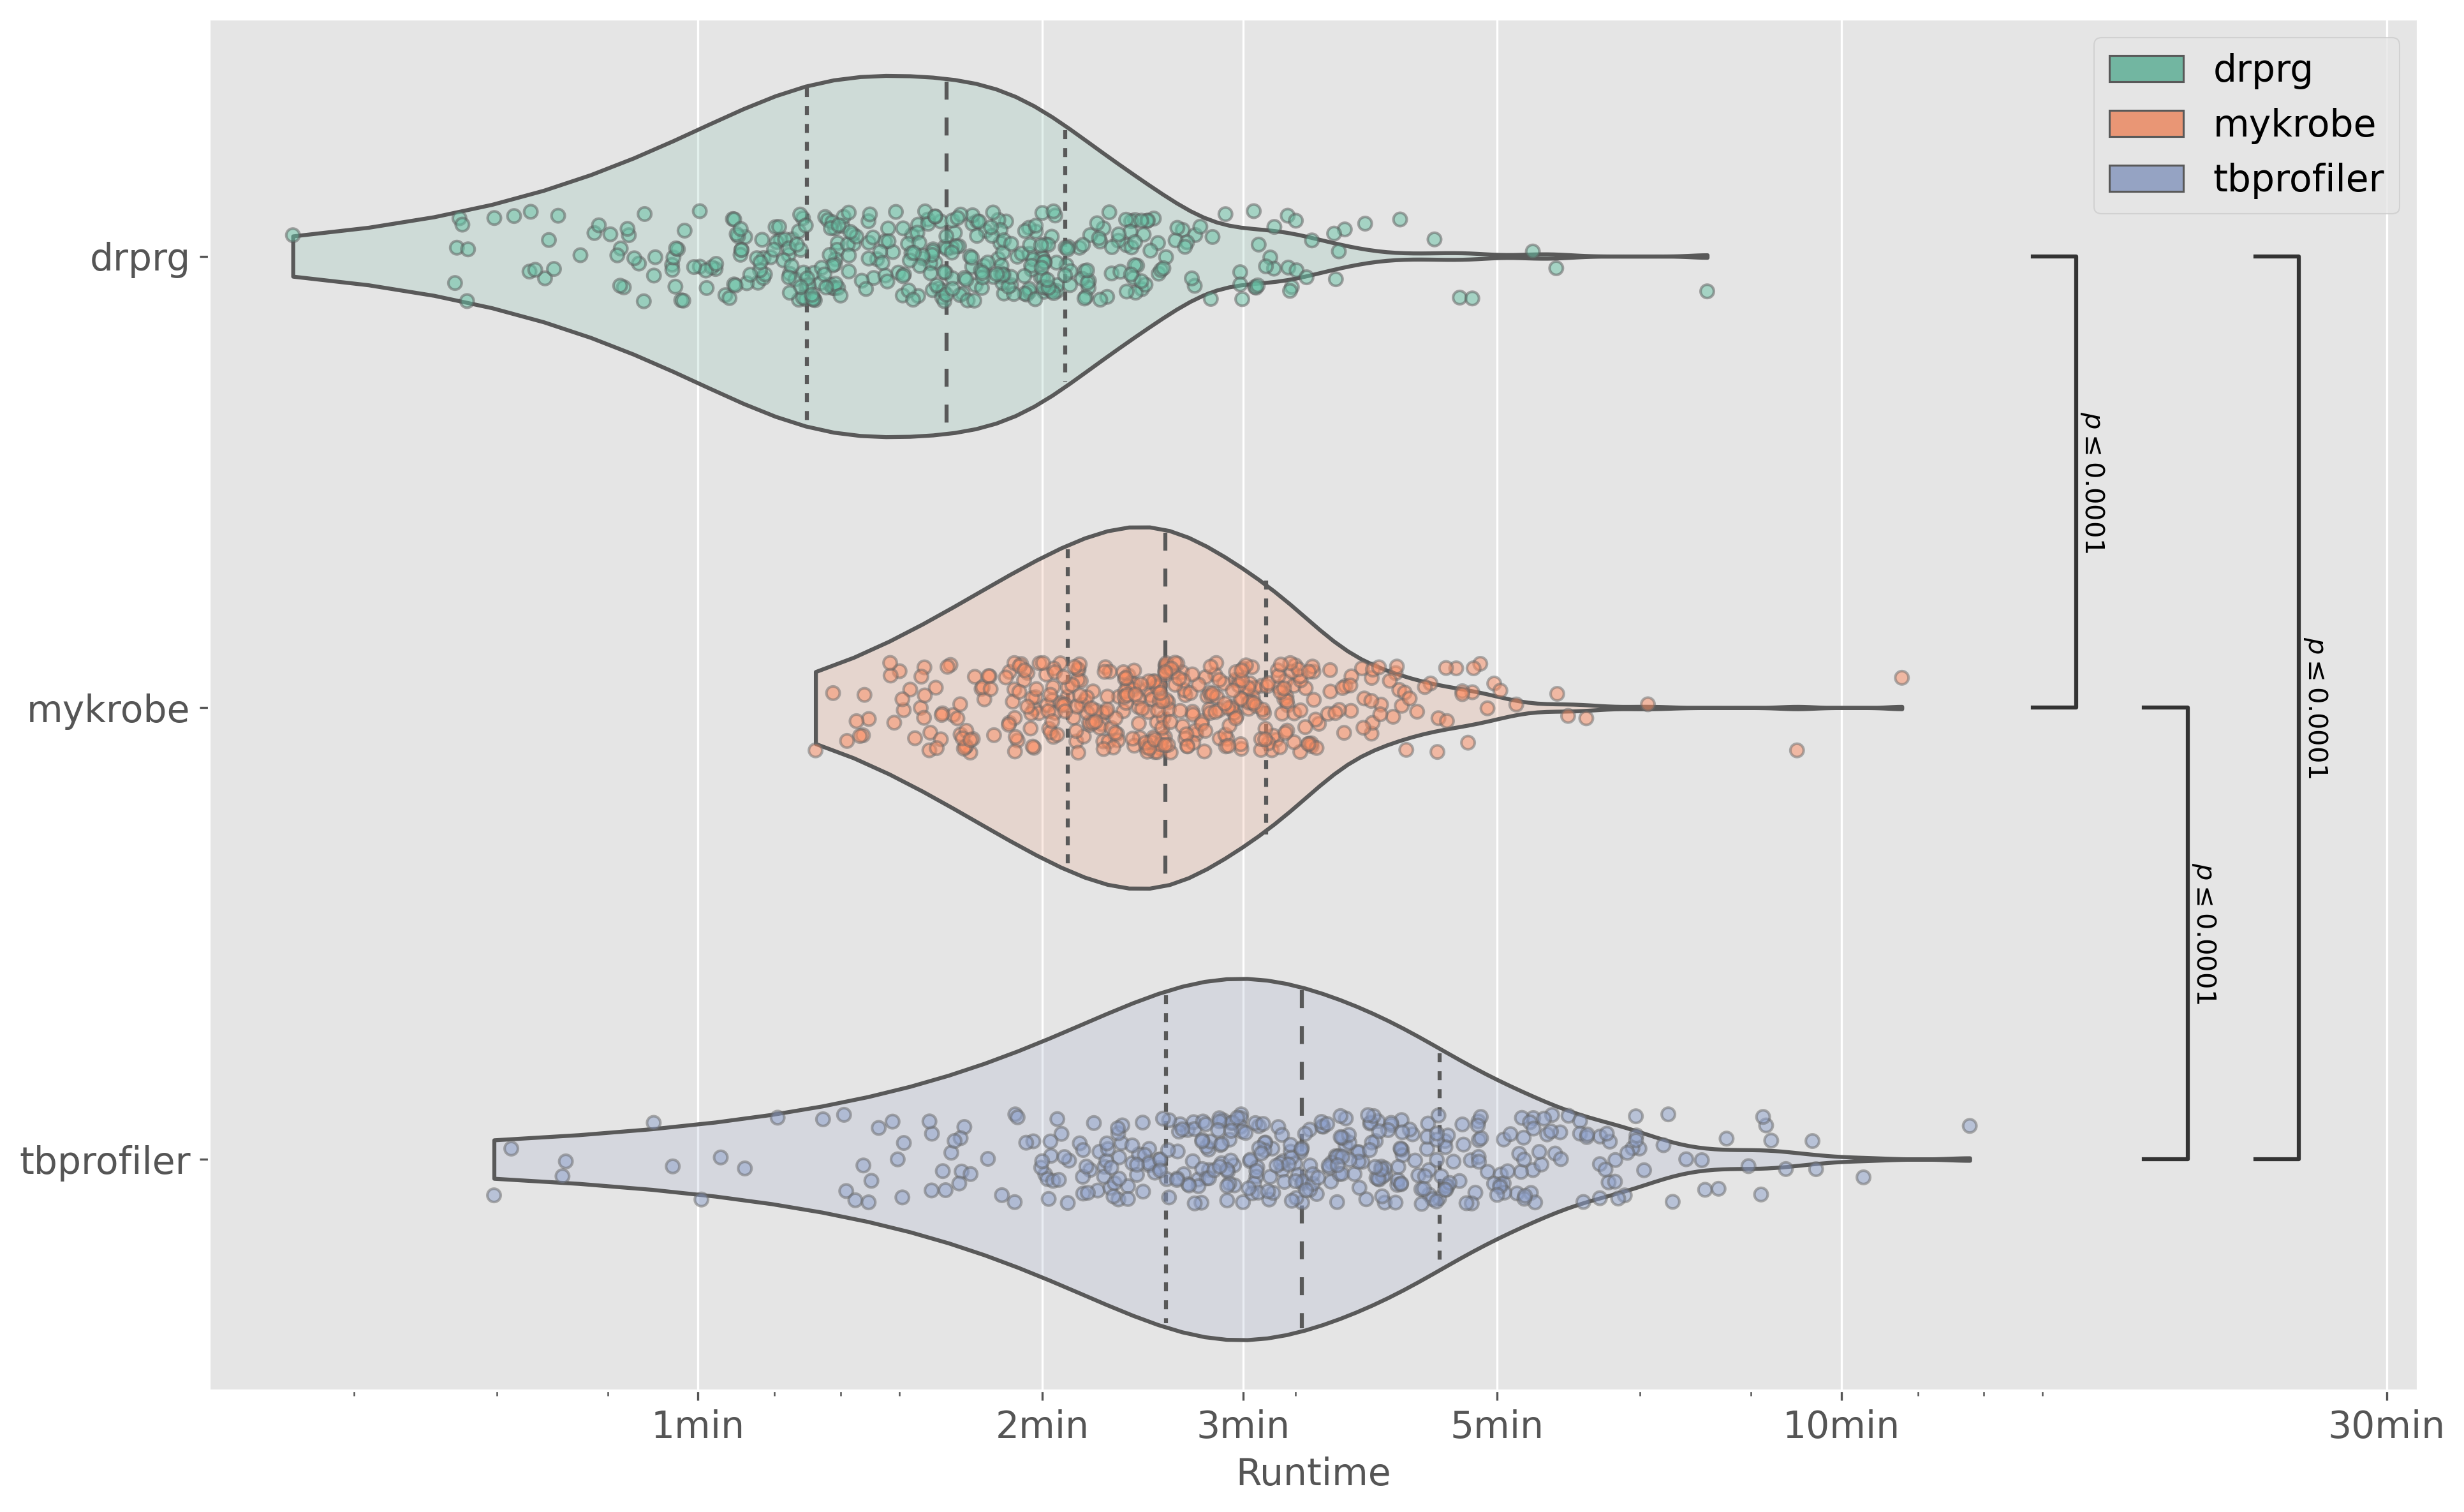

In [21]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
fs = 14
x = "tool"
hue = x
y = "s"
pal = "Set2"
hue_order = sorted(set(df["tool"]))
pval_fmt = {"pvalue_thresholds":[[1e-4, "$p\leq0.0001$"], [1e-3, "$p\leq0.001$"], [1e-2, "$p\leq0.01$"], [0.05, "$p\leq0.05$"], [1, "ns"]]}

kwargs = dict(
    data=df, 
    x=y, 
    y=x, 
    hue=hue, 
    palette=pal, 
    hue_order=hue_order,
    order=hue_order,
    orient="h",
    ax=ax,
    dodge=False
)

# sns.boxplot(**kwargs, showfliers=False, showcaps=False, boxprops=dict(facecolor="none"))
sns.violinplot(**kwargs, cut=0, inner="quartile")
for violin in ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=0.2))
    
    
sns.stripplot(**kwargs, alpha=0.5, edgecolor="gray", linewidth=1)

ax.set_xscale("log")
ticks = [(60, "1min"), (120, "2min"), (180, "3min"), (300, "5min"), (600, "10min"), (1800, "30min")]
ax.set_xticks([t[0] for t in ticks])
ax.set_xticklabels([t[1] for t in ticks], fontsize=fs)
ax.set_xlabel("Runtime", fontsize=fs)
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=fs)

legend_without_duplicate_labels(ax)

annot = Annotator(ax, [("drprg", "mykrobe"), ("mykrobe", "tbprofiler"), ("drprg", "tbprofiler")], data=df, x=y, y=x, orient="h", order=hue_order)
annot.configure(test='Wilcoxon', pvalue_format=pval_fmt)
annot.apply_test()
annot.annotate()



plt.tight_layout()

# Depth analysis

In [128]:
from typing import Optional
import sys

@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def sensitivity(self) -> Tuple[float, float, float]:
        """Also known as recall and true positive rate (TPR)"""
        try:
            sn = self.tp / (self.tp + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fn)
            return sn, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def specificity(self) -> Tuple[float, float, float]:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            sp = self.tn / (self.tn + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fp)
            return sp, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def mcc(self) -> Optional[float]:
        """Matthews correlation coefficient"""
        numerator = (self.tp * self.tn) - (self.fp * self.fn)
        denominator = (
            (self.tp + self.fp)
            * (self.tp + self.fn)
            * (self.tn + self.fp)
            * (self.tn + self.fn)
        )
        try:
            return numerator / sqrt(denominator)
        except ZeroDivisionError:
            return None

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = 0.95) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z**2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))


In [161]:
tech = "illumina"
ignore_drugs = ("all", "ciprofloxacin")

In [162]:
qc = pd.read_csv(f"../../results/QC/{tech}.qc.csv", index_col="run")
qc

coverage    f_keep  f_contam  f_unmapped
run                                                   
ERR1034923  116.906700  0.993057  0.001520    0.005424
ERR1034928  100.294125  0.994730  0.001397    0.003873
ERR1034939  128.816109  0.996684  0.000915    0.002401
ERR1034972   95.890485  0.995368  0.001181    0.003451
ERR1035042  486.549780  0.995747  0.000698    0.003555
...                ...       ...       ...         ...
ERR550877   130.882447  0.995405  0.001220    0.003376
ERR551149   230.509270  0.997060  0.000685    0.002255
ERR551165   176.843196  0.994944  0.001267    0.003789
ERR551186   158.752787  0.996903  0.000970    0.002127
ERR551514    64.007564  0.996173  0.002741    0.001087

[400 rows x 4 columns]

In [163]:
phenotypes = pd.read_csv(f"../../config/{tech}.samplesheet.csv", index_col="run", low_memory=False)
phenotypes

amikacin bedaquiline   bioproject     biosample capreomycin  \
run                                                                      
ERR025832       NaN         NaN    PRJEB2221   SAMEA961581         NaN   
ERR025833       NaN         NaN    PRJEB2221   SAMEA961610         NaN   
ERR025834       NaN         NaN    PRJEB2221   SAMEA961608         NaN   
ERR025835       NaN         NaN    PRJEB2221   SAMEA961609         NaN   
ERR025836       NaN         NaN    PRJEB2221   SAMEA961584         NaN   
...             ...         ...          ...           ...         ...   
SRR8651589        R         NaN  PRJNA522942  SAMN10961345           R   
SRR8651594        R         NaN  PRJNA522942  SAMN10961353           R   
SRR8651616        R         NaN  PRJNA522942  SAMN10961375           S   
SRR8651654        R         NaN  PRJNA522942  SAMN10961324           R   
SRR8651662        R         NaN  PRJNA522942  SAMN10961392           R   

           ciprofloxacin clofazimine cycloserine delamanid ethambutol  ...  \
run                                                                    ...   
ERR025832            NaN         NaN         NaN       NaN          S  ...   
ERR025833            NaN         NaN         NaN       NaN          S  ...   
ERR025834            NaN         NaN         NaN       NaN          S  ...   
ERR025835            NaN         NaN         NaN       NaN          S  ...   
ERR025836            NaN         NaN         NaN       NaN          S  ...   
...                  ...         ...         ...       ...        ...  ...   
SRR8651589           NaN         NaN         NaN       NaN          S  ...   
SRR8651594           NaN         NaN         NaN       NaN          R  ...   
SRR8651616           NaN         NaN         NaN       NaN          R  ...   
SRR8651654           NaN         NaN         NaN       NaN          R  ...   
SRR8651662           NaN         NaN         NaN       NaN          R  ...   

           levofloxacin linezolid moxifloxacin ofloxacin  \
run                                                        
ERR025832           NaN       NaN          NaN       NaN   
ERR025833           NaN       NaN          NaN       NaN   
ERR025834           NaN       NaN          NaN       NaN   
ERR025835           NaN       NaN          NaN       NaN   
ERR025836           NaN       NaN          NaN       NaN   
...                 ...       ...          ...       ...   
SRR8651589            R       NaN            S       NaN   
SRR8651594            R       NaN            R       NaN   
SRR8651616            R       NaN            S       NaN   
SRR8651654            R       NaN            R       NaN   
SRR8651662            R       NaN            R       NaN   

           para-aminosalicylic_acid pyrazinamide rifabutin rifampicin  \
run                                                                     
ERR025832                       NaN            S       NaN          S   
ERR025833                       NaN            S       NaN          S   
ERR025834                       NaN            S       NaN          S   
ERR025835                       NaN            S       NaN          S   
ERR025836                       NaN            S       NaN          S   
...                             ...          ...       ...        ...   
SRR8651589                        S            R       NaN          R   
SRR8651594                        S            R       NaN          R   
SRR8651616                        S            R       NaN          R   
SRR8651654                        R            R       NaN          R   
SRR8651662                        S            R       NaN          R   

           streptomycin thioacetazone  
run                                    
ERR025832           NaN           NaN  
ERR025833           NaN           NaN  
ERR025834           NaN           NaN  
ERR025835           NaN           NaN  
ERR025836           NaN           NaN  
...                 ..

In [164]:
max_contam = 0.05
valid_samples = qc.query("f_contam<=@max_contam").index

In [165]:
frames = []
for p in Path("../../results/depth/").rglob(f"{tech}.summary.csv"):
    tool = p.parts[-2]
    frame = pd.read_csv(p)
    frames.append(frame)

In [166]:
calls = pd.concat(frames)
calls["drug"] = calls.drug.str.lower()

In [167]:
tools = sorted(set(calls["tool"]))

In [168]:
full_depths = []
for run in calls["run"]:
    full_depths.append(qc.at[run, "coverage"])
calls["full_depth"] = full_depths

In [169]:
# remove rows where the depth being analysed is actually greater than the sample's depth
# e.g., if the sample has depth 40, we would exclude it from the 100x analysis
calls.query("depth<=full_depth and run in @valid_samples and drug not in @ignore_drugs", inplace=True)

In [170]:
calls

run     biosample    bioproject technology     tool  \
0      ERR2884694  SAMEA5076136    PRJEB29604   illumina  mykrobe   
1      ERR2884694  SAMEA5076136    PRJEB29604   illumina  mykrobe   
2      ERR2884694  SAMEA5076136    PRJEB29604   illumina  mykrobe   
3      ERR2884694  SAMEA5076136    PRJEB29604   illumina  mykrobe   
4      ERR2884694  SAMEA5076136    PRJEB29604   illumina  mykrobe   
...           ...           ...           ...        ...      ...   
35995  ERR2517640    ERR2517640  SAMEA3457707   illumina    drprg   
35996  ERR2517640    ERR2517640  SAMEA3457707   illumina    drprg   
35997  ERR2517640    ERR2517640  SAMEA3457707   illumina    drprg   
35998  ERR2517640    ERR2517640  SAMEA3457707   illumina    drprg   
35999  ERR2517640    ERR2517640  SAMEA3457707   illumina    drprg   

               drug prediction  depth  full_depth  
0         ofloxacin          S    100  159.142669  
1      moxifloxacin          S    100  159.142669  
2         isoniazid          S    100  159.142669  
3         delamanid          S    100  159.142669  
4         kanamycin          S    100  159.142669  
...             ...        ...    ...         ...  
35995  moxifloxacin          S      5  114.493084  
35996     ofloxacin          S      5  114.493084  
35997  pyrazinamide          S      5  114.493084  
35998    rifampicin          F      5  114.493084  
35999  streptomycin          F      5  114.493084  

[62511 rows x 9 columns]

In [171]:
for s in qc.index.difference(valid_samples):
    print(s, file=sys.stderr)

ERR2517457
ERR4872119
ERR4872193


In [172]:
minor_is_susceptible = False#snakemake.params.minor_is_susceptible
unknown_is_resistant = False#snakemake.params.unknown_is_resistant
failed_is_resistant = False#snakemake.params.failed_is_resistant
classifier = Classifier(
    unknown_is_resistant=unknown_is_resistant,
    minor_is_susceptible=minor_is_susceptible,
    failed_is_resistant=failed_is_resistant,
)

In [173]:
calls.set_index(
    ["run", "tool", "drug", "depth"], verify_integrity=True, inplace=True, drop=False
)

In [174]:
drugs = set()
pheno_clf = []
depths = set(calls["depth"])
for drug, tool, run, depth in product(set(calls["drug"]), tools, set(calls["run"]), depths):
    full_depth = qc.at[run, "coverage"]
    if depth > full_depth:
        continue
        
    try:
        ph = phenotypes.at[run, drug]
        if pd.isna(ph):
            continue
        else:
            truth = Prediction(ph)
    except KeyError:
        print(f"[WARN]: {run} has no phenotype column for {drug}")
        continue

    ix = (run, tool, drug, depth)
    drugs.add(drug)
    try:
        pred = calls.at[ix, "prediction"]
    except KeyError:
        
        # tbprofiler doesnt explicitly report S
        assert tool == "tbprofiler", ix
        pred = "S"
    clf = classifier.from_predictions(truth, Prediction(pred))

    pheno_clf.append((run, drug, str(clf), tool, depth))
    cols = ["run", "drug", "classification", "tool", "depth"]
df = pd.DataFrame(pheno_clf, columns=cols)

In [175]:
# df.to_csv(snakemake.output.classification, index=False)

In [176]:
cms = defaultdict()

low_pheno_drugs = set()

for drug, tool, depth in product(drugs, tools, depths):
    s = df.query("drug == @drug and tool == @tool and depth == @depth").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    cms[(drug, tool, depth)] = cm
    n = sum(cm.ravel())
    if n < 10:#todo snakemake.params.min_num_phenotypes:
        low_pheno_drugs.add(drug)

drugs = {d for d in drugs if d not in low_pheno_drugs}

metrics = []
for (drug, tool, depth), cm in cms.items():
    sn = cm.sensitivity()[0]
    sp = cm.specificity()[0]
    metrics.append((drug, tool, depth, sn, sp))

summary_cols = [
    "drug",
    "tool",
    "depth",
    "Sensitivity",
    "Specificity",
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "tool", "depth"], var_name="metric")

table = (
    summary.set_index(["drug", "tool", "depth", "metric"])["value"].unstack().reset_index()
)

for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["tool"], row["depth"])
    cm = cms[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn

for k in ["drug"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = [
    "drug",
    "tool",
    "depth",
    "Sensitivity",
    "Specificity",
    "TP",
    "TN",
    "FN",
    "FP",
]
table = table[summary_cols]

rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1] * 100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    sn = cm.sensitivity()
    sp = cm.specificity()
    mcc = cm.mcc()
    if mcc is not None:
        mcc = round(mcc, 3)
    else:
        mcc = "-"
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            row["tool"],
            row["depth"],
            fn_str,
            fp_str,
            ci_str(sn),
            ci_str(sp),
            mcc,
        )
    )
pretty_cols = [
    "Drug",
    "Tool",
    "Depth",
    "FN(R)",
    "FP(S)",
    "Sensitivity (95% CI)",
    "Specificity (95% CI)",
    "MCC",
]
table = pd.DataFrame(rows, columns=pretty_cols)

# todo table.to_csv(snakemake.output.table, index=False)

sn_data = []
sp_data = []
df.query("drug not in @low_pheno_drugs", inplace=True)
for tool, depth in product(tools, depths):
#     if drug in low_pheno_drugs:
#         continue

    s = df.query("tool == @tool and depth == @depth").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    sn = cm.sensitivity()
    sp = cm.specificity()
    sn_data.append((tool, depth, *sn))
    sp_data.append((tool, depth, *sp))

sn_df = pd.DataFrame(sn_data, columns=["tool", "depth", "value", "lower", "upper"])
sp_df = pd.DataFrame(sp_data, columns=["tool", "depth", "value", "lower", "upper"])

s = """AMK amikacin
CAP capreomycin
CFX ciprofloxacin
DLM delamanid
EMB ethambutol
ETO ethionamide
INH isoniazid
KAN kanamycin
LFX levofloxacin
LZD linezolid
MFX moxifloxacin
OFX ofloxacin
PZA pyrazinamide
RIF rifampicin
STM streptomycin"""
long2short = dict()
for line in s.splitlines():
    ab, d = line.split()
    long2short[d] = ab

short2long = dict()
for line in s.splitlines():
    ab, d = line.split()
    short2long[ab] = d

first_line = [short2long[d] for d in ["INH", "RIF", "EMB", "PZA"]]
fluoroquinolones = [short2long[d] for d in ["LFX", "MFX", "OFX", "CFX"]]  # group A
macrolides = [
    short2long[d] for d in ["AMK", "CAP", "KAN", "STM"]
]  # group B - second-line injectables
other = [short2long[d] for d in ["ETO", "LZD", "DLM"]]  # group C and D
drug_order = [
    d for d in [*first_line, *fluoroquinolones, *macrolides, *other] if d in drugs
]

def sort_drugs(a):
    xs = drug_order
    out = []
    c = Counter()
    for x in a:
        i = xs.index(x)
        d = xs[i]
        c[d] += 1
        out.append((i, c[d]))
    return out

sn_df = sn_df.sort_values(by="depth").reset_index(drop=True)
sp_df = sp_df.sort_values(by="depth").reset_index(drop=True)

In [177]:
sn_df

tool  depth     value     lower     upper
0        drprg      5  0.431138  0.388459  0.474865
1   tbprofiler      5  0.055888  0.038947  0.079588
2      mykrobe      5  0.686627  0.644718  0.725695
3      mykrobe     10  0.842315  0.807813  0.871608
4        drprg     10  0.760479  0.721215  0.795779
5   tbprofiler     10  0.499002  0.455394  0.542625
6        drprg     15  0.834331  0.799257  0.864318
7   tbprofiler     15  0.782435  0.744231  0.816341
8      mykrobe     15  0.866267  0.833660  0.893301
9      mykrobe     30  0.868952  0.836397  0.895835
10  tbprofiler     30  0.891129  0.860652  0.915594
11       drprg     30  0.868952  0.836397  0.895835
12  tbprofiler     60  0.893023  0.860251  0.918835
13       drprg     60  0.862791  0.827043  0.892114
14     mykrobe     60  0.869767  0.834655  0.898332
15  tbprofiler    100  0.878049  0.831246  0.913226
16     mykrobe    100  0.849593  0.799568  0.888869
17       drprg    100  0.861789  0.813071  0.899380

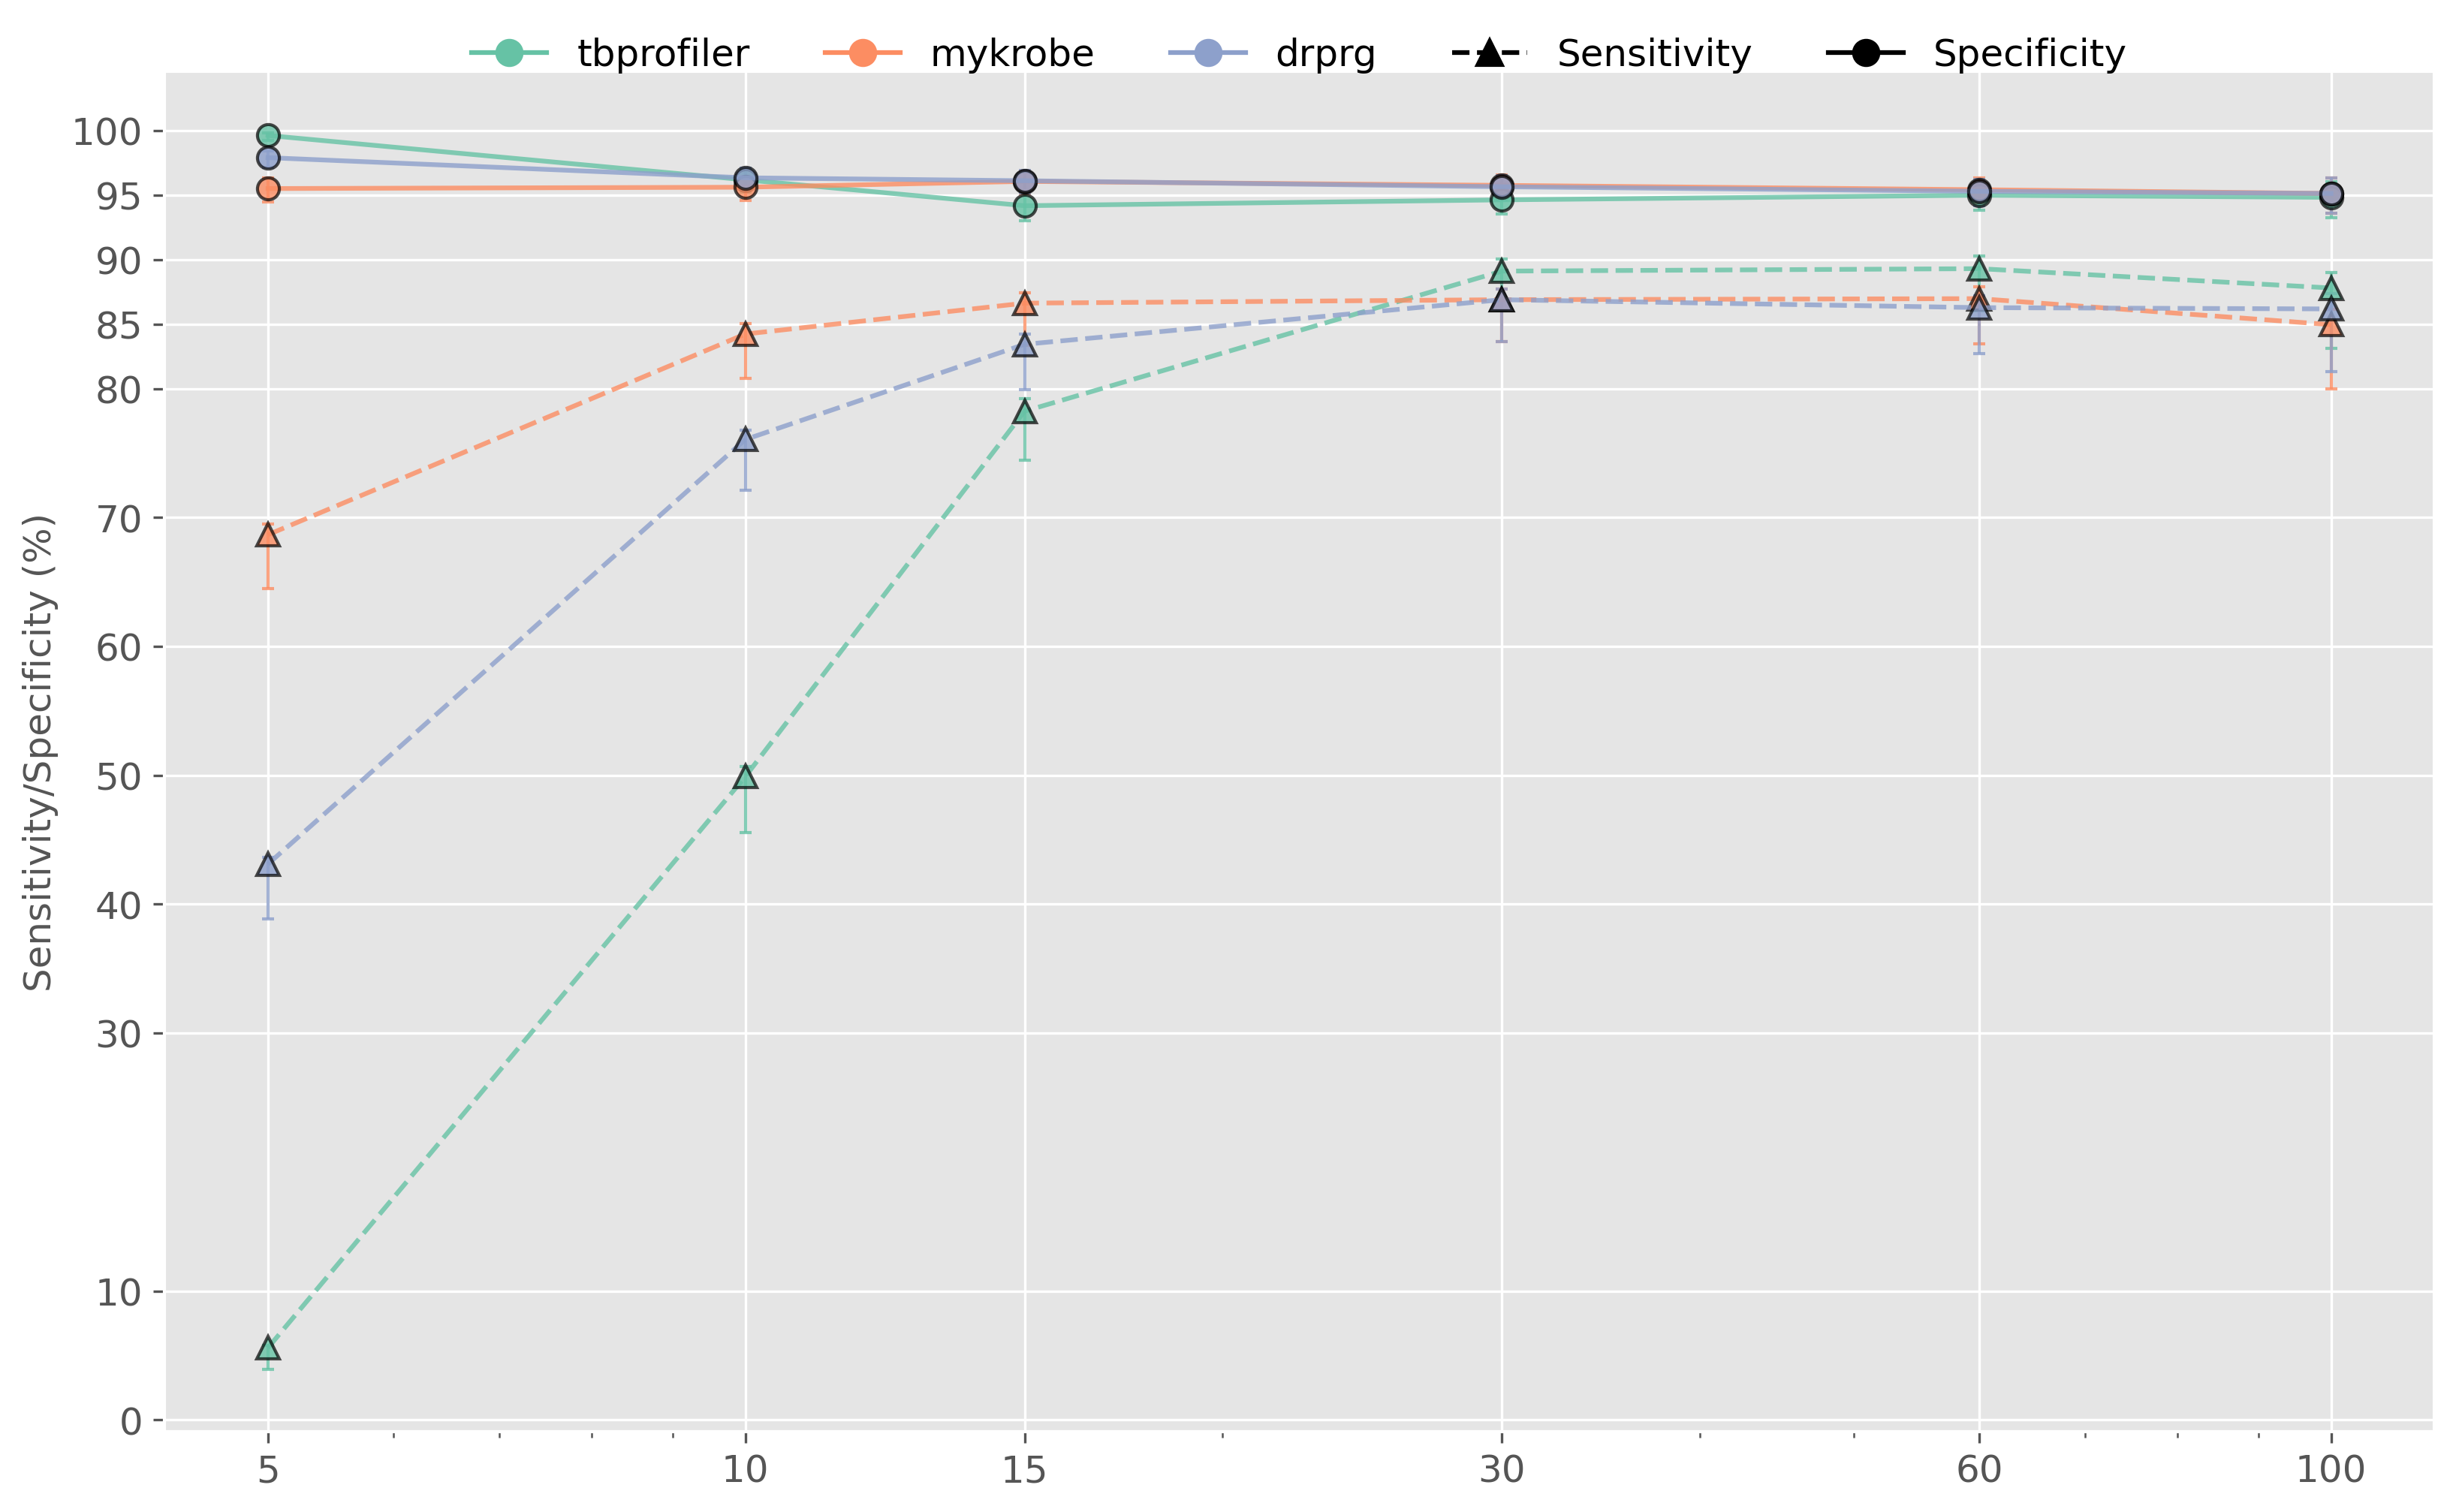

In [178]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)

x = "depth"
y = "value"

sn_line = "--"
sp_line = "-"

i = -1

leghandles = []

for tool in TOOLS:
    i += 1
    tool_sn_df = sn_df.query("tool==@tool")
    tool_sp_df = sp_df.query("tool==@tool")

    colour = mpl.colors.to_rgba(cmap[i], alpha=0.8)
    label = tool


    sp_ys = tool_sp_df["value"] * 100
    sp_lb = sp_ys - tool_sp_df["lower"] * 100
    sp_ub = tool_sp_df["upper"] * 100 - sp_ys
    sp_ub = [min(100, x) for x in sp_ub]

    
    plotprops = dict(
        label=label, 
        color=colour, 
        capsize=capsize, 
        elinewidth=elw,
        mec=edgecol,
        markersize=marker_size,
    )
    
    sp_bar = ax.errorbar(
        x=tool_sp_df[x], 
        y=sp_ys,
        yerr=[sp_lb, sp_ub],
        fmt=f"{sp_marker}{sp_line}",
        **plotprops
    )
    
    sn_ys = tool_sn_df["value"] * 100
    sn_lb = sn_ys - tool_sn_df["lower"] * 100
    sn_ub = tool_sn_df["upper"] * 100 - sn_ys
    sn_ub = [min(100, x) for x in sp_ub]


    
    sn_bar = ax.errorbar(
        x=tool_sn_df[x], 
        y=sn_ys,
        yerr=[sn_lb, sn_ub],
        fmt=f"{sn_marker}{sn_line}",
        **plotprops
    )
    
    h = mlines.Line2D([], [], color=cmap[i], marker=sp_marker,
                      markersize=leg_marker_size, label=label)
    leghandles.append(h)
    
# labels = [long2short[d] for d in drug_order]
# label_pos = [np.mean(ps) for ps in zip(*all_positions)]
# plt.xticks(label_pos, labels, rotation=rotate, fontsize=fs)
ax.set_ylabel("Sensitivity/Specificity (%)")
yticks = [0, 10, 30, 40, 50, 60, 70, 80, 85, 90, 95, 100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)


# ax.set_xticks(label_pos)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, fontsize=fs)
ax.tick_params("both", labelsize=fs)

ax.set_xscale("log")
xticks = sorted(set(sn_df["depth"]))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

leghandles.append(mlines.Line2D([], [], color="black", marker=sn_marker, linestyle=sn_line,
                          markersize=leg_marker_size, label="Sensitivity"))
leghandles.append(mlines.Line2D([], [], color="black", marker=sp_marker, linestyle=sp_line,
                          markersize=leg_marker_size, label="Specificity"))

legend_props = dict(
    loc="upper center", 
    prop=dict(size=fs), 
    frameon=False, 
#     title_fontproperties=dict(size=fs-1, weight="bold"),
#     shadow=True,
    ncol=len(leghandles),
#     fancybox=True
)
ax.legend(handles=leghandles, bbox_to_anchor=(0.5, 1.05), **legend_props)
# axS.legend(leghandles[-2:], leglabels[-2:], title="Walker et al.", bbox_to_anchor=(1, 0.68), **legend_props)

# ax.grid(False, axis="x",)
# draw line between drug bars
# for xpos in all_positions[-1]:
#     vpos = xpos+epsilon+bar_width
#     ax.axvline(vpos, color="white", linestyle="-", alpha=1, linewidth=6)
    
# xlim = (all_positions[0][0]-(epsilon+bar_width), vpos+(epsilon))
# ax.set_xlim(xlim)
# _ = ax.set_xlabel("Drug", fontsize=fs+2)

# Common mutations in WHO catalogue

In [1]:
import pandas as pd

In [10]:
min_occurence = 4

In [11]:
df = pd.read_csv("../../resources/who-catalogue-grade1-2.tsv", sep="\t", low_memory=False)

In [15]:
common_df = df.sort_values(by=["drug", "Present_SOLO_R"], ascending=[True, False]).query("Present_SOLO_R>=@min_occurence")
common_df

drug                                            variant  Present_SOLO_R  \
0     AMI                                         rrs_a1401g           918.0   
1     AMI                                          eis_c-14t            28.0   
2     AMI                                         rrs_g1484t             5.0   
3     AMI                                         rrs_c1402t             4.0   
4     CAP                                         rrs_a1401g           575.0   
...   ...                                                ...             ...   
1043  STM                                           gid_W45!             6.0   
1045  STM                                 gid_181_del_1_gt_g             6.0   
1042  STM                                          rpsL_K88Q             5.0   
1044  STM  gid_354_ins_1_gcgcccccgcacgatctcaacggcca_gcgcc...             5.0   
1041  STM                                 gid_387_del_1_gc_g             4.0   

      Present_SOLO_SR  Present_S  Present_R  Absent_S  Absent_R  \
0               966.0       50.0      939.0   15640.0     349.0   
1                77.0       51.0       32.0    7325.0     632.0   
2                 7.0        2.0        6.0   15688.0    1282.0   
3                13.0       10.0        5.0   15680.0    1283.0   
4               734.0      160.0      583.0   10396.0     387.0   
...               ...        ...        ...       ...       ...   
1043             11.0        5.0        7.0    9344.0    4628.0   
1045             12.0        7.0        6.0    9342.0    4629.0   
1042              9.0        4.0        7.0    9345.0    4628.0   
1044              8.0        3.0        6.0    9346.0    4629.0   
1041              8.0        4.0        7.0    9345.0    4628.0   

                     grading  
0               1) Assoc w R  
1               1) Assoc w R  
2     2) Assoc w R - Interim  
3     2) Assoc w R - Interim  
4               1) Assoc w R  
...                      ...  
1043  2) Assoc w R - Interim  
1045  2) Assoc w R - Interim  
1042  2) Assoc w R - Interim  
1044  2) Assoc w R - Interim  
1041  2) Assoc w R - Interim  

[277 rows x 9 columns]

In [20]:
common_df.query("drug=='EMB'")

drug     variant  Present_SOLO_R  Present_SOLO_SR  Present_S  Present_R  \
43  EMB  embB_M306V          1544.0           1891.0      367.0     1801.0   
44  EMB  embB_M306I           696.0           1282.0      625.0      984.0   
45  EMB  embB_Q497R           275.0            352.0      111.0      497.0   
47  EMB  embB_D354A           189.0            329.0      153.0      236.0   
48  EMB  embB_G406A           122.0            232.0      120.0      176.0   
49  EMB  embB_Y319S           120.0            142.0       24.0      121.0   
46  EMB  embA_c-12t            84.0            162.0       99.0      238.0   
50  EMB  embB_G406D            77.0            178.0      112.0      117.0   
52  EMB  embB_M306L            50.0             68.0       18.0       68.0   
51  EMB  embB_G406S            34.0             69.0       46.0       79.0   
53  EMB  embB_Q497K            34.0             56.0       25.0       68.0   
57  EMB   embB_L74R            18.0             25.0        7.0       18.0   
55  EMB  embB_G406C            15.0             35.0       20.0       24.0   
54  EMB  embB_D328Y            13.0             16.0        3.0       24.0   
56  EMB  embB_Y319C            10.0             18.0        9.0       14.0   

    Absent_S  Absent_R                 grading  
43   25441.0    3099.0            1) Assoc w R  
44   25183.0    3916.0            1) Assoc w R  
45   25697.0    4403.0            1) Assoc w R  
47   25655.0    4664.0            1) Assoc w R  
48   25688.0    4724.0            1) Assoc w R  
49   25784.0    4779.0            1) Assoc w R  
46   25709.0    4662.0            1) Assoc w R  
50   25696.0    4783.0            1) Assoc w R  
52   25790.0    4832.0            1) Assoc w R  
51   25762.0    4821.0            1) Assoc w R  
53   25783.0    4832.0            1) Assoc w R  
57   25801.0    4882.0  2) Assoc w R - Interim  
55   25788.0    4876.0            1) Assoc w R  
54   25805.0    4876.0            1) Assoc w R  
56   20082.0    3601.0            1) Assoc w R

In [32]:
134*3-2

400

In [153]:
vs = []
for v in common_df["variant"]:
    if "(" in v:
        v = v.split("(")[1].split(")")[0]
#     if v == "fabG1_L203L":
#         v = "fabG1_g609a"
    vs.append(v)
    
common_df["variant"] = vs

In [154]:
from itertools import chain
def load_uids(file: str) -> dict[str, list[str]]:
    d = defaultdict(list)

    seen = set()
    with open(file) as fp:
        for line in map(str.rstrip, fp):
            if not line or line in seen:
                continue
            seen.add(line)
            fields = line.split(".")
            try:
                ix = (fields[5], fields[7])
            except IndexError as err:
                if line.startswith("N"):
                    ix = line
                else:
                    raise err
            d[ix].append(line)

    return d

def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)

In [155]:
cryptic_samples = load_uids("../../resources/cryptic.samples.txt")

In [156]:
popn_samples = load_uids("../../resources/popn.samples.txt")

In [157]:
mutations_df = pd.read_csv("../../resources/mutations_in_genes_of_interest.csv", low_memory=False)
mutations_df

UNIQUEID  GENE MUTATION
0           site.02.subj.1101.lab.2014185006.iso.1   gid     E92D
1           site.02.subj.1101.lab.2014185006.iso.1  gyrA     E21Q
2           site.02.subj.1101.lab.2014185006.iso.1  gyrA     S95T
3           site.02.subj.1101.lab.2014185006.iso.1  gyrA    G668D
4           site.02.subj.1101.lab.2014185006.iso.1  katG    R463L
...                                            ...   ...      ...
7234  site.10.subj.YA00038958.lab.YA00038958.iso.1  gyrA     E21Q
7235  site.10.subj.YA00038958.lab.YA00038958.iso.1  gyrA     S95T
7236  site.10.subj.YA00038958.lab.YA00038958.iso.1  gyrA    G247S
7237  site.10.subj.YA00038958.lab.YA00038958.iso.1  gyrA    G668D
7238  site.10.subj.YA00038958.lab.YA00038958.iso.1  rpoB    V113I

[7239 rows x 3 columns]

In [158]:
muts = set(mutations_df["MUTATION"])

In [159]:
mut2ids = defaultdict(set)

In [160]:
c = 0
for v in common_df["variant"]:
    gene = v.split("_")[0]
    if "(" in v:
        v = v.split("(")[1].split(")")[0]
    vnt = v.split("_", maxsplit=1)[1]
    if vnt in muts:
        c+=1
        frame = mutations_df.query("MUTATION==@vnt and GENE==@gene")
        mut2ids[v].update(set(frame["UNIQUEID"]))
        continue
    x_vnt = vnt[:-1] + "X"
    if x_vnt in muts:
        c+=1
        frame = mutations_df.query("MUTATION==@x_vnt and GENE==@gene")
        mut2ids[v].update(set(frame["UNIQUEID"]))
        continue
    o_vnt = vnt[:-1] + "O"
    if o_vnt in muts:
        c+=1
        frame = mutations_df.query("MUTATION==@o_vnt and GENE==@gene")
        mut2ids[v].update(set(frame["UNIQUEID"]))
        continue
    if "del" in vnt or "ins" in vnt:
        pos = vnt.split("_")[0]
        indel_v = f"{pos}_indel"
        if indel_v in muts:
            c+=1
            frame = mutations_df.query("MUTATION==@indel_v and GENE==@gene")
            mut2ids[v].update(set(frame["UNIQUEID"]))
            continue
    mut2ids[v].update([])
print(f"{c}/{len(common_df)}")

112/126


In [161]:
mut2ids

defaultdict(set,
            {'rrs_a1401g': {'site.00.subj.BE-65.lab.12MY1157.iso.1',
              'site.03.subj.10368.lab.IML-00989.iso.1',
              'site.03.subj.T4683.lab.IML-00063.iso.1',
              'site.03.subj.UZB11528.lab.UZB11528.iso.1',
              'site.04.subj.01189.lab.721807.iso.1',
              'site.04.subj.01275.lab.26422.iso.1',
              'site.04.subj.02192.lab.803701.iso.1',
              'site.04.subj.03116.lab.825929.iso.1',
              'site.10.subj.YA00024313.lab.YA00024313.iso.1',
              'site.10.subj.YA00127822.lab.YA00127822.iso.1',
              'site.ENA.subj.SAMEA1403880.lab.1.iso.1',
              'site.ENA.subj.SAMEA2343215.lab.1.iso.1',
              'site.ENA.subj.SAMEA2418258.lab.1.iso.1',
              'site.ENA.subj.SAMEA2533755.lab.1.iso.1',
              'site.ENA.subj.SAMEA3231624.lab.1.iso.1',
              'site.ENA.subj.SAMEA95411668.lab.1.iso.1',
              'site.ENA.subj.SAMEA95527918.lab.1.iso.1',
              '

In [162]:
cryptic_samples

defaultdict(list,
            {('YA00126296',
              'YA00126296'): ['site.10.iso.1.subject.YA00126296.lab_id.YA00126296.seq_reps.1'],
             ('UH00103810',
              'UH00103810'): ['site.10.iso.1.subject.UH00103810.lab_id.UH00103810.seq_reps.1'],
             ('01080',
              '720526'): ['site.04.iso.1.subject.01080.lab_id.720526.seq_reps.1'],
             ('N811',
              '06MIL1543'): ['site.06.iso.1.subject.N811.lab_id.06MIL1543.seq_reps.1'],
             ('BVH_0028-14',
              '06MIL0384'): ['site.06.iso.1.subject.BVH_0028-14.lab_id.06MIL0384.seq_reps.1'],
             ('00031',
              '629762'): ['site.04.iso.1.subject.00031.lab_id.629762.seq_reps.1'],
             ('4313',
              '4313'): ['site.14.iso.1.subject.4313.lab_id.4313.seq_reps.1'],
             ('LR-2030',
              'FN-00391-15'): ['site.05.iso.1.subject.LR-2030.lab_id.FN-00391-15.seq_reps.1'],
             ('GB-85010098',
              '85010098'): ['site.03.is

What cryptic samples map to what mutations? We want to see how many mutations we can cover with the least number of samples

In [163]:
sample2muts = defaultdict(list)
no_sample = set()
for v, ids in mut2ids.items():
    for uid in ids:
        key = (uid.split(".")[3], uid.split(".")[5])
        cryptic = cryptic_samples.get(key, cryptic_samples.get((key[1], key[0])))
        if cryptic is None:
            print(v, uid)
            no_sample.add(uid)
            continue
        sample2muts[cryptic[0]].append(v)
print(len(no_sample))

rrs_a1401g site.ENA.subj.SAMEA95411668.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMEA2418258.lab.1.iso.1
rrs_a1401g site.03.subj.UZB11528.lab.UZB11528.iso.1
rrs_a1401g site.ENA.subj.SAMN02586056.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMEA1403880.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMN02628493.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMEA95527918.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMN09708335.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMEA2533755.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMEA2343215.lab.1.iso.1
rrs_a1401g site.00.subj.BE-65.lab.12MY1157.iso.1
rrs_a1401g site.ENA.subj.SAMN02053744.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMN08347712.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMN07956624.lab.1.iso.1
rrs_a1401g site.ENA.subj.SAMEA3231624.lab.1.iso.1
embB_M306V site.03.subj.T-250-12888.lab.T-250-12888.iso.1
embB_M306V site.ENA.subj.SAMN02599184.lab.1.iso.1
embB_M306V site.ENA.subj.SAMEA3558343.lab.1.iso.1
embB_M306V site.ENA.subj.SAMEA104600262.lab.1.iso.1
embB_M306V site.05.subj.LI2163509.lab

In [164]:
muts_covered = set(flatten(sample2muts.values()))
n_muts_covered = len(muts_covered)
print(f"{n_muts_covered}/{len(common_df)} common mutations covered by {len(sample2muts)} samples")

63/126 common mutations covered by 75 samples


In [165]:
samples_to_use = set()
muts_seen = set()
for sample in sorted(sample2muts, key=lambda k: len(sample2muts[k]), reverse=True):
    for v in sample2muts[sample]:
        if v in muts_seen:
            continue
        muts_seen.add(v)
        samples_to_use.add(sample)
        if len(muts_seen) == len(muts_covered):
            break

In [172]:
len(samples_to_use)

29

In [179]:
len(samples_to_use-set(flatten(popn_samples.values())))

28

{'N0004',
 'N0031',
 'N0052',
 'N0054',
 'N0072',
 'N0091',
 'N0136',
 'N0145',
 'N0153',
 'N0155',
 'N0157',
 'N1176',
 'N1177',
 'N1202',
 'N1216',
 'N1272',
 'N1283',
 'site.02.iso.1.subject.1020.lab_id.2013183277.seq_reps.2013183277',
 'site.03.iso.1.subject.DR-118.lab_id.IML-01104.seq_reps.1',
 'site.03.iso.1.subject.DS-11.lab_id.IML-01217.seq_reps.1',
 'site.03.iso.1.subject.GB-83610010.lab_id.83610010.seq_reps.1',
 'site.03.iso.1.subject.GB-91940164.lab_id.IML-01663.seq_reps.1',
 'site.03.iso.1.subject.GB-93630025.lab_id.IML-02047.seq_reps.1',
 'site.03.iso.1.subject.GB-93810012.lab_id.IML-02020.seq_reps.1',
 'site.04.iso.1.subject.00050.lab_id.633275.seq_reps.1',
 'site.04.iso.1.subject.00308.lab_id.713461.seq_reps.1',
 'site.04.iso.1.subject.00315.lab_id.702097.seq_reps.1',
 'site.04.iso.1.subject.00460.lab_id.704829.seq_reps.1',
 'site.04.iso.1.subject.00644.lab_id.713506.seq_reps.1',
 'site.04.iso.1.subject.00704.lab_id.704944.seq_reps.1',
 'site.04.iso.1.subject.00755.lab_i

In [167]:
with open("../../resources/cryptic.to_keep.samples.txt", "w") as fp:
    for s in samples_to_use:
        print(s, file=fp)

In [168]:
mutations_with_no_cyptic_sample = set(common_df["variant"]) - muts_covered

In [169]:
len(mutations_with_no_cyptic_sample)

47

In [170]:
mutations_with_no_cyptic_sample

{'eis_g-37t',
 'embB_D328Y',
 'embB_G406C',
 'embB_G406D',
 'embB_M306L',
 'ethA_111_del_1_ct_c',
 'ethA_482_del_33_atcggcccgacgaaatcctccgagccggcgaatc_a',
 'ethA_769_del_1_gc_g',
 'ethA_A341V',
 'ethA_M1R',
 'ethA_M1T',
 'ethA_R207G',
 'ethA_S390F',
 'ethA_S399!',
 'ethA_t-7c',
 'fabG1_t-8a',
 'fabG1_t-8c',
 'gid_103_del_1_gc_g',
 'gid_352_del_1_gc_g',
 'gid_G73A',
 'gyrA_D94N',
 'gyrA_G88C',
 'gyrB_E501D',
 'katG_S315N',
 'katG_W328L',
 'pncA_A146V',
 'pncA_C14R',
 'pncA_D8G',
 'pncA_G97D',
 'pncA_H57D',
 'pncA_H57R',
 'pncA_L4S',
 'pncA_Q141P',
 'pncA_V7G',
 'rpoB_D435G',
 'rpoB_D435Y',
 'rpoB_H445C',
 'rpoB_H445N',
 'rpoB_H445R',
 'rpoB_L430R',
 'rpoB_L452P',
 'rpoB_M434I',
 'rpoB_Q432P',
 'rpoB_S441L',
 'rpoB_V170F',
 'rrs_g878a',
 'tlyA_N236K'}

In [171]:
with open("../../resources/mutations.with_no_cryptic_samples.txt", "w") as fp:
    for s in samples_to_use:
        print(s, file=fp)

In [183]:
reference = ""
with open("../../resources/NC_000962.3.fa") as fp:
    for line in map(str.rstrip, fp):
        if line and line[0] == ">":
            continue
        reference += line

In [189]:
import re
import sys
from collections import defaultdict
from dataclasses import dataclass
from itertools import repeat

REVERSE = "-"
TRANSLATE = str.maketrans("ATGC", "TACG")
STOP = "*"
CHROM = "NC_000962.3"
CODONTAB = {
    "TCA": "S",
    "TCC": "S",
    "TCG": "S",
    "TCT": "S",
    "TTC": "F",
    "TTT": "F",
    "TTA": "L",
    "TTG": "L",
    "TAC": "Y",
    "TAT": "Y",
    "TAA": STOP,
    "TAG": STOP,
    "TGC": "C",
    "TGT": "C",
    "TGA": STOP,
    "TGG": "W",
    "CTA": "L",
    "CTC": "L",
    "CTG": "L",
    "CTT": "L",
    "CCA": "P",
    "CCC": "P",
    "CCG": "P",
    "CCT": "P",
    "CAC": "H",
    "CAT": "H",
    "CAA": "Q",
    "CAG": "Q",
    "CGA": "R",
    "CGC": "R",
    "CGG": "R",
    "CGT": "R",
    "ATA": "I",
    "ATC": "I",
    "ATT": "I",
    "ATG": "M",
    "ACA": "T",
    "ACC": "T",
    "ACG": "T",
    "ACT": "T",
    "AAC": "N",
    "AAT": "N",
    "AAA": "K",
    "AAG": "K",
    "AGC": "S",
    "AGT": "S",
    "AGA": "R",
    "AGG": "R",
    "GTA": "V",
    "GTC": "V",
    "GTG": "V",
    "GTT": "V",
    "GCA": "A",
    "GCC": "A",
    "GCG": "A",
    "GCT": "A",
    "GAC": "D",
    "GAT": "D",
    "GAA": "E",
    "GAG": "E",
    "GGA": "G",
    "GGC": "G",
    "GGG": "G",
    "GGT": "G",
}

VCF_METALINES = """##fileformat=VCFv4.3
##FILTER=<ID=PASS,Description="All filters passed">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##contig=<ID=NC_000962.3,length=4411532>"""

VCF_HEADER = "\t".join(
    ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
)

AMINOTAB = defaultdict(list)
for _codon, _aa in CODONTAB.items():
    AMINOTAB[_aa].append(_codon)


def revcomp(s: str) -> str:
    return complement(s)[::-1]


def complement(s: str) -> str:
    return s.upper().translate(TRANSLATE)


def translate(seq: str, stop_last=True) -> str:
    if len(seq) % 3 != 0:
        raise ValueError("Sequence length must be a multiple of 3")

    prot = ""
    for i in range(0, len(seq), 3):
        codon = seq[i : i + 3]
        prot += CODONTAB[codon]

    if stop_last and not prot.endswith(STOP):
        raise ValueError("Sequence did not end in a stop codon")

    return prot


@dataclass
class GffFeature:
    seqid: str
    source: str
    method: str  # correct term is type, but that is a python reserved variable name
    start: int  # 1-based inclusive
    end: int  # 1-based inclusive
    score: float
    strand: str
    phase: int
    attributes: dict[str, str]

    @staticmethod
    def from_str(s: str) -> "GffFeature":
        fields = s.split("\t")
        score = 0 if fields[5] == "." else float(fields[5])
        phase = -1 if fields[7] == "." else int(fields[7])
        attr_fields = fields[-1].split(";")
        attributes = {k: v for k, v in map(str.split, attr_fields, repeat("="))}
        return GffFeature(
            seqid=fields[0],
            source=fields[1],
            method=fields[2],
            start=int(fields[3]),
            end=int(fields[4]),
            score=score,
            strand=fields[6],
            phase=phase,
            attributes=attributes,
        )

    def slice(self, zero_based: bool = True) -> tuple[int, int]:
        """Get a tuple for slicing a python object.
        The reason this method is required is that GFF uses 1-based INCLUSIVE
        coordinates. Meaning the end position is also included in the slice.
        """
        if zero_based:
            return self.start - 1, self.end
        return self.start, self.end + 1

    def _extract_sequence(
        self, index: dict[str, str], start_offset: int = 0, end_offset: int = 0
    ) -> str:
        refseq = index.get(self.seqid)
        if refseq is None:
            raise IndexError(f"Contig {self.seqid} does not exist in reference")
        s, e = self.slice(zero_based=True)
        s -= start_offset
        e += end_offset
        return refseq[s:e]

    def nucleotide_sequence(
        self, index: dict[str, str], start_offset: int = 0, end_offset: int = 0
    ) -> str:
        nuc_seq = self._extract_sequence(
            index, start_offset=start_offset, end_offset=end_offset
        )
        if self.strand == REVERSE:
            nuc_seq = revcomp(nuc_seq)

        return nuc_seq

    def protein_sequence(self, index: dict[str, str]) -> str:
        nuc_seq = self.nucleotide_sequence(index)
        return translate(nuc_seq)

    @property
    def name(self) -> str:
        for key in ["Name", "gene", "ID"]:
            if name := self.attributes.get(key, ""):
                break

        return name


def split_var_name(name: str) -> tuple[str, int, str]:
    if "ins" in name or "del" in name:
        items = name.split("_")
        return items[3], int(items[0]), items[-1]
    
    items = re.match(r"([A-Z]+)([-\d]+)([A-Z/*]+)", name, re.I).groups()
    return items[0], int(items[1]), items[2]



In [187]:
features = dict()
with open("../../resources/NC_000962.3.gff3") as fp:
    for line in map(str.rstrip, fp):
        if not line or line.startswith("#"):
            continue

        feature = GffFeature.from_str(line)
        if feature.method != "gene":
            continue

        features[feature.name] = feature

In [266]:
CHROM = "NC_000962.3"
MISSING = "."

In [257]:
CODONTAB = {
    "TCA": "S",
    "TCC": "S",
    "TCG": "S",
    "TCT": "S",
    "TTC": "F",
    "TTT": "F",
    "TTA": "L",
    "TTG": "L",
    "TAC": "Y",
    "TAT": "Y",
    "TAA": STOP,
    "TAG": STOP,
    "TGC": "C",
    "TGT": "C",
    "TGA": STOP,
    "TGG": "W",
    "CTA": "L",
    "CTC": "L",
    "CTG": "L",
    "CTT": "L",
    "CCA": "P",
    "CCC": "P",
    "CCG": "P",
    "CCT": "P",
    "CAC": "H",
    "CAT": "H",
    "CAA": "Q",
    "CAG": "Q",
    "CGA": "R",
    "CGC": "R",
    "CGG": "R",
    "CGT": "R",
    "ATA": "I",
    "ATC": "I",
    "ATT": "I",
    "ATG": "M",
    "ACA": "T",
    "ACC": "T",
    "ACG": "T",
    "ACT": "T",
    "AAC": "N",
    "AAT": "N",
    "AAA": "K",
    "AAG": "K",
    "AGC": "S",
    "AGT": "S",
    "AGA": "R",
    "AGG": "R",
    "GTA": "V",
    "GTC": "V",
    "GTG": "V",
    "GTT": "V",
    "GCA": "A",
    "GCC": "A",
    "GCG": "A",
    "GCT": "A",
    "GAC": "D",
    "GAT": "D",
    "GAA": "E",
    "GAG": "E",
    "GGA": "G",
    "GGC": "G",
    "GGG": "G",
    "GGT": "G",
}
AMINOTAB = defaultdict(list)
for _codon, _aa in CODONTAB.items():
    AMINOTAB[_aa].append(_codon)

import difflib
    
def get_closest_codon(from_codon: str, to_aa: str) -> str:
    return difflib.get_close_matches(from_codon, AMINOTAB[to_aa], n=1, cutoff=0)[0]
        

In [268]:
for line in mutations_with_no_cyptic_sample:

    gene, mut = line.split("_", maxsplit=1)
    mut = mut.replace("!", STOP)
    ref, pos, alt = split_var_name(mut)
    is_dna = ref.islower()
    ref = ref.upper()
    alt = alt.upper()
    ftr = features[gene]
    is_indel = len(ref) != len(alt)
    
    if is_dna:
        mut_gene_pos = pos + 1 if pos < 1 else pos
    else:
        mut_gene_pos = pos * 3 - 2
        
    is_reverse_strand = ftr.strand == REVERSE
    l = len(ref) if is_dna else 3
    if is_reverse_strand:
        _start = ftr.end - mut_gene_pos
        if is_indel:
            _end = _start + l
            start = _start
            end = _end
        else:
            _end = _start - l
            start = _end+1
            end = _start+1
    else:
        start = ftr.start + (mut_gene_pos-1)
        start -= 1
        end = start + l
    
    refseq = reference[start:end]
    if is_reverse_strand and not is_indel:
        refseq = revcomp(refseq)
    if is_dna:
        if ref != refseq:
            raise ValueError(f"{line}: ref allele {ref} does not match reference {refseq}")
    else:
        aa = CODONTAB[refseq]
        if aa != ref:
            raise ValueError(f"{line}: ref allele {ref} does not match reference amino acid {aa}")
            
    vcf_ref = reference[start:end]
    pos = start + 1
    if is_indel:
        assert vcf_ref == ref
        vcf_alt = alt
#         pos = start + 1
    elif is_dna:
        vcf_alt = revcomp(alt) if is_reverse_strand else alt
#         pos = start - (len(vcf_alt)-1) if is_reverse_strand else start
#         pos -= 1
    else:
        vcf_alt = get_closest_codon(refseq, alt)
        if is_reverse_strand:
            vcf_alt = revcomp(vcf_alt)
#         pos = start - (len(vcf_alt)-1) if is_reverse_strand else start
#         pos -= 1
    print("\t".join(map(str, [CHROM, pos, MISSING, vcf_ref, vcf_alt, MISSING, MISSING, MISSING, "GT", 1])))

NC_000962.3	2288819	.	CTG	CGG	.	.	.	GT	1
NC_000962.3	4247729	.	GGC	TGC	.	.	.	GT	1
NC_000962.3	761127	.	TCG	TTG	.	.	.	GT	1
NC_000962.3	1673432	.	T	C	.	.	.	GT	1
NC_000962.3	4326992	.	ATCGGCCCGACGAAATCCTCCGAGCCGGCGAATC	A	.	.	.	GT	1
NC_000962.3	4407851	.	GC	G	.	.	.	GT	1
NC_000962.3	4327471	.	CAT	AGT	.	.	.	GT	1
NC_000962.3	2289218	.	GTC	GCC	.	.	.	GT	1
NC_000962.3	4247429	.	ATG	TTG	.	.	.	GT	1
NC_000962.3	761100	.	CAA	CCA	.	.	.	GT	1
NC_000962.3	2289071	.	GTG	GCG	.	.	.	GT	1
NC_000962.3	4326277	.	CGA	TCA	.	.	.	GT	1
NC_000962.3	2155167	.	GCT	GTT	.	.	.	GT	1
NC_000962.3	761094	.	CTG	CGT	.	.	.	GT	1
NC_000962.3	2289230	.	CAA	AGA	.	.	.	GT	1
NC_000962.3	761139	.	CAC	AAC	.	.	.	GT	1
NC_000962.3	1673432	.	T	A	.	.	.	GT	1
NC_000962.3	761139	.	CAC	CGC	.	.	.	GT	1
NC_000962.3	7563	.	GGC	TGC	.	.	.	GT	1
NC_000962.3	1918645	.	AAT	AAG	.	.	.	GT	1
NC_000962.3	2288951	.	ACC	ATC	.	.	.	GT	1
NC_000962.3	2289200	.	GCA	GCG	.	.	.	GT	1
NC_000962.3	4327471	.	CAT	CCT	.	.	.	GT	1
NC_000962.3	4408100	.	GC	G	.	.	.	GT	1
NC_000962

In [225]:
features["ethA"]

GffFeature(seqid='NC_000962.3', source='RefSeq', method='gene', start=4326004, end=4327473, score=0, strand='-', phase=-1, attributes={'ID': 'gene-Rv3854c', 'Dbxref': 'GeneID:886175', 'Name': 'ethA', 'gbkey': 'Gene', 'gene': 'ethA', 'gene_biotype': 'protein_coding', 'gene_synonym': 'aka,etaA', 'locus_tag': 'Rv3854c'})

In [232]:
reference.index("atcggcccgacgaaatcctccgagccggcgaatc".upper())

4326991

In [233]:
features["ethA"]

GffFeature(seqid='NC_000962.3', source='RefSeq', method='gene', start=4326004, end=4327473, score=0, strand='-', phase=-1, attributes={'ID': 'gene-Rv3854c', 'Dbxref': 'GeneID:886175', 'Name': 'ethA', 'gbkey': 'Gene', 'gene': 'ethA', 'gene_biotype': 'protein_coding', 'gene_synonym': 'aka,etaA', 'locus_tag': 'Rv3854c'})

In [235]:
4327473-4326991

482